# Laboratory LCA of Hydrothermal Carbonization  
This Jupyter notebook is for conducting an explaratory attributional life cycle accessment (ALCA) analysis to identify areas of sensitivity and further determine the optimal or most favorable conditions for upscaling hydrothermal carbonization (HTC) under deep uncertainty. This notebook is organized in three sections: 
1) Project Setup: Importing main packages & ecoinvent databases 
2) Baseline LCA Model: Developing a baseline LCA model for computing environmental impacts across 3 functional units or standardization categories.  
3) Comprehensive LCA: Evaluating tradeoffs from baseline LCA results from multiple objectives to determine optimal conditions for HTC. 
4) Uncertainty Analysis: Conducting uncertainty analysis and calculating a coefficient of variation to determine the impacts of process variability and random, aleatoric uncertainties to provide insights for upscaling and decision making. 
5) Appendix: Archive visualizations and additional code for further analysis developed during earlier stages of development.  

This notebook serves as a supplementary analysis to the manuscript, <i>Attributional Life Cycle Analysis Approach to Hydrothermal Carbonization of Food Waste to Guide Environmentally-Motivated Biorefinery Decision-Making</i>. Refer to the README file for a detailed set of instructions on requirements and infrastructure needed for setting up the coding environment. 

## 1: Project Setup
Installing required packages, setting up projects, and importing ecoinvent databases. Be sure to activate the virtual environment and install requirements.txt.  

In [1]:
# Installing main packages
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import re
import copy
import seaborn as sns

In [2]:
# Importing BW2 packages
import brightway2 as bw
from bw2data.parameters import ProjectParameter, ParameterManager, ActivityParameter

In [3]:
# Import BW25 packages. 
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import bw2analyzer as bwa

In [4]:
# Creating a new project: HTC-uncertainty 
bd.projects.set_current('HTC-Lab-LCA')

In [5]:
# Installing biosphere flows 
bi.bw2setup()

Creating default biosphere

Applying strategy: normalize_units
Applying strategy: drop_unspecified_subcategories
Applying strategy: ensure_categories_are_tuples
Applied 3 strategies in 0.01 seconds
Title: Writing activities to SQLite3 database:
  Started: 03/23/2025 19:42:30
  Finished: 03/23/2025 19:42:31
  Total time elapsed: 00:00:00
  CPU %: 98.00
  Memory %: 0.25
Created database: biosphere3
Creating default LCIA methods

Wrote 762 LCIA methods with 227223 characterization factors
Creating core data migrations



In [5]:
# Getting main folder with ecoinvent files. Replace this with your own directory.  
def get_ecoinvent_directory(): 
    return "../ecoinvent_v3.10"

In [6]:
# Helper function to write data to a database
def write_data(ei_path, ei_name): 
    if ei_name in bd.databases:
        print("Database has already been imported.")
    else:
        ei_importer = bi.SingleOutputEcospold2Importer(ei_path, ei_name, use_mp = False)
        # Should you have a problem with "unlinked exchanges"
        try: 
            ei_importer.add_unlinked_flows_to_biosphere_database() 
        except Exception as e:
            print(f"An error occurred: {e}")
        ei_importer.apply_strategies()
        ei_importer.statistics()
        ei_importer.write_database()
        print(str(ei_name) + " database is completed!")

In [7]:
def create_databases():
    for folder in os.listdir(get_ecoinvent_directory()):
        folder_path = os.path.join(get_ecoinvent_directory(), folder + "/datasets")
        # Only using cutoff for this analysis 
        if os.path.isdir(folder_path) and 'cutoff' in folder:
            write_data(folder_path, folder_path.split('\\')[-1])
    print(bd.databases)

In [9]:
create_databases()

100%|██████████| 23523/23523 [03:57<00:00, 98.95it/s] 


Extracted 23523 datasets in 237.85 seconds


100%|██████████| 5769/5769 [00:00<00:00, 17456.51it/s]


Vacuuming database 
Applying strategy: link_iterable_by_fields
Applying strategy: normalize_units
Applying strategy: update_ecoinvent_locations
Applying strategy: remove_zero_amount_coproducts
Applying strategy: remove_zero_amount_inputs_with_no_activity
Applying strategy: remove_unnamed_parameters
Applying strategy: es2_assign_only_product_with_amount_as_reference_product
Applying strategy: assign_single_product_as_activity
Applying strategy: create_composite_code
Applying strategy: drop_unspecified_subcategories
Applying strategy: fix_ecoinvent_flows_pre35
Applying strategy: drop_temporary_outdated_biosphere_flows
Applying strategy: link_biosphere_by_flow_uuid
Applying strategy: link_internal_technosphere_by_composite_code
Applying strategy: delete_exchanges_missing_activity
Applying strategy: delete_ghost_exchanges
Applying strategy: remove_uncertainty_from_negative_loss_exchanges
Applying strategy: fix_unreasonably_high_lognormal_uncertainties
Applying strategy: convert_activity_pa

100%|██████████| 23523/23523 [01:12<00:00, 322.41it/s]


Vacuuming database 
Created database: ../ecoinvent_v3.10/cutoff/datasets
../ecoinvent_v3.10/cutoff/datasets database is completed!
Databases dictionary with 2 object(s):
	../ecoinvent_v3.10/cutoff/datasets
	biosphere3


In [8]:
# Ensuring cutoff database has been imported correctly
bd.databases

Databases dictionary with 2 object(s):
	../ecoinvent_v3.10/cutoff/datasets
	biosphere3

In [9]:
# Creating database reference to not override or intefere with cutoff model: 
# eidb = bd.Database("cutoff/datasets")
eidb = bd.Database("../ecoinvent_v3.10/cutoff/datasets")

In [10]:
# Creating database reference to not override or intefere with the biosphere model: 
biosphere3 = bw.Database('biosphere3')

In [11]:
# Checking for proper replication: 
print("The imported ecoinvent database is of type {} and has a length of {}.".format(type(eidb), len(eidb)))

The imported ecoinvent database is of type <class 'bw2data.backends.base.SQLiteBackend'> and has a length of 23649.


In [12]:
# Checking for proper replication of biosphere database 
print("The biosphere database is of type {} and has a length of {}.".format(type(biosphere3), len(biosphere3)))

The biosphere database is of type <class 'bw2data.backends.base.SQLiteBackend'> and has a length of 5769.


In [16]:
# If needed, migrate the project to Brightway2.5
# Upgrade project to Brightway2.5 prior to importing ecoivnent v3.10: pip install brightway25 pypardiso
bd.projects.migrate_project_25()

Updating all LCIA methods


762it [01:57,  6.51it/s]


Updating all LCI databases


2it [00:29, 14.59s/it]


In [13]:
# Ensure that LCIA is working as intended. This code snippet should yield the following result assuming ecoinvent v3.10, as of March 2025. 
# The market for electricity, low voltage process accounts for 0.272458 kg CO2-Eq.
# Refer to https://ecoquery.ecoinvent.org/

act = [act for act in eidb if 'market for electricity, low voltage' in act['name']  and 'US-NPCC' in act['location']][0]
functional_unit = { act: 1}
method_key = [m for m in bw.methods if 'TRACI' in str(m) and 'global warming' in str(m)][0]
lca = bw.LCA(functional_unit, method_key)
lca.lci()
lca.lcia()
print("The {} process accounts for {:f} {}.".format(
    list(functional_unit.keys())[0]['name'],
    lca.score,
    bw.methods.get(method_key).get('unit')
))

The market for electricity, low voltage process accounts for 0.272458 kg CO2-Eq.


In [ ]:
# Now that the project returns the proper results, backup the project directory
# Optional, but recommended step 
bi.backup.backup_project_directory(
    project='HTC-Lab-LCA',
    dir_backup='../HTC-Lab/project-data/lab-HTC'
)

## 2: Baseline LCA
To determine environmental impacts, we conduct a baseline LCA for regionalized feedstocks across a set of operating conditions, based on laboratory data. The feedstocks of interest are as follows:  
 - Supermarket Restaurant University (SRU) Feedstock with water to reach an 85% moisture content
 - Brewery Spent Grains (BSG) Feedstock with water to reach at 85% moisture content
 - Dairy Cheese Whey (DCW) Feedstock (already above 85% moisture content; no additional water needed)

### 2.1: Identifying Appropriate Flows
All hydrothermal carbonization models have the following inputs: 
1) Feedstock: It will be assumed that the feedstock is a waste product and has no corresponding environmental impacts. The process of transporting food waste is not considered for this analysis, due to the gate-to-gate scope. We added a transportation activity to test the environmental impact of a theoretical cradle-to-gate scope. 
2) Water: If needed, water is added to reach a target moisture content (85%). If not needed, there is no water added. 
3) Electricity: Needed for stirring in a batch reactor and for post-processing steps. 
4) Heat: Needed for the HTC reaction and post-processing steps. 

Simultaneously, all hydrothermal carbonization models have the following outputs: 
1. Hydrochar: The primary goal of this analysis is to identify feedstock operating conditions with the lowest environmental impacts for producing a solid hydrochar (HC). Thus, hydrohcar is our primary functional unit.  
2. Carbon Dioxde: Gas yields from HTC are assumed to be pure CO<sub>2</sub> that is emitted to the biosphere. 
3. Wastewater: Process Water, otherwise known as the aqueous phase, from the HTC process requires treatment at a wastewater treatment plant prior to disposal or resource recovery.  

It will be assumed that the experimental equipment has a long lifetime such that any pre-processing for the equipment or environmental impacts for setting up and/or maintaining the HTC system is negligible and thus outside of the scope of this analysis. 

In [14]:
# Searching for Electricity
for act in [act for act in eidb if 'market for electricity, low voltage' in act['name']  and 'US-NPCC' in act['location']]: 
    print(act)

'market for electricity, low voltage' (kilowatt hour, US-NPCC, None)


In [15]:
# Assuming Heat uses the same source as electricity, based on Parr reactor specifications
# https://www.parrinst.com/products/stirred-reactors/series-4520-1-2l-bench-top-reactors/specifications/

for act in [act for act in eidb if 'market for electricity, low voltage' in act['name']  and 'US-NPCC' in act['location']]: 
    print(act)

'market for electricity, low voltage' (kilowatt hour, US-NPCC, None)


In [16]:
# Searching for Water 
for act in [act for act in eidb if 'market for water, completely softened' in act['name']  and 'US' in act['location']]:
    print(act)

'market for water, completely softened' (kilogram, US, None)


In [17]:
# Searching for Wastewater 
for act in [act for act in eidb if 'treatment of wastewater, average, wastewater treatment' in act['name']  and 'RoW' in act['location']]:
    print(act)

'treatment of wastewater, average, wastewater treatment' (cubic meter, RoW, None)


In [18]:
# Searching for Carbon Dioxide Stream; in this case the second option is of interest.  
for flow in [flow for flow in biosphere3 if 'carbon dioxide, non-fossil, resource correction' in flow['name'].lower()]:
    print(flow)

'Carbon dioxide, non-fossil, resource correction' (kg, None, None)
'Carbon dioxide, non-fossil, resource correction' (kilogram, None, ('natural resource', 'in air'))


In [19]:
# Searching for Transportation for cradle-to-gate test
for act in [act for act in eidb if 'transport, freight, lorry, all sizes, EURO6' in act['name']  and 'RoW' in act['location']]:
    print(act)

'transport, freight, lorry, all sizes, EURO6 to generic market for transport, freight, lorry, unspecified' (ton kilometer, RoW, None)


### 2.2: Setting Up Product System
Creating product systems for feedstocks across different operating conditions

In [20]:
from feedstock import Feedstock, FeedstockManager, create_elementary_feedstocks
from model import get_feedstock_quantity, get_water_quantity, get_heat_needed, get_electricity_needed, get_transportation_quantity
from model import  get_co2_emissions, get_pw, get_parameter, get_post_processing, split_reactor_conditions

In [21]:
# If needed, delete existing parameters
for item in ProjectParameter.select(): 
    item.delete()

ProjectParameter.drop_table(safe=True, drop_sequences=True)
# create a new empty table of project parameters
ProjectParameter.create_table()

for name in ProjectParameter.select():
    name.print()

In [22]:
# If needed, delete existing activities
for act in [act for act in eidb if 'hydrochar production' in act['name']]:
    act.delete()
    
for act in [act for act in eidb if 'hydrochar production' in act['name']]:
    print(act)

In [23]:
# Re initializing elementary feedstocks if needed
elementary_feedstocks = create_elementary_feedstocks()

In [24]:
def create_hydrochar_activity(feedstock: Feedstock):
    '''Creates a hydrochar activity, given a feedstock'''
    temp = feedstock.temp
    time = feedstock.time 
    hydrochar_production = eidb.new_activity(
        code=f'HTC_{feedstock.name}_{temp}C_{time}hr',
        name=f"hydrochar production, {feedstock.name}_{temp}C_{time}hr",
        location='US',
        unit="kg"
    )
    parameters = ParameterManager()
    yield_HC = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'HC_yield')
    gas_yield = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'gas_yield')
    project_data = [
        {
            'name': 'feedstock_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_feedstock_quantity(yield_HC, feedstock)
        }, 
        {
            'name': 'water_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_water_quantity(yield_HC, feedstock)
        }, 
        {
            'name': 'heat_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_heat_needed(feedstock, temp, time)
        },
        {
            'name': 'electricity_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_electricity_needed(feedstock, time, temp)
        }, 
        {
            'name': 'co2_' + f'HTC_{feedstock.name}_{temp}C_{time}hr',
            'amount': get_co2_emissions(yield_HC, gas_yield, feedstock)
        }, 
        {
            'name': 'wastewater_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_pw(yield_HC, gas_yield, feedstock, hc_placeholder=1)
        },
        {
            'name': 'post_processing_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_post_processing(hc_placeholder=1)
        },
        {
            'name': 'transport_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_transportation_quantity(feedstock)
        }
    ]
    
    print(project_data)
    parameters.new_project_parameters(project_data)
    
    # for param in ProjectParameter.select():
    #     print(param, param.amount)
    
    # Feedstock 
    hydrochar_production.new_exchange(input=('biosphere3', 'feedstock'), amount=0, unit="kg", type='custom', formula= 'feedstock')
    hydrochar_production.save()
                        
    # Water 
    water = [act for act in eidb if 'market for water, completely softened' in act['name']  and 'US' in act['location']][0]
    hydrochar_production.new_exchange(input=water.key, amount=0, unit="kilogram", type='technosphere', 
                                        formula= 'water_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    # Electricity
    electricity = [act for act in eidb if 'market for electricity, low voltage' in act['name']  and 'US-NPCC' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='electricity_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    # Heat 
    electricity = [act for act in eidb if 'market for electricity, low voltage' in act['name']  and 'US-NPCC' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='heat_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    # CO2 Emissions
    co2 = [flow for flow in biosphere3 if 'carbon dioxide, non-fossil, resource correction' in flow['name'].lower()][1]
    hydrochar_production.new_exchange(input=co2.key, amount=0, unit="kilogram", type='biosphere', 
                                        formula='-1*co2_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    # Wastewater 
    wastewater = [act for act in eidb if 'treatment of wastewater, average, wastewater treatment' in act['name']  and 'RoW' in act['location']][0]
    hydrochar_production.new_exchange(input=wastewater.key, amount=0, unit="cubic meter", type='technosphere', 
                                        formula='-1*wastewater_' + f'HTC_{feedstock.name}_{temp}C_{time}hr/1000').save()
    hydrochar_production.save()
    
    # Post-Processing
    electricity = [act for act in eidb if 'market for electricity, low voltage' in act['name']  and 'US-NPCC' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='post_processing_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    # Transportation 
    transport = [act for act in eidb if 'transport, freight, lorry, all sizes, EURO6' in act['name']  and 'RoW' in act['location']][0]
    hydrochar_production.new_exchange(input=transport.key, amount=0, unit="ton kilometer", type='technosphere', 
                                        formula='transport_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    parameters.add_exchanges_to_group(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", hydrochar_production)
    ActivityParameter.recalculate_exchanges(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr")
    print()        

In [25]:
# Creating Activities for Different Feedstocks 
excluded_feedstocks = {"rawSRU", "rawBSG"}
for attr, feedstocks in elementary_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        if feedstock.name not in excluded_feedstocks:
            create_hydrochar_activity(feedstock)

[{'name': 'feedstock_HTC_stdSRU_190C_1hr', 'amount': 4.405149378057423}, {'name': 'water_HTC_stdSRU_190C_1hr', 'amount': 1.4013095047525619}, {'name': 'heat_HTC_stdSRU_190C_1hr', 'amount': 1.802243989661737}, {'name': 'electricity_HTC_stdSRU_190C_1hr', 'amount': 0.052881176818981995}, {'name': 'co2_HTC_stdSRU_190C_1hr', 'amount': 0.013643627895201066}, {'name': 'wastewater_HTC_stdSRU_190C_1hr', 'amount': 4.792815254914784}, {'name': 'post_processing_HTC_stdSRU_190C_1hr', 'amount': 0.403}, {'name': 'transport_HTC_stdSRU_190C_1hr', 'amount': 0.00017723501801701118}]

[{'name': 'feedstock_HTC_stdSRU_190C_3hr', 'amount': 3.902283644770988}, {'name': 'water_HTC_stdSRU_190C_3hr', 'amount': 1.2413443205572885}, {'name': 'heat_HTC_stdSRU_190C_3hr', 'amount': 3.9700552622566088}, {'name': 'electricity_HTC_stdSRU_190C_3hr', 'amount': 0.12378628909107907}, {'name': 'co2_HTC_stdSRU_190C_3hr', 'amount': 0.019413962826294342}, {'name': 'wastewater_HTC_stdSRU_190C_3hr', 'amount': 4.124214002501982}, 

In [26]:
# Cross Checking Exchanges 
for act in [act for act in eidb if 'hydrochar production' in act['name']]:
    print(act)
    for exc in act.exchanges():
        print(exc)
    print()

'hydrochar production, stdSRU_190C_3hr' (kg, US, None)
Exchange: 1.2413443205572885 kilogram 'market for water, completely softened' (kilogram, US, None) to 'hydrochar production, stdSRU_190C_3hr' (kg, US, None)>
Exchange: 0.12378628909107907 kilowatt hour 'market for electricity, low voltage' (kilowatt hour, US-NPCC, None) to 'hydrochar production, stdSRU_190C_3hr' (kg, US, None)>
Exchange: 3.9700552622566088 kilowatt hour 'market for electricity, low voltage' (kilowatt hour, US-NPCC, None) to 'hydrochar production, stdSRU_190C_3hr' (kg, US, None)>
Exchange: -0.019413962826294342 kilogram 'Carbon dioxide, non-fossil, resource correction' (kilogram, None, ('natural resource', 'in air')) to 'hydrochar production, stdSRU_190C_3hr' (kg, US, None)>
Exchange: -0.004124214002501982 cubic meter 'treatment of wastewater, average, wastewater treatment' (cubic meter, RoW, None) to 'hydrochar production, stdSRU_190C_3hr' (kg, US, None)>
Exchange: 0.403 kilowatt hour 'market for electricity, low v

### 2.3: Testing Hydrochar LCIA 
Ensuring that Life Cycle Impact Assessments work with Brightway2.5 for one impact category & one metric for the functional unit of 1 gram of hydrochar produced.  

In [27]:
# Testing with TRACI v 2.1 no long-term (no LT) climate change impact assessment category for a random feedstock + reactor condition. 
method_key = [m for m in bw.methods if 'TRACI' in str(m) and 'global warming' in str(m)][0]
activity = [act for act in eidb if 'hydrochar production' in act['name']][5]
functional_unit = { activity:1e-3}

In [28]:
lca = bw.LCA(functional_unit, method_key)

In [29]:
lca.lci()
lca.lcia()

In [30]:
lca.demand

{29305: 0.001}

In [31]:
lca.method

('TRACI v2.1 no LT',
 'climate change no LT',
 'global warming potential (GWP100) no LT')

In [32]:
print("The {} process accounts for {:f} {}.".format(
    list(functional_unit.keys())[0]['name'],
    lca.score,
    bw.methods.get(method_key).get('unit')
    ))

The hydrochar production, stdBSG_190C_1hr process accounts for 0.000758 kg CO2-Eq.


In [33]:
# Note that CO2 is not included, will resolve when computing LCIA for multiple impact categories
exchange_contributions = []
total_impact = lca.score
for exc in activity.exchanges():
    # Create a temporary LCA object for each exchange
    temp_lca = bw.LCA({exc.input: exc['amount']}, method_key)
    print(exc.input)
    if 'Carbon dioxide' in str(exc.input): 
        pass
    else: 
        temp_lca.lci()
        temp_lca.lcia()
        
        # Calculate the contribution of this exchange
        contribution = temp_lca.score
        
        # Store the result
        exchange_contributions.append({
            'exchange': exc,
            'contribution': contribution,
            'percentage': (contribution * 0.001 / total_impact) * 100
        })

# Print the results
for result in exchange_contributions:
    print(f"Exchange: {result['exchange']}")
    print(f"Contribution: {result['contribution']:.4f}")
    print(f"Percentage of total impact: {result['percentage']:.2f}%")
    print('-' * 40)

'market for water, completely softened' (kilogram, US, None)
'market for electricity, low voltage' (kilowatt hour, US-NPCC, None)
'market for electricity, low voltage' (kilowatt hour, US-NPCC, None)
'Carbon dioxide, non-fossil, resource correction' (kilogram, None, ('natural resource', 'in air'))
'treatment of wastewater, average, wastewater treatment' (cubic meter, RoW, None)
'market for electricity, low voltage' (kilowatt hour, US-NPCC, None)
'transport, freight, lorry, all sizes, EURO6 to generic market for transport, freight, lorry, unspecified' (ton kilometer, RoW, None)
Exchange: Exchange: 3.5811632604478727 kilogram 'market for water, completely softened' (kilogram, US, None) to 'hydrochar production, stdBSG_190C_1hr' (kg, US, None)>
Contribution: 0.0015
Percentage of total impact: 0.20%
----------------------------------------
Exchange: Exchange: 0.0658065668321662 kilowatt hour 'market for electricity, low voltage' (kilowatt hour, US-NPCC, None) to 'hydrochar production, stdBS

### 2.4: Developing Baseline LCA Models & Saving Data
Given that the baseline LCIA model has worked for one category for one process of producing hydrochar, repeat the process for each of the different baseline models and save to an Excel worksheet. 

In [34]:
# Identifying Life Cycle Impact Assessment Methods of Interest
methods = []
methods.append([m for m in bw.methods if 'ReCiPe 2016 v1.03, midpoint (H)' in str(m) and 'no LT' in str(m) and 'water use' in str(m)][0])
methods.append([m for m in bw.methods if 'ReCiPe 2016 v1.03, midpoint (H)' in str(m) and 'no LT' in str(m) and 'energy resources' in str(m)][0])
for method in [m for m in bw.methods if 'TRACI' in str(m) and 'no LT' in str(m)]: 
    methods.append(method)

In [35]:
from lcia import HTCLCIA, HTCLCIAManager

In [36]:
def get_impact_category(method) -> str:
    '''Returns the corresponding impact assessment method name for modifying HTCLCIA given a Brightway LCIA method''' 
    if 'energy resource' in method[1]:
        return 'energy_resources'
    elif 'non-carcinogenic' in method[1]:
        return 'human_toxicity_noncarcinogenic'
    else: 
        method_name = (method[1].split('no LT')[0]).rstrip().replace(':', '_')
        method_name  = method_name.replace(' ', '_')
        method_name  = method_name.replace('__', '_')
        return method_name

In [37]:
# Creating a HTC lcia manager for storing results from hydrochar production
hydrochar_lcia_manager = HTCLCIAManager()

In [38]:
# Functional Unit: 1g or 0.001kg
scaling_factor = 0.001 
process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing', 'Transportation']

# Computing LCIA for different process categories for all feedstocks and operating conditions 
for act in [act for act in eidb if 'hydrochar production' in act['name']]:
    activity_lcia = HTCLCIA(act['name'])
    for method in methods:
        impact_category = get_impact_category(method)
        method_key = method
        unit = bw.methods.get(method_key).get('unit')
        
        for i in range(len(process_categories)):
            process_catgeory = process_categories[i]
            exc = [exc for exc in act.exchanges()][i]
                
            functional_amount = exc['amount'] * scaling_factor
            functional_unit = { exc.input: functional_amount}
            temp_lca = bw.LCA(functional_unit, method_key)
            
            if 'Carbon dioxide' in str(exc.input) and 'climate change' in str(method_key):
                activity_lcia.set_impact_score(impact_category, process_catgeory, -1*functional_amount, unit)
                
            elif 'Carbon dioxide' in str(exc.input):
                activity_lcia.set_impact_score(impact_category, process_catgeory, 0, unit)
            
            else:
                temp_lca.lci()
                temp_lca.lcia()
                # print(exc.input, str(temp_lca.score) + str(unit))
                activity_lcia.set_impact_score(impact_category, process_catgeory, temp_lca.score, unit)
    
    hydrochar_lcia_manager.add_lcia(activity_lcia)
    print(activity_lcia.name , "successfully calculated & added to hydrochar LCIA Manager.")
    

hydrochar production, stdBSG_220C_3hr successfully calculated & added to hydrochar LCIA Manager.
hydrochar production, stdBSG_250C_3hr successfully calculated & added to hydrochar LCIA Manager.
hydrochar production, rawDCW_220C_3hr successfully calculated & added to hydrochar LCIA Manager.
hydrochar production, stdBSG_190C_1hr successfully calculated & added to hydrochar LCIA Manager.
hydrochar production, stdSRU_190C_1hr successfully calculated & added to hydrochar LCIA Manager.
hydrochar production, rawDCW_250C_3hr successfully calculated & added to hydrochar LCIA Manager.
hydrochar production, stdSRU_250C_1hr successfully calculated & added to hydrochar LCIA Manager.
hydrochar production, stdSRU_250C_3hr successfully calculated & added to hydrochar LCIA Manager.
hydrochar production, stdSRU_220C_1hr successfully calculated & added to hydrochar LCIA Manager.
hydrochar production, rawDCW_190C_1hr successfully calculated & added to hydrochar LCIA Manager.
hydrochar production, rawDCW_2

In [39]:
def export_htc_lcia_to_excel(htc_lcia_manager, exchange_names, input_names, file_path):
    
    # Create an Excel writer object with the xlsxwriter engine
    with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
        # Iterate through each hydrochar in the htc_lcia_manager
        hydrochar_lcia_list = sorted([hc for attr, lcia in htc_lcia_manager.__dict__.items() for hc in lcia], key=lambda x: x.name)
        for hydrochar in hydrochar_lcia_list:
            # Create a dataframe for the hydrochar LCIA
            sheet_name = hydrochar.name.split('hydrochar production, ')[1]
            data = []

            # Row 1: Two blank cells followed by exchange names
            data.append(['', '', *exchange_names])
            
            # Row 2: Two blank cells followed by input names
            data.append(['', '', *input_names])
            
            # Row 3: First cell filled with 'Impact Assessment Method'
            data.append(['Impact Assessment Method'])
            
            # Fill other rows with impact assessment data
            impact_categories = [
                'water_use', 'energy_resources', 'acidification', 'climate_change',
                'ecotoxicity_freshwater', 'eutrophication', 'human_toxicity_carcinogenic',
                'human_toxicity_noncarcinogenic', 'ozone_depletion',
                'particulate_matter_formation', 'photochemical_oxidant_formation'
            ]
            
            for category in impact_categories:
                method_name = category.replace('_', ' ').title()
                method_unit = ""
                impact_data = getattr(hydrochar, category)
                for process_category in impact_data:
                    unit = impact_data[process_category]['unit']
                    if unit:
                        method_unit = unit
                        break
                
                row = [method_name, method_unit]
                for process_category in process_categories:
                    row.append(float('{:.2e}'.format(impact_data[process_category]['score'])))
                    # print(process_category)
                    # print(impact_data[process_category])
                data.append(row)
            
            df = pd.DataFrame(data)
            
            # Write dataframe to Excel sheet
            df.to_excel(writer, sheet_name=sheet_name, index=False, header=False)
            

In [40]:
# Identifying Exchanges of Interest 
exchange_names = []
activity = [act for act in eidb if 'hydrochar production' in act['name']][0]
for exc in activity.exchanges(): 
    exchange_names.append(exc.input)
    
# Gathering Process Categories  
process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing', 'Transportation']

# Writing Data to an Excel File 
export_htc_lcia_to_excel(hydrochar_lcia_manager, exchange_names, process_categories, 'results/hydrochar_lcia.xlsx')

### 2.5: Plotting Functional Unit LCA Results 
Plotting LCA results standardized to the functional unit of 1 gram of hydrochar produced. 

In [ ]:
# Making Figures 
def plot_stacked_bar_impact(htc_lcia_manager, impact_category, standardization):
    '''
    Plots a stacked bar graph for a Life Cycle Impact Category given a set of LCIA results & standardization technique.
    
    Parameters:
        htc_lcia_manager (obj: HTCLCIAManager): Contains all HTC LCIA results for a HTC function / standardization technique.
        impact_category (str): See method get_impact_categories in class Hydrochar LCIA in lcia.py for available categories.
        standarization (str): Standardization method (i.e. gram HC, gram feedstock, gram hydrochar HHV).
    '''
    # Extract all HTCLCIA objects from the htc_lcia_manager
    hydrochar_lcia_list = [hc for attr, lcia in htc_lcia_manager.__dict__.items() for hc in lcia]

    # Extract labels from the HTCLCIA objects
    labels = [hc.name.split('hydrochar production, ')[1] for hc in hydrochar_lcia_list]

    # Prepare data for the plot
    process_categories = ['Water', 'Heat-HTC', 'Electricity - HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']
    colors = plt.get_cmap("tab10").colors[:len(process_categories)]
    data = {process: [] for process in process_categories}
    units = None

    for hc in hydrochar_lcia_list:
        impact_data = getattr(hc, impact_category)
        for process in process_categories:
            score = impact_data[process]['score']
            unit = impact_data[process]['unit']
            data[process].append(score)
            if not units:
                units = unit

    # Convert data to a NumPy array for easier manipulation
    data_matrix = np.array([data[process] for process in process_categories])

    # Sort labels and data_matrix together based on the labels
    labels, data_matrix = zip(*sorted(zip(labels, data_matrix.T), key=lambda x: x[0]))
    data_matrix = np.array(data_matrix).T

    # Sort the data to have the highest impacts on the bottom
    sorted_indices = np.argsort(data_matrix.sum(axis=1))[::-1]
    sorted_data_matrix = data_matrix[sorted_indices]
    sorted_process_categories = np.array(process_categories)[sorted_indices]

    # Assuming data is already provided via a function (sorted_process_categories, sorted_data_matrix, labels, etc.)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a 1x3 layout for subplots
    fig.subplots_adjust(wspace=0.3)  # Adjust the space between subplots

    # Divide your sorted data into three groups for plotting across subplots
    groups = [range(0, 6), range(6, 12), range(12, 18)]
    max_bottom = 0

    def clean_label(label):
        # Split the label after the first underscore, replace 'C' with '°C', and add line breaks
        parts = label.split('_')[1:]  # Skip the first part, and keep everything after the first underscore
        cleaned_label = '\n'.join(part.replace('C', '°C') for part in parts)  # Replace 'C' with '°C' and add line breaks
        return cleaned_label
        
    # Plot each group in a separate subplot (side by side)
    for idx, group in enumerate(groups):
        ax = axes[idx]  # Access each subplot (axes[0], axes[1], axes[2])
        bottom = np.zeros(len(group))  # Initialize the bottom for stacked bars

        # Plot each process category for the current group
        for i, process in enumerate(sorted_process_categories):
            scores = sorted_data_matrix[i][group]  # Use only the subset of data for the current group
            ax.bar([clean_label(labels[j]) for j in group], scores, bottom=bottom, label=process, color=colors[i])
            bottom += scores

        titles = [labels[j] for j in group][0].split('_')[0][3:].upper()
        # titles = ['Dairy Cheese Whey (DCW)', 'Brewery Spent Grain (BSG)', 'Supermarket Retail University (SRU)']
        max_bottom = max(max_bottom, bottom.max())
        
        # Set labels and title for each subplot
        ax.set_xlabel('HTC Operating Conditions')
        ax.set_title(titles, fontsize=12)
        # ax.set_title(f'Total {impact_category.replace("_", " ").title()} Impact - Group {idx+1}')

        # Add total impact labels on the bars in scientific notation
        for j, total in enumerate(bottom):
            formatted_total = f'{total:.1e}'.replace('e-0', 'e-').replace('e+0', 'e')
            ax.text(j, total, f'{formatted_total}', ha='center', va='bottom', fontsize=12)

        # Rotate x-axis labels for readability
        ax.tick_params(axis='x')

    # Set y-label only for the first (leftmost) subplot
    formatted_units = re.sub(r'(\d+)', r'$_{\1}$', units)  # Find all numbers and replace with subscript formatting
    if standardization == "gram HC / HHV": 
        axes[0].set_ylabel(f'Total Impact ({formatted_units}) per MJ produced')
    else: 
        axes[0].set_ylabel(f'Total Impact ({formatted_units}) per {standardization}')
    # axes[0].set_ylabel(f'Total Impact per {standardization} ({units})')

    # Share the y-axis across all subplots to keep the scale consistent
    for ax in axes:
        ax.set_ylim(0, max_bottom * 1.25)  # Ensure y-limits are consistent and scaled

    # Master title for the entire figure
    if standardization == "gram HC / HHV": 
        fig.suptitle(f'Total {impact_category.replace("_", " ").title()} Impact per MJ produced', fontsize=18, y=1.02)
    else: 
        fig.suptitle(f'Total {impact_category.replace("_", " ").title()} Impact per {standardization}', fontsize=18, y=1.02)

    # Create a single legend for all subplots
    handles, labels = axes[-1].get_legend_handles_labels()  # Get handles and labels from the last subplot
    labels = [label.replace('CO2 - HTC', 'CO\u2082 - HTC') for label in labels]
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=len(sorted_process_categories), fontsize=12)
    # fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(sorted_process_categories), fontsize=10)  # Place the legend below the plots

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the master title and the legend
    # plt.show()

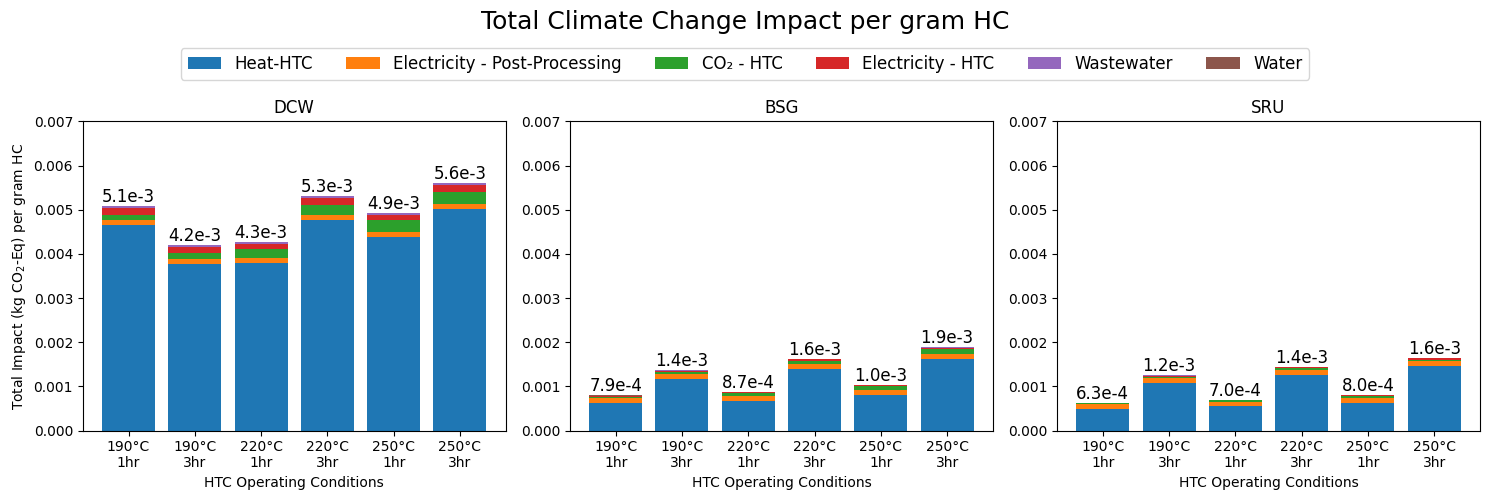

In [42]:
plot_stacked_bar_impact(hydrochar_lcia_manager, 'climate_change', 'gram HC')

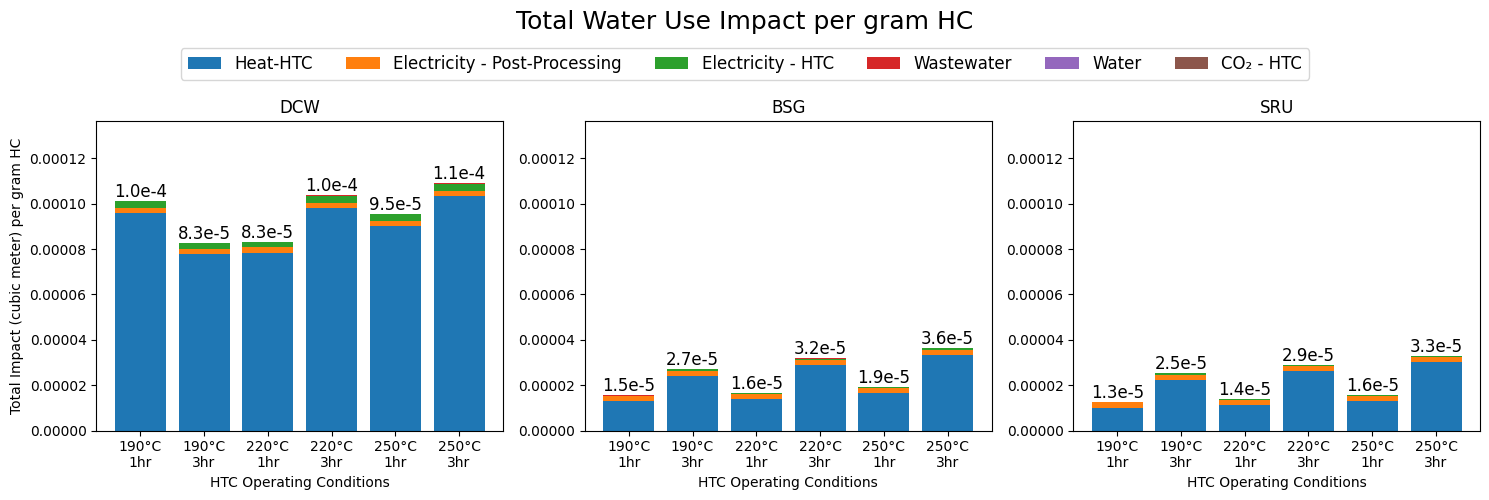

In [43]:
plot_stacked_bar_impact(hydrochar_lcia_manager, 'water_use', 'gram HC')

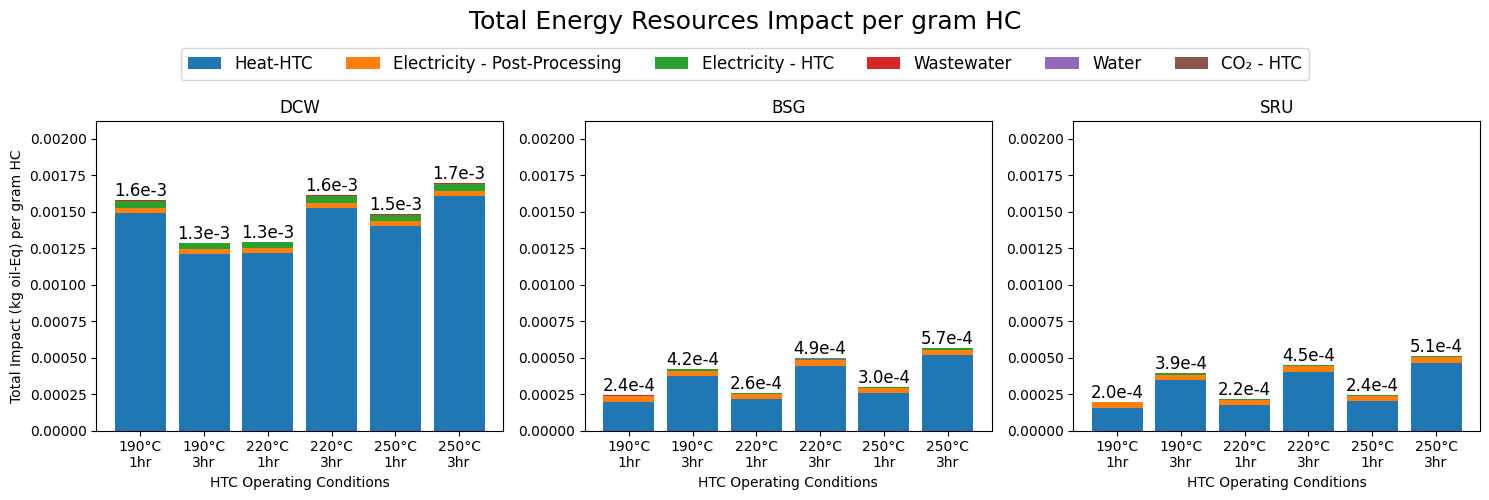

In [44]:
plot_stacked_bar_impact(hydrochar_lcia_manager, 'energy_resources', 'gram HC')

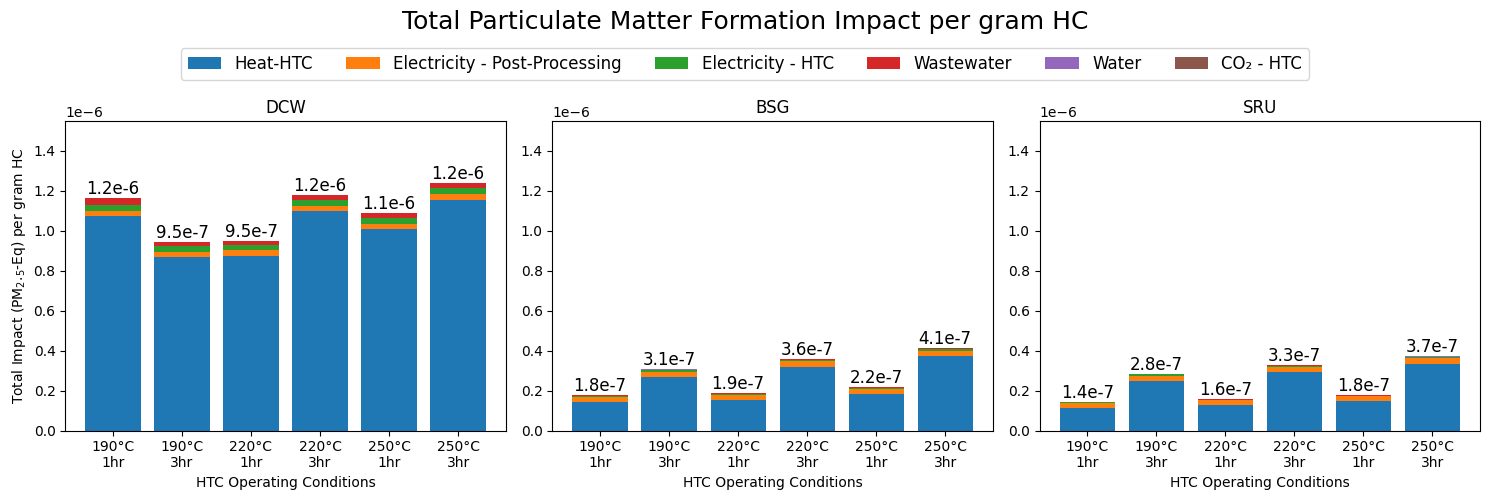

In [45]:
plot_stacked_bar_impact(hydrochar_lcia_manager, 'particulate_matter_formation', 'gram HC')

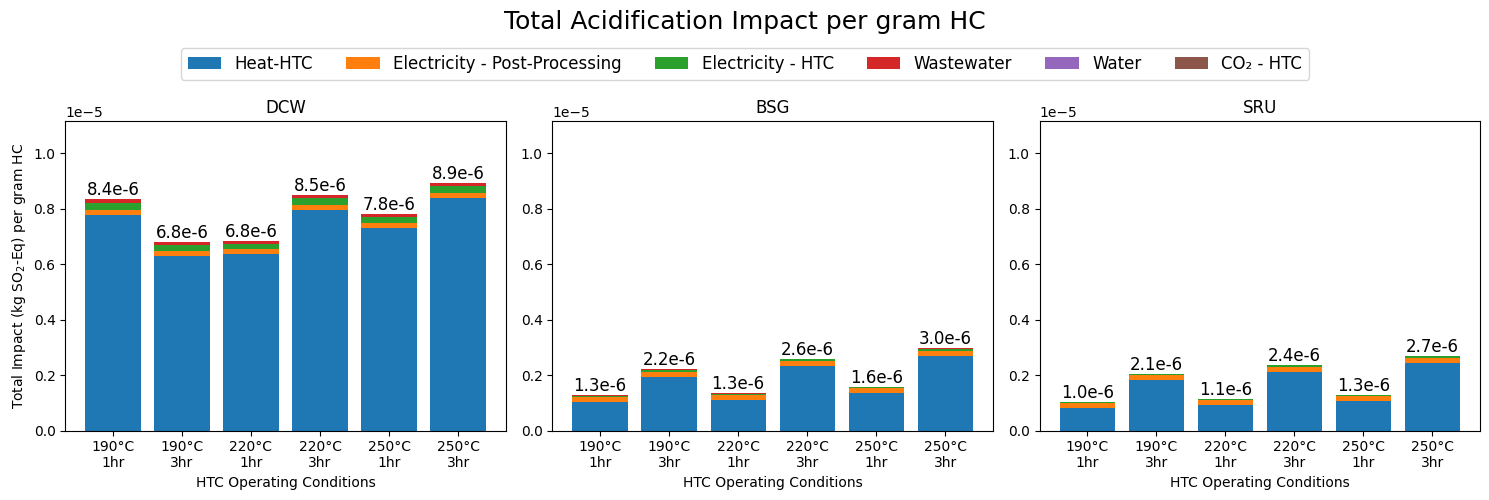

In [46]:
plot_stacked_bar_impact(hydrochar_lcia_manager, 'acidification', 'gram HC')

### 2.6: Plotting Feedstock Standardized LCA Results 
Plotting LCA scores standardized to per 500 grams of feedstock utilized to reflect lab scale conditions. Note that differences in scores are directly attributed to utilizing the quantity of the feedstock, as compared to the production of hydrochar. 

In [47]:
# Replicating Hydrochar LCIA Manager for Re-Use
feedstock_lcia_manager = copy.deepcopy(hydrochar_lcia_manager)
feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
for lcia in feedstock_lcia_list: 
    
    # Getting Relevant Feedstock 
    activity = [act for act in eidb if str(lcia.name) in act['name']][0]
    feedstock_decomposed = activity['name'].split('hydrochar production, ')[1].split('_')
    feedstock_name, temp, time = feedstock_decomposed[0], int(feedstock_decomposed[1][0:3]), int(feedstock_decomposed[2][0])
    
    # Getting Feedstock Quantity 
    feedstock = elementary_feedstocks.get_feedstock(feedstock_name, temp, time)
    
    # Determine standardization factor for getting per feedstock LCIA results
    # LCIA/feedstock = (LCIA / g hydrochar) * (g hydrochar / g feedstock) 
    standardization_factor = 1 / feedstock.quantity
    
    # Alternatively impact_categories = [attr for attr in lcia.__dict__ if attr != 'name']
    impact_categories = lcia.get_impact_categories()
    
    # Alternatively process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']
    process_categories = lcia.get_process_categories()
    
    for impact_category in impact_categories:
        for process_category in process_categories: 
            # Multiply by 500 to mimic experimental conditions
            unit = lcia.get_impact_unit(impact_category, process_category)
            # score = lcia.get_impact_score(impact_category, process_category) * standardization_factor * 1000
            score = lcia.get_impact_score(impact_category, process_category) * standardization_factor
            lcia.set_impact_score(impact_category, process_category, score, unit)
    
    print(lcia.name , "successfully updated in feedstock LCIA Manager.")

hydrochar production, stdBSG_220C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdBSG_250C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_220C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdBSG_190C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdSRU_190C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_250C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdSRU_250C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdSRU_250C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdSRU_220C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_190C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_250C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdSRU_220C_3hr successfully upd

In [48]:
# Identifying Exchanges of Interest 
exchange_names = []
activity = [act for act in eidb if 'hydrochar production' in act['name']][0]
for exc in activity.exchanges(): 
    exchange_names.append(exc.input)
    
# Gathering Process Categories  
process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing', 'Transportation']

# Writing Data to an Excel File 
export_htc_lcia_to_excel(feedstock_lcia_manager, exchange_names, process_categories, 'results/feedstock_lcia.xlsx')

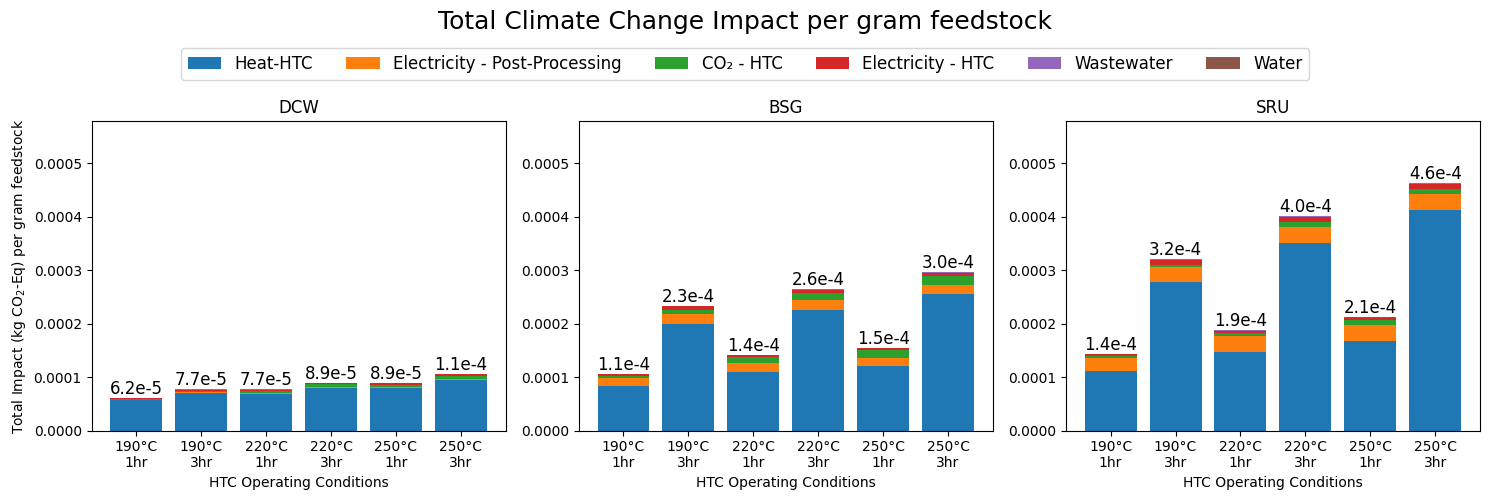

In [49]:
plot_stacked_bar_impact(feedstock_lcia_manager, 'climate_change', 'gram feedstock')

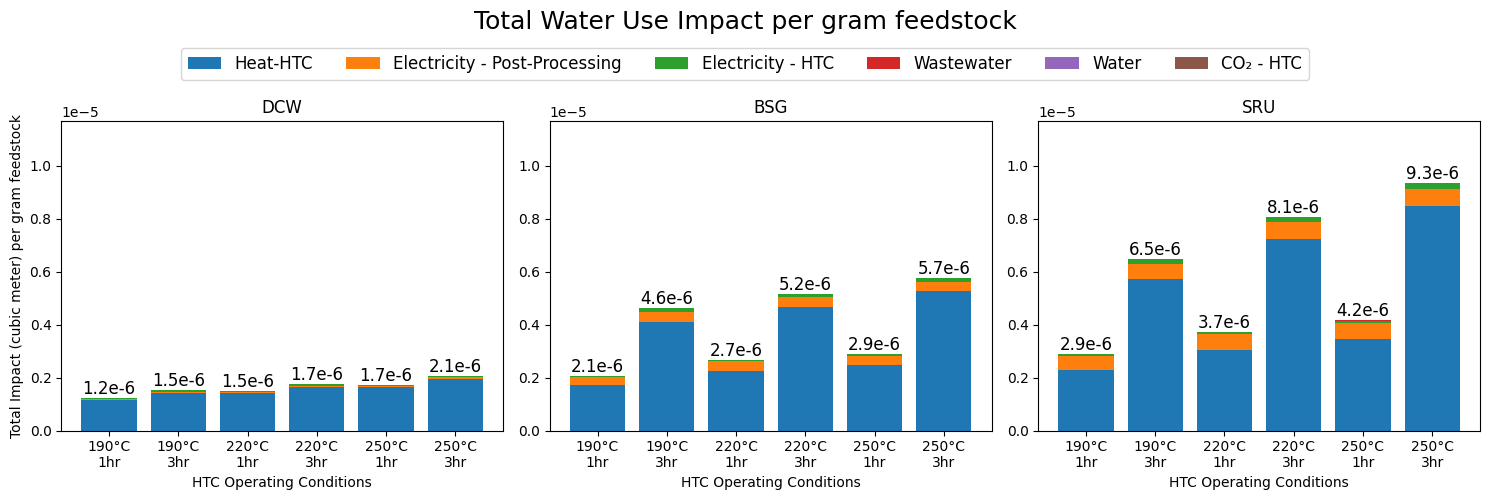

In [50]:
plot_stacked_bar_impact(feedstock_lcia_manager, 'water_use', 'gram feedstock')

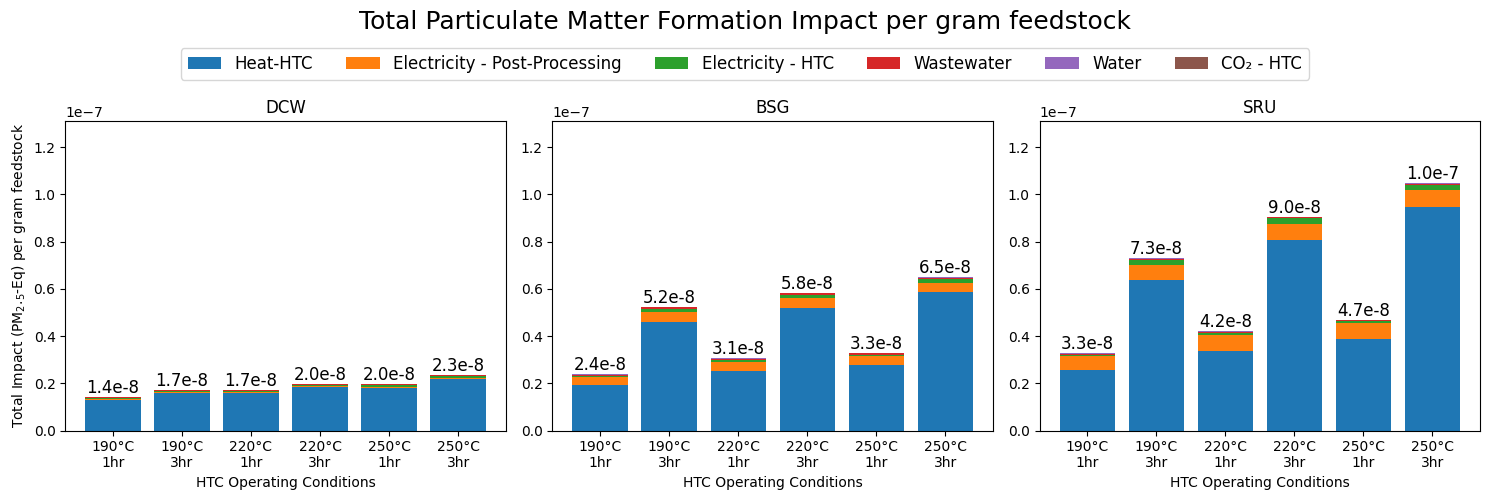

In [51]:
plot_stacked_bar_impact(feedstock_lcia_manager, 'particulate_matter_formation', 'gram feedstock')

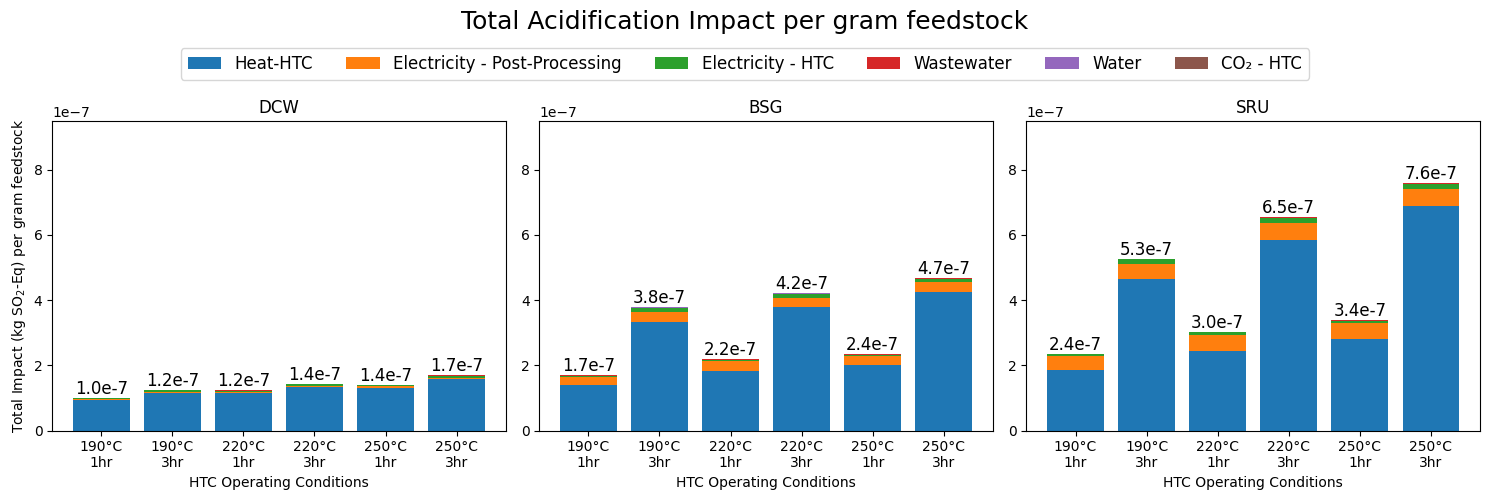

In [52]:
plot_stacked_bar_impact(feedstock_lcia_manager, 'acidification', 'gram feedstock')

### 2.7: Plotting HHV Standardized LCA Results 
Plotting LCA scores standardized to HHV per gram of hydrochar produced. While each process produces a solid hydrochar, the properties of the hydrochar are different, which can affect the best utilization of the hydrochar after production. In this example, we'll focus on a coal replacement for electricity generation through analysis of a higher heating value (HHV). While the downstream process is not in the scope of this analysis and this does not consider the full complexity of post-processing needed for application, it does provide some initial insights towards considering future application.

If considering hydrochar for a different application such as a soil amendment, for carbon sequestration purposes, wastewater treatment, etc, other properties (e.g surface area) may be more applicable. 

In [53]:
# Replicating Hydrochar LCIA Manager for Re-Use
hc_hhv_lcia_manager = copy.deepcopy(hydrochar_lcia_manager)
hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
for lcia in hc_hhv_lcia_list: 
    
    # Getting Relevant Feedstock HC HHV
    activity = [act for act in eidb if str(lcia.name) in act['name']][0]
    feedstock = activity['name']
    hc_hhv = get_parameter(feedstock, 'HHV_HC')
    
    # Determine standardization factor for getting per HHV LCIA results
    # LCIA/HHV = (LCIA / g hydrochar) / ((MJ / kg hydrochar) * (1/1000) )
    standardization_factor = hc_hhv / 1000
    
    # Alternatively impact_categories = [attr for attr in lcia.__dict__ if attr != 'name']
    impact_categories = lcia.get_impact_categories()
    
    # Alternatively process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']
    process_categories = lcia.get_process_categories()
    
    for impact_category in impact_categories:
        for process_category in process_categories: 
            unit = lcia.get_impact_unit(impact_category, process_category)
            score = lcia.get_impact_score(impact_category, process_category) / standardization_factor 
            lcia.set_impact_score(impact_category, process_category, score, unit)
        
    
    print(lcia.name , "successfully updated in hydrochar HHV LCIA Manager.")

hydrochar production, stdBSG_220C_3hr successfully updated in hydrochar HHV LCIA Manager.
hydrochar production, stdBSG_250C_3hr successfully updated in hydrochar HHV LCIA Manager.
hydrochar production, rawDCW_220C_3hr successfully updated in hydrochar HHV LCIA Manager.
hydrochar production, stdBSG_190C_1hr successfully updated in hydrochar HHV LCIA Manager.
hydrochar production, stdSRU_190C_1hr successfully updated in hydrochar HHV LCIA Manager.
hydrochar production, rawDCW_250C_3hr successfully updated in hydrochar HHV LCIA Manager.
hydrochar production, stdSRU_250C_1hr successfully updated in hydrochar HHV LCIA Manager.
hydrochar production, stdSRU_250C_3hr successfully updated in hydrochar HHV LCIA Manager.
hydrochar production, stdSRU_220C_1hr successfully updated in hydrochar HHV LCIA Manager.
hydrochar production, rawDCW_190C_1hr successfully updated in hydrochar HHV LCIA Manager.
hydrochar production, rawDCW_250C_1hr successfully updated in hydrochar HHV LCIA Manager.
hydrochar 

In [54]:
# Identifying Exchanges of Interest 
exchange_names = []
activity = [act for act in eidb if 'hydrochar production' in act['name']][0]
for exc in activity.exchanges(): 
    exchange_names.append(exc.input)
    
# Gathering Process Categories  
process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing', 'Transportation']

# Writing Data to an Excel File 
export_htc_lcia_to_excel(hc_hhv_lcia_manager, exchange_names, process_categories, 'results/hhv_hc_lcia.xlsx')

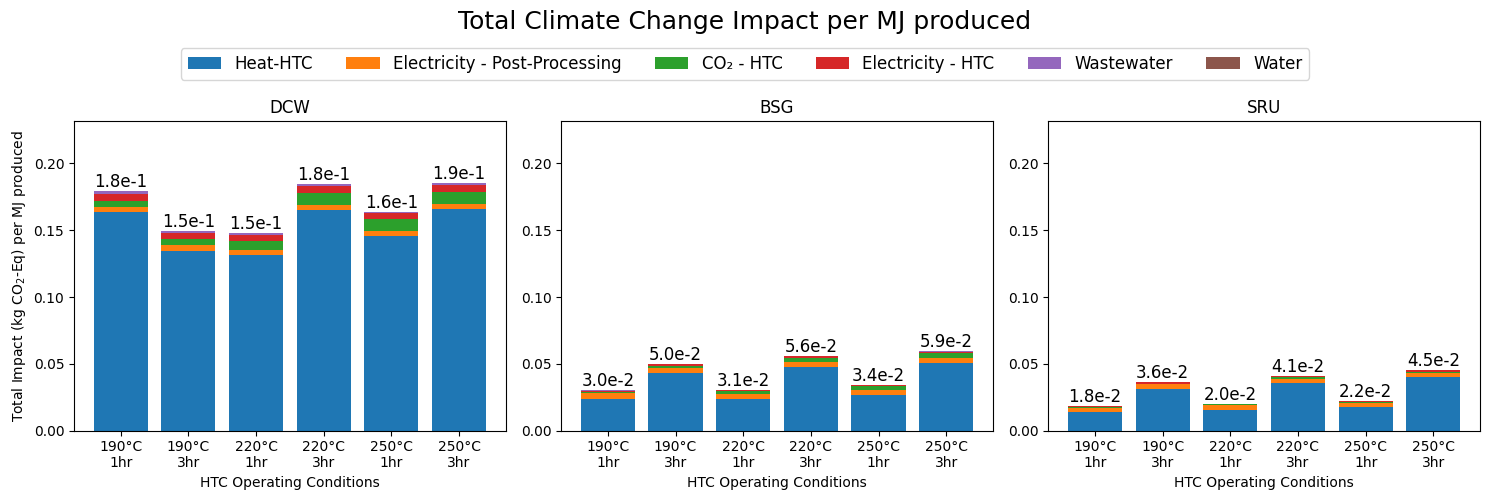

In [55]:
plot_stacked_bar_impact(hc_hhv_lcia_manager, 'climate_change', 'gram HC / HHV')

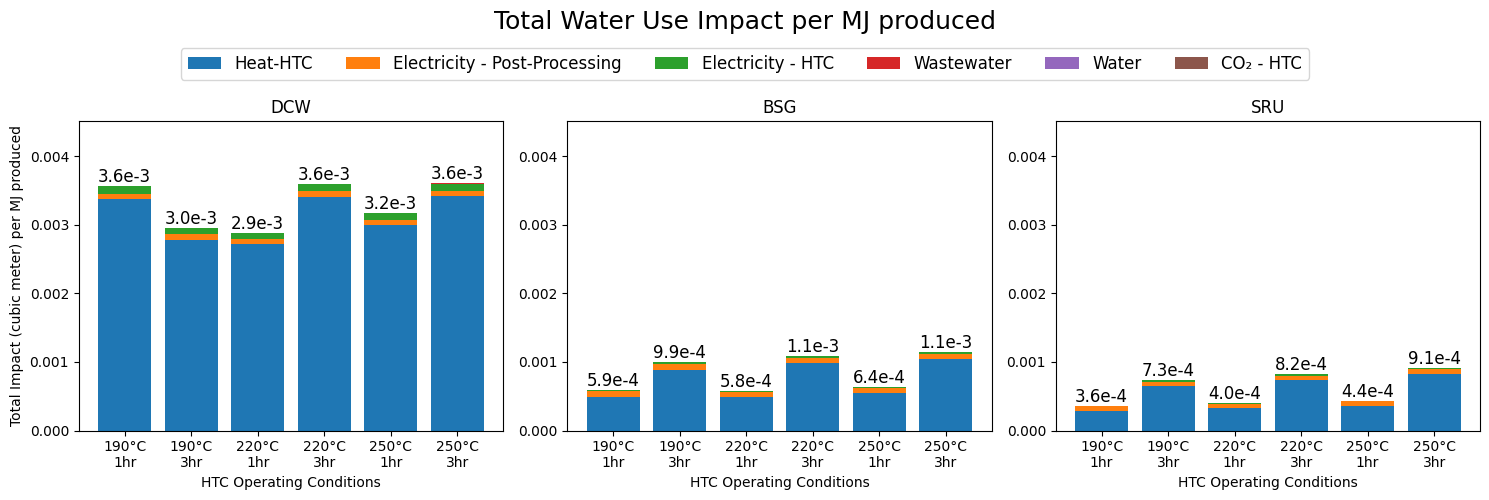

In [56]:
plot_stacked_bar_impact(hc_hhv_lcia_manager, 'water_use', 'gram HC / HHV')

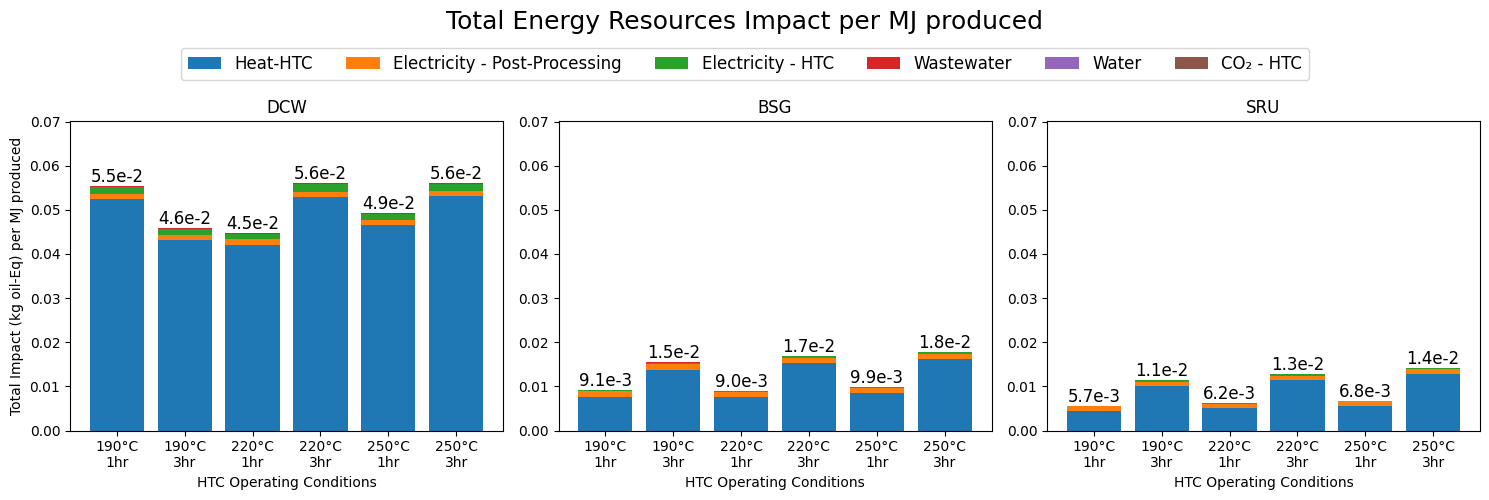

In [57]:
plot_stacked_bar_impact(hc_hhv_lcia_manager, 'energy_resources', 'gram HC / HHV')

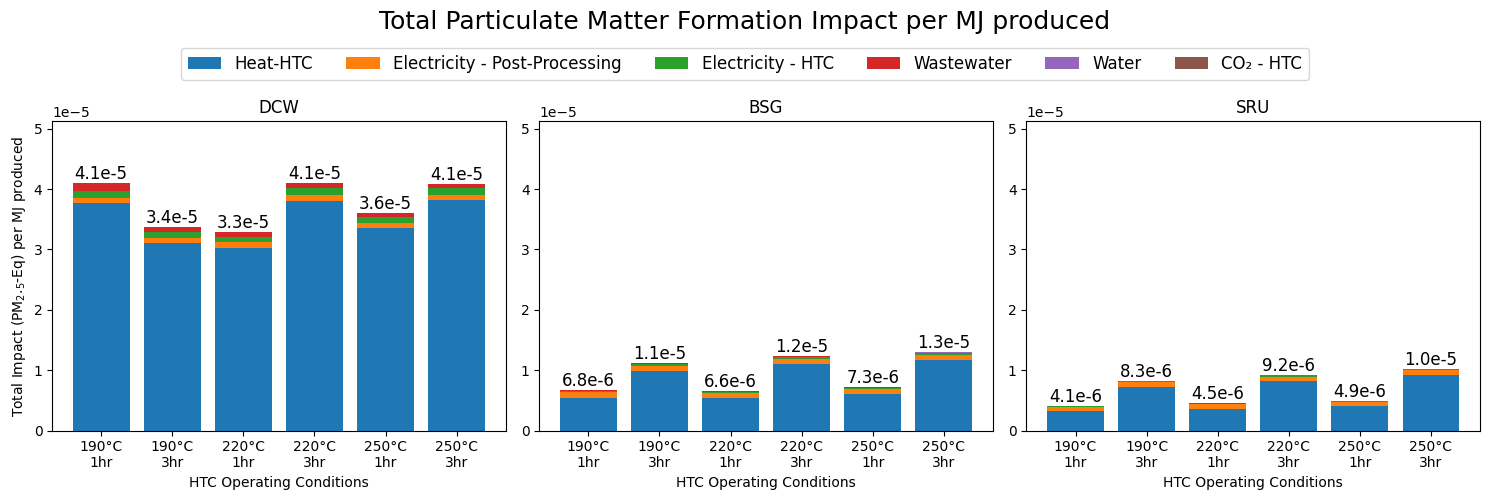

In [58]:
plot_stacked_bar_impact(hc_hhv_lcia_manager, 'particulate_matter_formation', 'gram HC / HHV')

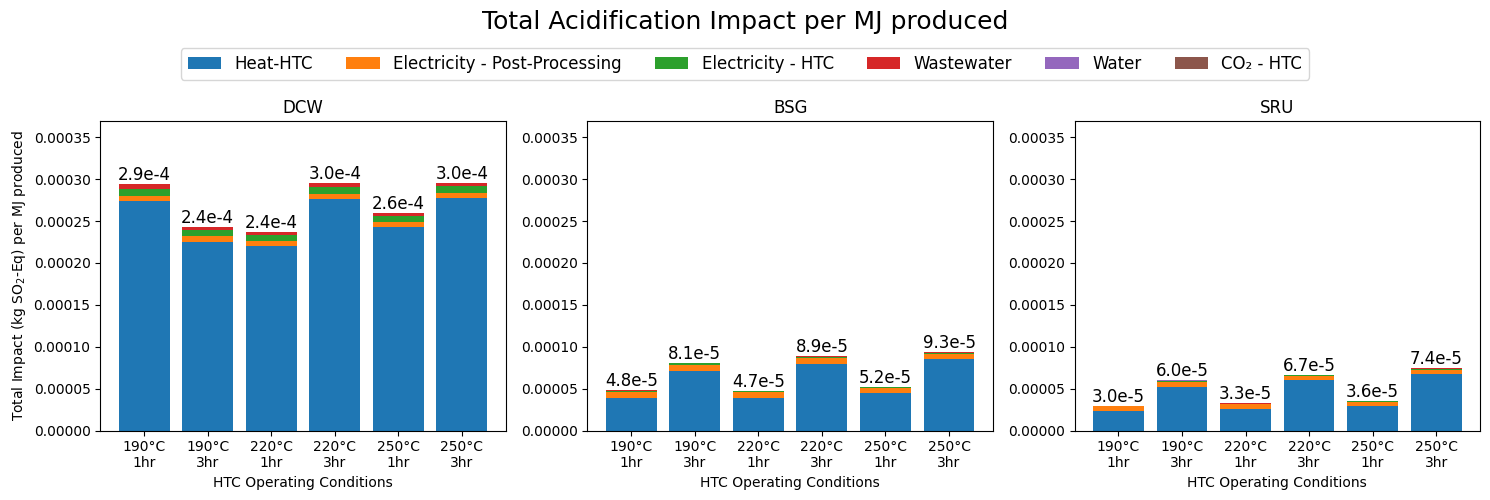

In [59]:
plot_stacked_bar_impact(hc_hhv_lcia_manager, 'acidification', 'gram HC / HHV')

In [ ]:
def plot_combined_stacked_bar_impact(hydrochar_lcia_manager, feedstock_lcia_manager, hc_hhv_lcia_manager, impact_category):
    '''
    Plots a combined stacked bar graph for a Life Cycle Impact Category given a set of LCIA results for hydrochar, 
    feedstock, and HC HHV standardization techniques in a single figure with one set of labels and title.
    
    Parameters:
        hydrochar_lcia_manager (obj): Contains all Hydrochar LCIA results.
        feedstock_lcia_manager (obj): Contains all Feedstock LCIA results.
        hc_hhv_lcia_manager (obj): Contains all HC HHV LCIA results.
        impact_category (str): The LCIA impact category to plot.
    '''

    # Combine the LCIA lists
    hydrochar_lcia_list = [hc for attr, lcia in hydrochar_lcia_manager.__dict__.items() for hc in lcia]
    feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
    hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
    
    combined_lcia_list = [feedstock_lcia_list, hydrochar_lcia_list, hc_hhv_lcia_list]
    standardization_labels = ["Impact per gram feedstock", "Impact per gram HC", "Impact per MJ"]

    # Process categories and colorblind-friendly colors
    process_categories = ['Water', 'Heat-HTC', 'Electricity - HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']
    colors = plt.get_cmap("tab10").colors[:len(process_categories)]
    units = None

    fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True)
    fig.subplots_adjust(hspace=0.4, wspace=0.3)

    for row, lcia_list in enumerate(combined_lcia_list):
        labels = [hc.name.split('hydrochar production, ')[1] for hc in lcia_list]
        data = {process: [] for process in process_categories}

        for hc in lcia_list:
            impact_data = getattr(hc, impact_category)
            for process in process_categories:
                score = impact_data[process]['score']
                unit = impact_data[process]['unit']
                data[process].append(score)
                if not units:
                    units = unit

        data_matrix = np.array([data[process] for process in process_categories])
        labels, data_matrix = zip(*sorted(zip(labels, data_matrix.T), key=lambda x: x[0]))
        data_matrix = np.array(data_matrix).T

        sorted_indices = np.argsort(data_matrix.sum(axis=1))[::-1]
        sorted_data_matrix = data_matrix[sorted_indices]
        sorted_process_categories = np.array(process_categories)[sorted_indices]

        groups = [range(0, 6), range(6, 12), range(12, 18)]
        row_max_bottom = 0

        def clean_label(label):
            parts = label.split('_')[1:]  
            cleaned_label = '\n'.join(part.replace('C', '°C') for part in parts)
            return cleaned_label

        for col, ax in enumerate(axes[row, :]):
            group = groups[col]
            bottom = np.zeros(len(group))

            for j, process in enumerate(sorted_process_categories):
                scores = sorted_data_matrix[j][group]
                ax.bar([clean_label(labels[k]) for k in group], scores, bottom=bottom, label=process, color=colors[j])
                bottom += scores

            # titles = [labels[k] for k in group][0].split('_')[0][3:].upper() + standardization_labels[row]
            titles = standardization_labels[row]
            row_max_bottom = max(row_max_bottom, bottom.max())
            subplot_label = chr(97 + col + row * 3)  # (a), (b), etc.
            ax.set_title(titles, fontsize=16)
            ax.text(-0.1, 1.05, f'({subplot_label})', transform=ax.transAxes, size=16)

            for k, total in enumerate(bottom):
                formatted_total = f'{total:.1e}'.replace('e-0', 'e-').replace('e+0', 'e')
                ax.text(k, total, f'{formatted_total}', ha='center', va='bottom', fontsize=12)

        # Set independent y-axis limits for each row
        for col_ax in axes[row, :]:
            col_ax.set_ylim(0, row_max_bottom * 1.25)
    
    row_labels = ['Dairy Cheese Whey (DCW)', 'Brewery Spent Grain (BSG)', 'Supermarket Retail University (SRU)']
    for row, label in enumerate(row_labels):
        # Get the position of the first subplot in the row
        ax = axes[0, row]  # Middle column for centering
        pos = ax.get_position()
        x = pos.x0 + (pos.x1 - pos.x0) * 0.5
        if label == 'Brewery Spent Grain (BSG)': 
            x += (pos.x1 - pos.x0) * 0.15
        if label == 'Supermarket Retail University (SRU)': 
            x += (pos.x1 - pos.x0) * 0.25
        y = pos.y0 + (pos.y1 - pos.y0) * 1.3
        fig.text(x, y, label, ha='center', va='bottom', fontsize=16) 
        
    formatted_units = re.sub(r'(\d+)', r'$_{\1}$', units)
    fig.text(0.04, 0.5, f'Total {impact_category.replace("_", " ").title()} Impact ({formatted_units})', va='center', rotation='vertical', fontsize=16)
    fig.text(0.5, 0.02, "Hydrothermal Carbonization Operating Conditions", ha='center', fontsize=16)

    handles, labels = axes[0, -1].get_legend_handles_labels()
    labels = [label.replace('CO2 - HTC', 'CO\u2082 - HTC') for label in labels]
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1), ncol=len(sorted_process_categories), fontsize=14, frameon=False)
    
    plt.tight_layout(rect=[0.05, 0.03, 1, 0.95], pad=2.0)
    file_path = os.path.join('figures', 'Figure 3.png')
    plt.savefig('figures/Figure 2.png')
    
    plt.show()


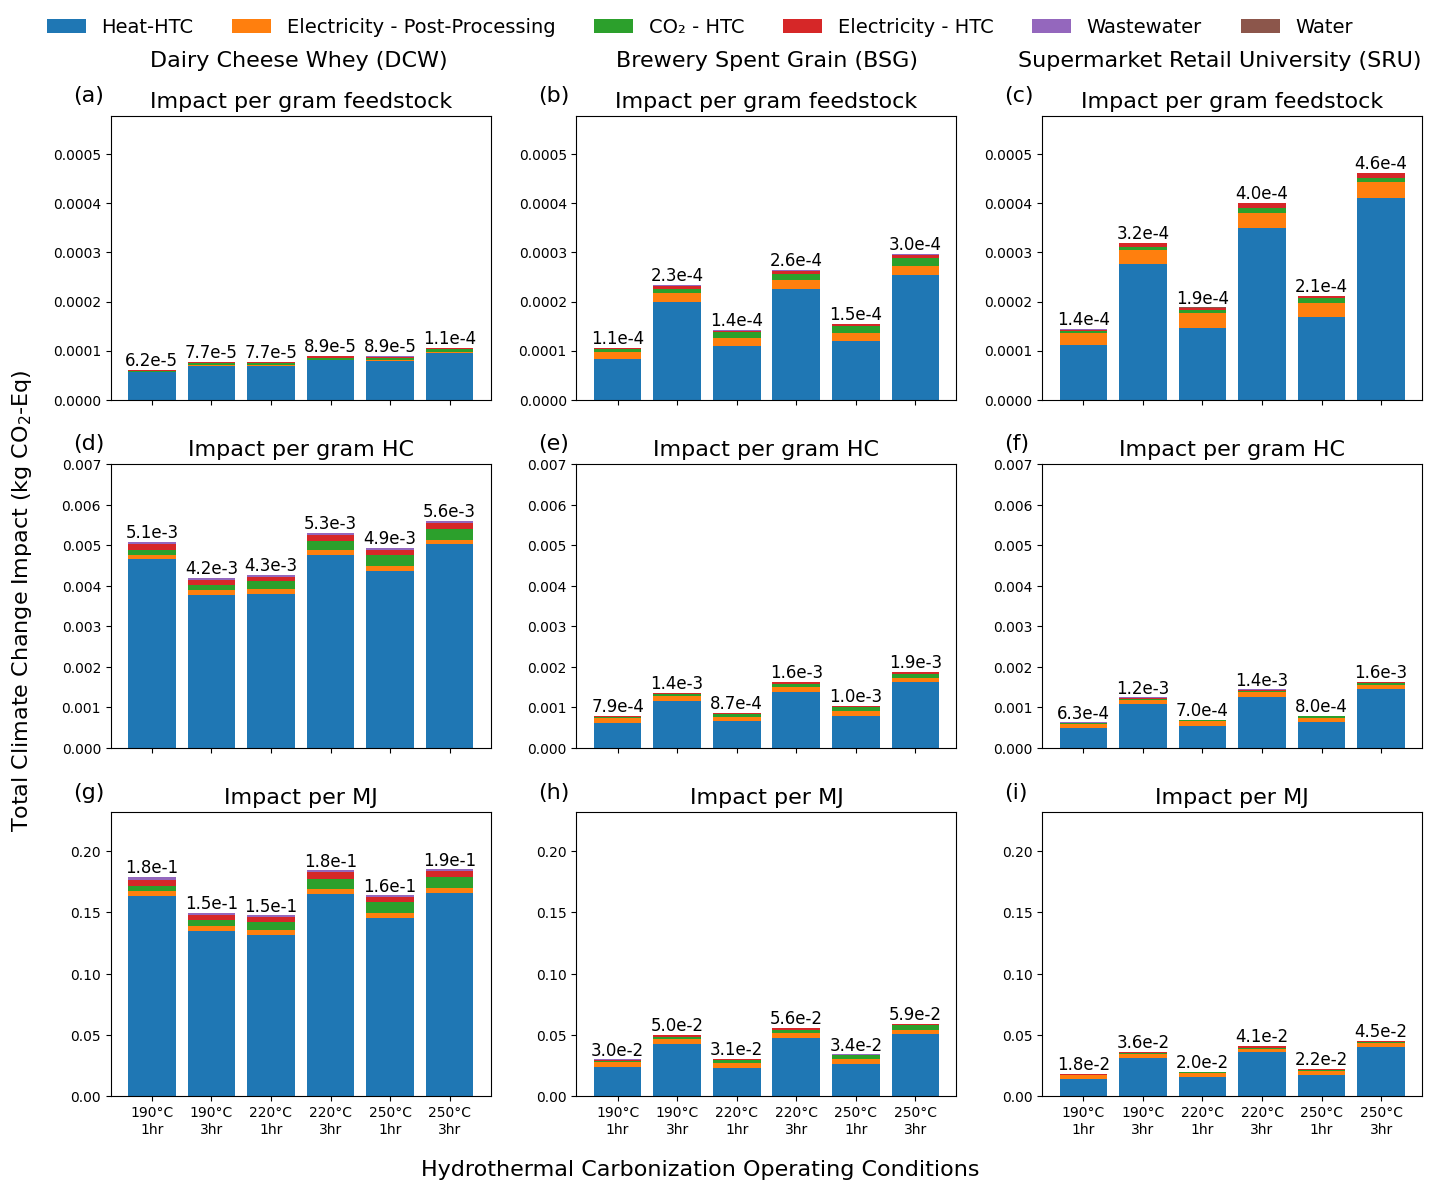

In [61]:
plot_combined_stacked_bar_impact(hydrochar_lcia_manager, feedstock_lcia_manager, hc_hhv_lcia_manager, 'climate_change')

In [ ]:
def plot_combined_stacked_bar_method_weights(hydrochar_lcia_manager, feedstock_lcia_manager, hc_hhv_lcia_manager, method_names):
    '''
    Plots a stacked bar chart showing standardized LCIA method scores to compare the contribution (weight) 
    of each impact assessment method across standardization techniques (e.g., per g HC, per g feedstock, per MJ).

    Parameters:
        hydrochar_lcia_manager (obj): Contains Hydrochar LCIA results.
        feedstock_lcia_manager (obj): Contains Feedstock LCIA results.
        hc_hhv_lcia_manager (obj): Contains HC HHV LCIA results.
        method_names (list of str): List of method names to include (e.g., ReCiPe, TRACI impact categories).
    '''

    hydrochar_lcia_list = [hc for attr, lcia in hydrochar_lcia_manager.__dict__.items() for hc in lcia]
    feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
    hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]

    combined_lcia_list = [hydrochar_lcia_list, feedstock_lcia_list, hc_hhv_lcia_list]
    normalization_labels = ["Normalized Score per gram HC", "Normalized Score per gram feedstock", "Normalized Score per MJ"]

    colors = plt.get_cmap("tab10").colors[:len(method_names)]

    fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True)
    fig.subplots_adjust(hspace=0.4, wspace=0.3)

    for row, lcia_list in enumerate(combined_lcia_list):
        labels = [hc.name.split('hydrochar production, ')[1] for hc in lcia_list]

        all_scores = []
        for hc in lcia_list:
            process_categories = ['Water', 'Heat-HTC', 'Electricity - HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']
            scores = [sum(hc.get_impact_score(method, category) or 0 for category in process_categories) for method in method_names]
            all_scores.append(scores)

        all_scores_array = np.array(all_scores)  # shape (n_samples, n_methods)
        method_totals = all_scores_array.sum(axis=0)  # shape (n_methods,)

        # Remove method with lowest total
        min_index = method_totals.argmin()
        method_names.pop(min_index)
        all_scores_array = np.delete(all_scores_array, min_index, axis=1)  # remove column

        # Normalize
        normalized_scores = all_scores_array / all_scores_array.sum(axis=1, keepdims=True)

        sorted_indices = np.argsort(labels)
        labels = [labels[i] for i in sorted_indices]
        normalized_scores = normalized_scores[sorted_indices]

        groups = [range(0, 6), range(6, 12), range(12, 18)]

        def clean_label(label):
            parts = label.split('_')[1:]
            cleaned_label = '\n'.join(part.replace('C', '°C') for part in parts)
            return cleaned_label

        for col, ax in enumerate(axes[row, :]):
            group = groups[col]
            bottom = np.zeros(len(group))

            group_scores = normalized_scores[group, :]  # shape (6, n_methods)
            method_order = np.argsort(-group_scores.sum(axis=0))  # largest first

            for rank, j in enumerate(method_order):
                values = group_scores[:, j]
                ax.bar([clean_label(labels[k]) for k in group], values, bottom=bottom, label=method_names[j], color=colors[j])
                bottom += values

            subplot_label = chr(97 + col + row * 3)
            ax.set_title(normalization_labels[row], fontsize=16)
            ax.text(-0.1, 1.05, f'({subplot_label})', transform=ax.transAxes, size=16)

            for k, total in enumerate(bottom):
                ax.text(k, total, f'{total:.2f}', ha='center', va='bottom', fontsize=11)

            ax.set_ylim(0, 1.1)

    # Add row labels at the top
    row_labels = ['Dairy Cheese Whey (DCW)', 'Brewery Spent Grain (BSG)', 'Supermarket Retail University (SRU)']
    for row, label in enumerate(row_labels):
        ax = axes[0, row]
        pos = ax.get_position()
        x = pos.x0 + (pos.x1 - pos.x0) * 0.5
        if label == 'Brewery Spent Grain (BSG)':
            x += (pos.x1 - pos.x0) * 0.15
        if label == 'Supermarket Retail University (SRU)':
            x += (pos.x1 - pos.x0) * 0.25
        y = pos.y0 + (pos.y1 - pos.y0) * 1.3
        fig.text(x, y, label, ha='center', va='bottom', fontsize=16)

    fig.text(0.04, 0.5, 'Normalized Impact Assessment Method Weight', va='center', rotation='vertical', fontsize=16)
    fig.text(0.5, 0.02, "Operating Conditions", ha='center', fontsize=16)

    handles, labels = axes[0, -1].get_legend_handles_labels()
    total_contributions = normalized_scores.sum(axis=0)
    keep_indices = [i for i, score in enumerate(total_contributions) if score > 0.01]

    filtered_handles = [handles[i] for i in keep_indices]
    filtered_labels = [labels[i].replace('_', ' ').title() for i in keep_indices]

    half = len(filtered_labels) // 2 + len(filtered_labels) % 2
    row1_handles = filtered_handles[:half]
    row1_labels = filtered_labels[:half]
    row2_handles = filtered_handles[half:]
    row2_labels = filtered_labels[half:]

    fig.legend(row1_handles, row1_labels, loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=half, fontsize=14, frameon=False)
    fig.legend(row2_handles, row2_labels, loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=len(filtered_labels) - half, fontsize=14, frameon=False)

    plt.tight_layout(rect=[0.05, 0.03, 1, 0.95], pad=2.0)
    plt.show()

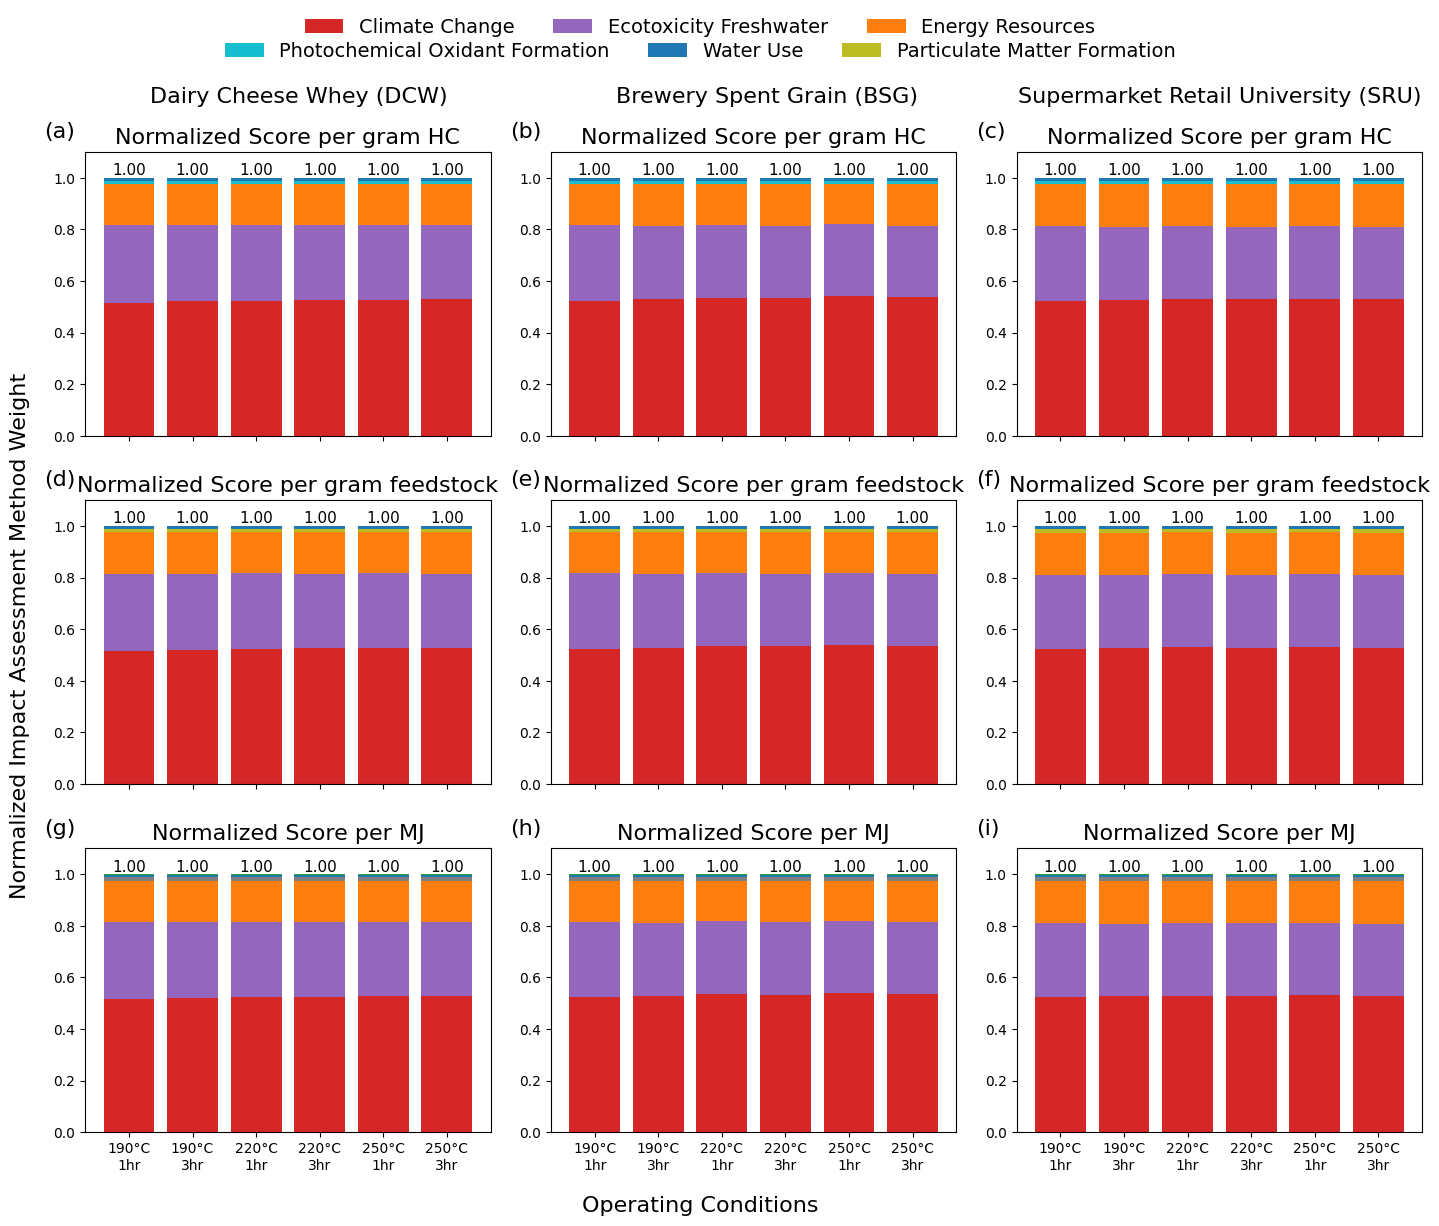

In [63]:
method_names = [str(get_impact_category(m)) for m in methods] 
plot_combined_stacked_bar_method_weights(hydrochar_lcia_manager, feedstock_lcia_manager, hc_hhv_lcia_manager, method_names)

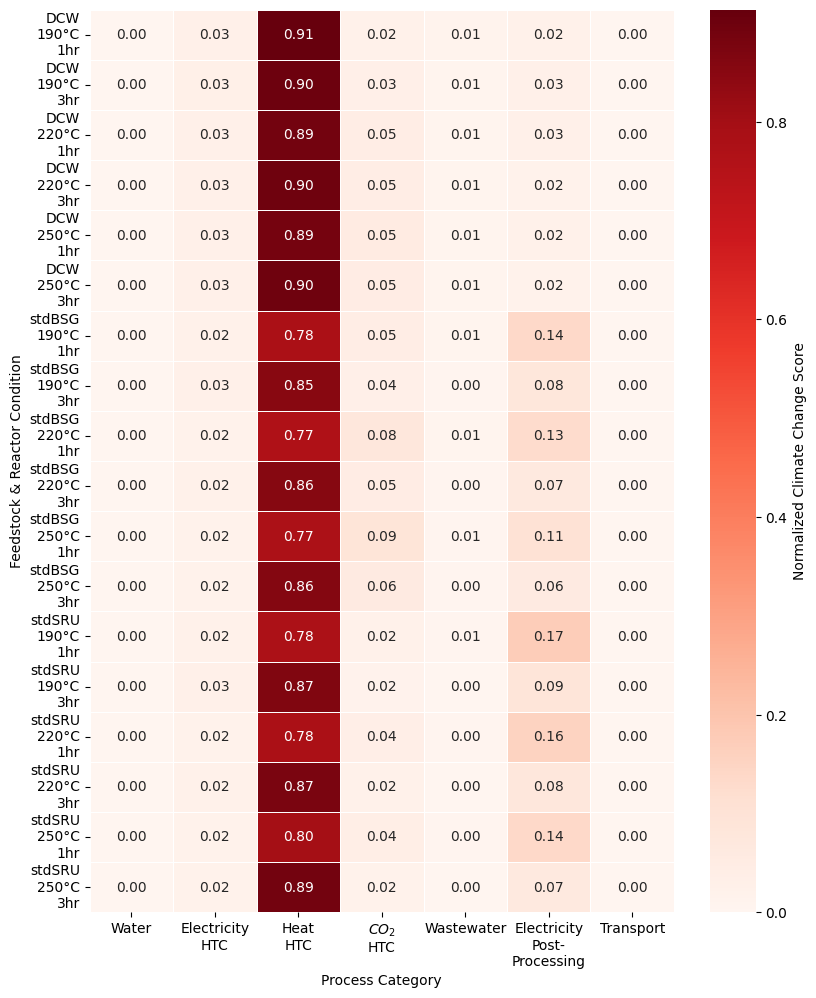

In [64]:
process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing', 'Transportation']

# Flatten hydrochar LCIA data
hydrochar_lcia_list = [
    hc for attr, lcia in hydrochar_lcia_manager.__dict__.items() for hc in lcia
]

# Extract raw scores and labels
climate_data = []
labels = []

for hc in hydrochar_lcia_list:
    scores = [hc.get_impact_score('climate_change', cat) or 0 for cat in process_categories]
    climate_data.append(scores)
    name = hc.name.split('hydrochar production, ')[1]
    labels.append(name)

# Normalize rows
climate_array = np.array(climate_data)
row_sums = climate_array.sum(axis=1, keepdims=True)
normalized_climate_array = climate_array / (row_sums + 1e-12)

# Label cleaning
def clean_label(label):
    parts = label.split('_')
    cleaned = []
    for part in parts:
        part = part.replace('raw', '')
        part = part.replace('C', '°C') if 'C' in part and not part.endswith('°C') else part
        part = part.replace('D°CW', 'DCW')
        cleaned.append(part)
    return '\n'.join(cleaned)

# Clean and sort labels
cleaned_labels = [clean_label(lab) for lab in labels]
sort_idx = np.argsort(labels)
sorted_labels = [cleaned_labels[i] for i in sort_idx]
sorted_data = normalized_climate_array[sort_idx, :]

# Plotting
pretty_process_labels = [
    'Water',
    'Electricity\nHTC',
    'Heat\nHTC',
    '$CO_2$\nHTC',
    'Wastewater',
    'Electricity\nPost-\nProcessing',
    'Transport'
]

plt.figure(figsize=(len(pretty_process_labels) * 1.2, len(sorted_labels) * 0.45 + 2))
sns.heatmap(
    sorted_data,
    xticklabels=pretty_process_labels,
    yticklabels=sorted_labels,
    annot=True,
    fmt=".2f",
    cmap='Reds',
    linewidths=0.5,
    cbar_kws={'label': 'Normalized Climate Change Score'}
)

plt.xticks(rotation=0, ha='center')
plt.xlabel('Process Category')
plt.ylabel('Feedstock & Reactor Condition')
# plt.title('Normalized Climate Change Impact by Process and Condition')
plt.tight_layout()
plt.savefig('figures/Figure S1.png')
plt.show()


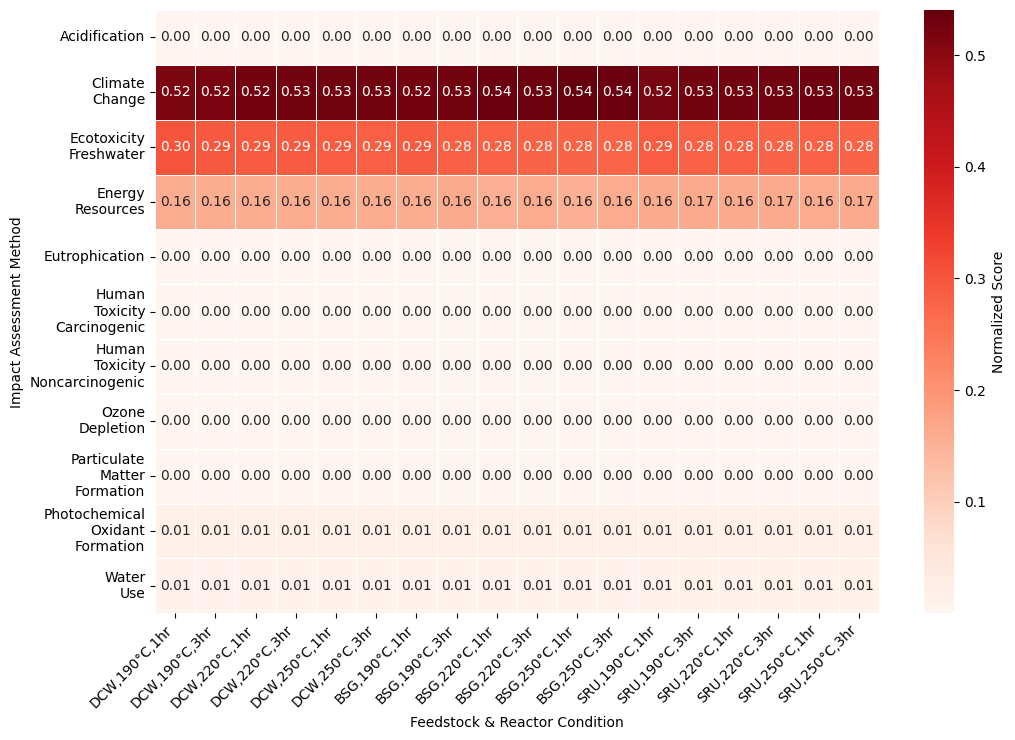

In [65]:
hydrochar_lcia_list = [hc for attr, lcia in hydrochar_lcia_manager.__dict__.items() for hc in lcia]

# Get method names
method_names = hydrochar_lcia_list[0].get_impact_categories()

# Prepare data
labels = [hc.name.split('hydrochar production, ')[1] for hc in hydrochar_lcia_list]
data = {method: [] for method in method_names}

# Extract raw scores by method
for hc in hydrochar_lcia_list:
    for method in method_names:
        process_categories = ['Water', 'Heat-HTC', 'Electricity - HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']
        total_score = sum(hc.get_impact_score(method, category) or 0 for category in process_categories)
        data[method].append(total_score)

# Convert to matrix (methods x samples) and normalize
score_matrix = np.array([data[method] for method in method_names])
normalized_matrix = score_matrix / score_matrix.sum(axis=0, keepdims=True)

# Clean and sort x-axis labels (conditions)
def clean_condition_label(label):
    parts = label.split('_')
    cleaned = []
    for part in parts:
        part = part.replace('raw', '')
        part = part.replace('std', '')
        part = part.replace('C', '°C') if 'C' in part and not part.endswith('°C') else part
        part = part.replace('D°CW', 'DCW')
        cleaned.append(part)
    return ','.join(cleaned)

x_labels_raw = [hc.name.split('hydrochar production, ')[1] for hc in hydrochar_lcia_list]
x_labels_cleaned = [clean_condition_label(label) for label in x_labels_raw]
x_sort_idx = np.argsort(x_labels_raw)
x_labels_sorted = [x_labels_cleaned[i] for i in x_sort_idx]
normalized_matrix = normalized_matrix[:, x_sort_idx]

# Clean and sort y-axis labels (methods)
y_labels_cleaned = [method.replace('_', '\n').title() for method in method_names]
y_sort_idx = np.argsort(y_labels_cleaned)
y_labels_sorted = [y_labels_cleaned[i] for i in y_sort_idx]
normalized_matrix = normalized_matrix[y_sort_idx, :]

# Create heatmap
plt.figure(figsize=(len(x_labels_sorted) * 0.6, len(y_labels_sorted) * 0.5 + 2))
sns.heatmap(
    normalized_matrix,
    xticklabels=x_labels_sorted,
    yticklabels=y_labels_sorted,
    annot=True,
    cmap='Reds',
    fmt='.2f',
    cbar_kws={'label': 'Normalized Score'},
    linewidths=0.5
)

plt.xticks(rotation=45, ha='right')
# plt.title('Normalized Impact Scores by Method and Condition')
plt.ylabel('Impact Assessment Method')
plt.xlabel('Feedstock & Reactor Condition')
plt.tight_layout()
plt.savefig('figures/Figure S2.png')
plt.show()


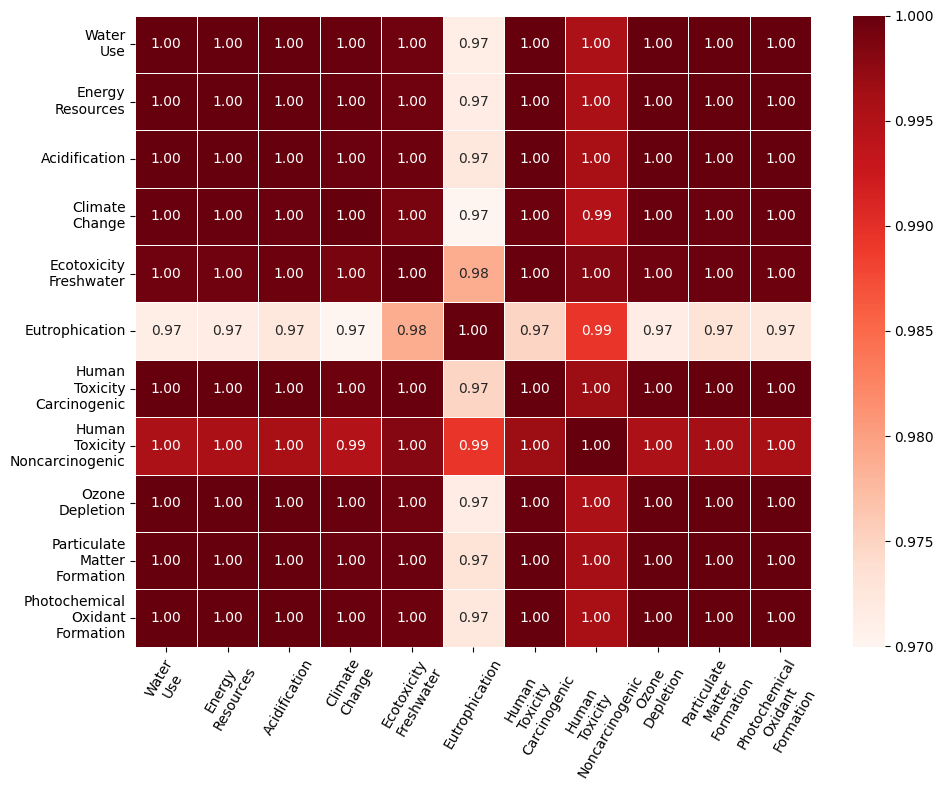

In [66]:
# Showing correlation between impact assessment categories
hydrochar_lcia_list = [hc for attr, lcia in hydrochar_lcia_manager.__dict__.items() for hc in lcia]
impact_categories = hydrochar_lcia_list[0].get_impact_categories()

for row in hydrochar_lcia_list:
    labels = [hc.name.split('hydrochar production, ')[1] for hc in hydrochar_lcia_list]
    data = {impact_category: [] for impact_category in impact_categories}
    for hc in hydrochar_lcia_list:
        for impact_category in impact_categories:
            data[impact_category].append(hc.get_total_impact_score(impact_category))
    
    data_matrix = np.array([data[impact_category] for impact_category in impact_categories])
    labels, data_matrix = zip(*sorted(zip(labels, data_matrix.T), key=lambda x: x[0]))
    data_matrix = np.array(data_matrix).T
    
    sorted_indices = np.argsort(data_matrix.sum(axis=1))[::-1]
    sorted_data_matrix = data_matrix[sorted_indices]
    sorted_impact_categories = np.array(impact_categories)[sorted_indices]

def clean_label(label):
    parts = label.split('_') 
    cleaned_parts = []
    for part in parts:
        if 'DCW' in part: 
            cleaned_parts.append(part)
        elif 'C' in part and not part.endswith('°C'):
            cleaned_parts.append(part.replace('C', '°C'))
        else:
            cleaned_parts.append(part)  
    return '\n'.join(cleaned_parts) 
            
cleaned_labels = [clean_label(label) for label in labels]

def clean_labels_for_heatmap(labels):
    """
    Cleans the labels by replacing underscores with a line break and converting to title case.
    """
    cleaned_labels = [label.replace('_', '\n').title() for label in labels]
    return cleaned_labels

cleaned_impact_categories = clean_labels_for_heatmap(impact_categories)

# Compute correlation matrix
correlation_matrix = np.corrcoef(data_matrix)

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, xticklabels=cleaned_impact_categories, yticklabels=cleaned_impact_categories, 
            cmap='Reds', annot=True, fmt='.2f', linewidths=0.5)
plt.xticks(rotation=60)

# Labels and title
# plt.title('Correlation Matrix of Impact Categories', fontsize=14)
plt.tight_layout()
plt.show()


## 3: Comprehensive LCA
From our previous standardization results, the following interpretations can be made: 
- There is synonymous alignment across the impact assessments. Therefore, one impact category can be sufficient to compare differences across each standardization technique. 
- As the same exchanges are replicated across all 18 scenarios, the scenarios with the lowest impact assessment scores stem from efficient utilization of inputs. 
- The environmental hotspots are from post-processing and from heat, generated from electricity, with the HTC reactor.  
- The lowest impact assessment scores for each feedstock vary based on the standardization technique. 

To determine the 'optimal' condition or the lowest environmental impact for each feedstock across each standardization technique, we will examine optimal solutions from a multi-objective systems optimization perspective for one impact assessment method, climate change, as we have three relevant objectives: 
1. To minimize the environmental impact standardized to 1 g of feedstock treated. 
2. To minimize the environmental impact standardized to 1 g of hydrochar produced. 
3. To minimize the environmental impact per creating a higher value of hydrochar produced for a energy post-valorization pathway, through consideration of HHV. 


In [ ]:
# Helper function for getting GWP data 
def get_gwp_data(feedstock_name, standardization_columns): 
    '''
    Returns a Pandas DataFrame of GWP values per all standardization categories, given a feedstock. 
    
    Parameters:
        feedstock_name (str): Name of feedstock (i.e. DCW, SRU, BSG)   
        standardization_columns (list): List of Standardization Columns ['Feedstock', 'Hydrochar', 'Hydrochar HHV']
    '''
    
    # Helper Function to retrieve and sort impact scores for an LCIA Manager. 
    def get_sorted_impact_scores(manager):
        lcia_list = [hc for attr, lcia in manager.__dict__.items() for hc in lcia]
        return sorted(lcia_list, key=lambda x: x.name)

    # Retrieve and sort impact scores
    feedstock_lcia_list = get_sorted_impact_scores(feedstock_lcia_manager)
    hc_lcia_list = get_sorted_impact_scores(hydrochar_lcia_manager)
    hc_hhv_lcia_list = get_sorted_impact_scores(hc_hhv_lcia_manager)

    # Filter and extract data for climate change standardization technique
    filtered_data = [
        (f.name.split('hydrochar production, ')[1], f.get_total_impact_score('climate_change'),
        b.get_total_impact_score('climate_change'),
        h.get_total_impact_score('climate_change'))
        for f, b, h in zip(feedstock_lcia_list, hc_lcia_list, hc_hhv_lcia_list)
        if feedstock_name in f.name
    ]
    
    data = pd.DataFrame(filtered_data, columns=[
        'name', 
        'Feedstock',
        'Hydrochar',  
        'Hydrochar HHV'
    ])

    # Convert filtered data to DataFrame
    standardization_columns.insert(0, 'name')
    data = pd.DataFrame(data, columns=standardization_columns)
    
    data = data.drop_duplicates()
    return data

In [ ]:
# Helper function for getting spider data 
def get_gwp_data_2d(feedstock_name): 
    '''
    Returns a Pandas DataFrame of GWP values per the standardization categories of Hydrochar HHV & feedstock, given a feedstock. 
    
    Parameters:
        feedstock_name (str): Name of feedstock (i.e. DCW, SRU, BSG)   
    '''
    
    # Helper Function to retrieve and sort impact scores for an LCIA Manager. 
    def get_sorted_impact_scores(manager):
        lcia_list = [hc for attr, lcia in manager.__dict__.items() for hc in lcia]
        return sorted(lcia_list, key=lambda x: x.name)

    # Retrieve and sort impact scores
    feedstock_lcia_list = get_sorted_impact_scores(feedstock_lcia_manager)
    hc_lcia_list = get_sorted_impact_scores(hydrochar_lcia_manager)
    hc_hhv_lcia_list = get_sorted_impact_scores(hc_hhv_lcia_manager)

    # Filter and extract data for climate change standardization technique
    filtered_data = [
        (f.name.split('hydrochar production, ')[1], f.get_total_impact_score('climate_change'),
        b.get_total_impact_score('climate_change'),
        h.get_total_impact_score('climate_change'))
        for f, b, h in zip(feedstock_lcia_list, hc_lcia_list, hc_hhv_lcia_list)
        if feedstock_name in f.name
    ]

    # Convert filtered data to DataFrame
    data = pd.DataFrame(filtered_data, columns=[
        'name', 
        'Feedstock',
        'Hydrochar',  
        'Hydrochar HHV'
    ])
    data = pd.DataFrame(data, 
        columns=[
            'name', 
            'Feedstock', 
            'Hydrochar HHV' ]
    )
    data = data.drop_duplicates()
    return data

#### 3.1: Original Feedstock Analysis
To start, let's visualize how the different objectives appear in space across the 18 baseline scenarios. We can create Pareto front visualizations for the six operating conditions for each of the three feedstocks to visualize tradeoffs & determine optimal conditions. 

In [73]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
from pareto import get_pareto_front, is_dominant, pareto_sort
from IPython.display import display
from scipy.interpolate import make_interp_spline, PchipInterpolator
from matplotlib.colors import ListedColormap, BoundaryNorm

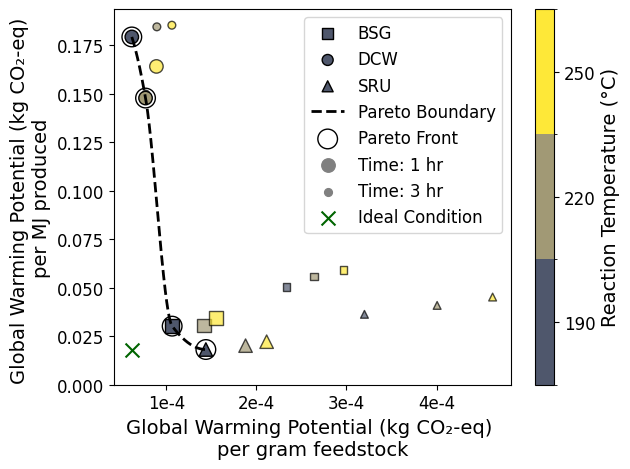

In [74]:
dcw_data = get_gwp_data('rawDCW_', ['Feedstock', 'Hydrochar HHV'])
bsg_data = get_gwp_data('stdBSG_', ['Feedstock', 'Hydrochar HHV'])
sru_data = get_gwp_data('stdSRU_', ['Feedstock', 'Hydrochar HHV'])
data = pd.concat([dcw_data, bsg_data, sru_data], ignore_index=True, sort=False)
pareto_front = get_pareto_front(data)

data[['Feedstock_Type', 'Temperature', 'Time']] = data['name'].str.extract(r'(\D+)(\d+C)_(\d+hr)')
data['Temperature'] = data['Temperature'].str.replace('C', '').astype(float)
data['Time'] = data['Time'].str.replace('hr', '').astype(float)
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('raw', '')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('std', '')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('_', '')

# Create a 2D scatter plot
fig, ax = plt.subplots()

# Define marker styles and colors for feedstocks
feedstock_markers = {'DCW': 'o', 'BSG': 's', 'SRU': '^'}

# Normalize temperature to a color map (for temperature gradients)
cmap = ListedColormap(plt.cm.cividis(np.linspace(0.3, 1, 3)))
temperature_norm = BoundaryNorm([175, 205, 235, 265], cmap.N)

# Plot data points with varying marker sizes for reaction time and color for temperature
for feedstock, group_data in data.groupby('Feedstock_Type'):
        # Check if any points in the group are on the Pareto front
    is_pareto = group_data[['Feedstock', 'Hydrochar HHV']].apply(lambda x: any(np.all(x == pareto_point) for pareto_point in pareto_front), axis=1)

    # Set alpha based on whether points are on the Pareto front
    # Full opacity for Pareto front, reduced for others
    alpha_value = np.where(is_pareto, 1, 0.7)  
    
    scatter = ax.scatter(group_data.iloc[:, 1], group_data.iloc[:, 2],
                         c=group_data['Temperature'], cmap=cmap, norm=temperature_norm,
                         marker=feedstock_markers[feedstock],
                         s= 75 / (group_data['Time']*0.8),  # Adjust marker size based on reaction time (multiplied for clarity)
                         edgecolor='black', label=feedstock, alpha=alpha_value)
    
# Sort Pareto front points for interpolation
sorted_pareto = pareto_front[np.argsort(pareto_front[:, 0])]

# Create spline for a smooth curve
x_pareto = sorted_pareto[:, 0]
y_pareto = sorted_pareto[:, 1]
# spline = make_interp_spline(x_pareto, y_pareto, k=3)  # k=3 for cubic spline
pchip = PchipInterpolator(x_pareto, y_pareto)

# Generate smooth points
x_smooth = np.linspace(x_pareto.min(), x_pareto.max(), 300)
# y_smooth = spline(x_smooth)
y_smooth = pchip(x_smooth)

# Plot the smooth dashed Pareto front curve
ax.plot(x_smooth, y_smooth, color='black', linestyle='--', linewidth=2, label='Pareto Boundary')
ax.scatter(pareto_front[:, 0], pareto_front[:, 1], color='none', label='Pareto Front', s=200, edgecolor='k')

# Add dummy scatter points for time legend
for time_value in data['Time'].unique():
    ax.scatter([], [], s=75/(time_value*0.8), color='gray', label=f'Time: {int(time_value)} hr')  # Gray markers for clarity

# Add colorbar to indicate temperature
cbar = plt.colorbar(scatter, ax=ax, ticks=[190,220,250])
cbar.set_label('Reaction Temperature (°C)', fontsize=14)

# Add legend and make it colorblind-friendly
ax.legend(title="Feedstock Type", loc='upper right')

# Adding ideal point to the plot
ideal_x = data['Feedstock'].min()
ideal_y = data['Hydrochar HHV'].min()
ax.scatter(ideal_x, ideal_y, color='darkgreen', marker='x', s=100, label='Ideal Condition', zorder=5)

# Labels and title
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.ylim(bottom=0)
plt.legend(prop={'size': 12})
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0e}'.replace('e-0', 'e-').replace('e+0', 'e+')))
ax.set_xlabel('Global Warming Potential (kg CO\u2082-eq) \nper gram feedstock', fontsize=14)
ax.set_ylabel('Global Warming Potential (kg CO\u2082-eq) \nper MJ produced', fontsize=14)



# ax.set_title(f'Climate Change Impacts Standardized to Hydrochar HHV & Feedstock')

# Ensure layout is tidy and readable
plt.tight_layout()

# Save figure
plt.savefig('figures/Figure 3.png')

# Show plot
plt.show()


In [75]:
data = pd.concat([dcw_data, bsg_data, sru_data], ignore_index=True, sort=False)
dominant, non_dominant = pareto_sort(data)
print(len(non_dominant))

14


In [76]:
dominant_data = pd.DataFrame(dominant, columns=['name', 'Feedstock', 'Hydrochar HHV'])

In [77]:
dominant_data

name  Feedstock  Hydrochar HHV
0   rawDCW_190C_1hr   0.000062       0.179219
2   rawDCW_220C_1hr   0.000077       0.147728
6   stdBSG_190C_1hr   0.000106       0.030186
12  stdSRU_190C_1hr   0.000144       0.018147

While multiple solutions are dominant as they lie on the Pareto front, we can determine the most optimal solution through utilizing a Multiple-Criteria Decision Making (MCDM) method, Technique for Order Preference by Similarity to Ideal Solution (TOPSIS). 

In [78]:
def topsis(df, criteria_cols):
    """
    Perform TOPSIS analysis on a dataset.

    Parameters:
    df (pd.DataFrame): The input data frame with at least one criteria column.
    criteria_cols (list of str): List of column names corresponding to criteria.

    Returns:
    pd.DataFrame: The input dataframe with an additional 'TOPSIS Score' column, sorted by score.
    """
    # Step 1: Normalize the decision matrix
    normalized_df = df[criteria_cols] / np.sqrt((df[criteria_cols] ** 2).sum())
    
    # Step 2: Calculate the weighted normalized decision matrix
    # Since all criteria have equal weight, we can skip the actual multiplication step. 

    # Step 3: Determine ideal and nadir solutions
    ideal_solution = normalized_df.min()
    nadir_solution = normalized_df.max()
    
    # Step 4: Calculate the distance to the ideal and nadir solutions
    distance_to_ideal = np.sqrt(((normalized_df - ideal_solution) ** 2).sum(axis=1))
    distance_to_nadir = np.sqrt(((normalized_df - nadir_solution) ** 2).sum(axis=1))
    
    # Step 5: Calculate the TOPSIS score
    topsis_score = distance_to_nadir / (distance_to_ideal + distance_to_nadir)
    
    # Add the score to the dataframe and sort by it
    df['TOPSIS Score'] = topsis_score
    df_sorted = df.sort_values(by='TOPSIS Score', ascending=False).reset_index(drop=True)
    
    return df_sorted

In [79]:
# Helper Function to Truncate Name
def truncate_name(name):
    truncated_name = re.sub(r'_sa_(lb|ub)', '', name)
    truncated_name = truncated_name.replace('hydrochar production, ', '')
    truncated_name = truncated_name.replace('raw', '')
    truncated_name = truncated_name.replace('std', '')
    truncated_name = truncated_name.replace('-1', ', 1')
    truncated_name = truncated_name.replace('-2', ', 2')
    truncated_name = truncated_name.replace('_', ', ')
    truncated_name = truncated_name.replace('0C', '0°C')
    return truncated_name

In [80]:
# Saving TOPSIS scores for all operating conditions to Excel file
path = 'results/TOPSIS-scores.xlsx'
with pd.ExcelWriter(path, engine='xlsxwriter') as writer:
    criteria_cols = ['Feedstock', 'Hydrochar HHV']
    df = pd.DataFrame(topsis(data, criteria_cols))
    df['name'] = df['name'].apply(truncate_name)
    df.to_excel(writer, sheet_name='Original Feedstocks', index=False)

In [81]:
# Computing TOPSIS scores for operating conditions on the Pareto front
criteria_cols = ['Feedstock', 'Hydrochar HHV']
data_sorted = topsis(dominant_data, criteria_cols)

In [82]:
data_sorted

name  Feedstock  Hydrochar HHV  TOPSIS Score
0  stdBSG_190C_1hr   0.000106       0.030186      0.745475
1  stdSRU_190C_1hr   0.000144       0.018147      0.629794
2  rawDCW_220C_1hr   0.000077       0.147728      0.389220
3  rawDCW_190C_1hr   0.000062       0.179219      0.370206

In [83]:
# Selecting the most favorable condition for each feedstock 
data_sorted[['Feedstock_Type', 'Temperature', 'Duration']] = data_sorted['name'].str.extract(r'(\D+)(\d+C)_(\d+hr)')
data_sorted = data_sorted.drop_duplicates(subset='Feedstock_Type', keep='first')

In [84]:
data_sorted

name  Feedstock  Hydrochar HHV  TOPSIS Score Feedstock_Type  \
0  stdBSG_190C_1hr   0.000106       0.030186      0.745475        stdBSG_   
1  stdSRU_190C_1hr   0.000144       0.018147      0.629794        stdSRU_   
2  rawDCW_220C_1hr   0.000077       0.147728      0.389220        rawDCW_   

  Temperature Duration  
0        190C      1hr  
1        190C      1hr  
2        220C      1hr

### 3.2: Composite Feedstock Analysis
From plotting the Pareto front of the elementary feedstocks, we see that some solutions are dominant and contribute to the Pareto front. Let's consider what changes when considering the four primary composite feedstocks across the two residences times (1 hour and 3 hour) and three reaction temperatures (190°C, 220°C, 250°C): 
1. Mix 1: rawSRU + rawDCW
2. Mix 2: rawSRU + rawBSG 
3. Mix 3: rawDCW + rawBSG 
4. Mix 4: rawDCW + rawSRU + rawBSG 

Composite mixtures are seen in Table 2 in <i>Developing Decision-Making Tools forFood Waste Management via Spatially Explicit Integration of Experimental Hydrothermal Carbonization Data and Computational Models Using New York as a Case Study</i> (Kassem et al. 2023)

In [85]:
from feedstock import create_composite_elementary_feedstocks

In [86]:
# Creating new feedstock manager & hydrochar activities for composite feedstocks  
composite_feedstocks = create_composite_elementary_feedstocks()

for attr, feedstocks in composite_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        create_hydrochar_activity(feedstock)


[{'name': 'feedstock_HTC_rawSRU50_rawDCW50_190C_1hr', 'amount': 7.416533766648233}, {'name': 'water_HTC_rawSRU50_rawDCW50_190C_1hr', 'amount': 4.25466155364479}, {'name': 'heat_HTC_rawSRU50_rawDCW50_190C_1hr', 'amount': 2.2932061855246473}, {'name': 'electricity_HTC_rawSRU50_rawDCW50_190C_1hr', 'amount': 0.07444006723179955}, {'name': 'co2_HTC_rawSRU50_rawDCW50_190C_1hr', 'amount': 0.038630574868220295}, {'name': 'wastewater_HTC_rawSRU50_rawDCW50_190C_1hr', 'amount': 10.632564745424803}, {'name': 'post_processing_HTC_rawSRU50_rawDCW50_190C_1hr', 'amount': 0.403}, {'name': 'transport_HTC_rawSRU50_rawDCW50_190C_1hr', 'amount': 0.00029839385295381835}]

[{'name': 'feedstock_HTC_rawSRU50_rawDCW50_190C_3hr', 'amount': 5.598429612088266}, {'name': 'water_HTC_rawSRU50_rawDCW50_190C_3hr', 'amount': 3.2116651768583817}, {'name': 'heat_HTC_rawSRU50_rawDCW50_190C_3hr', 'amount': 4.2516489142270455}, {'name': 'electricity_HTC_rawSRU50_rawDCW50_190C_3hr', 'amount': 0.15006604373220264}, {'name': 'c

In [87]:
# Computing LCIA Results for Climate Change across standardization categories 
process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']
scaling_factor = 0.001

for attr, feedstocks in composite_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        
        for act in [act for act in eidb if f"hydrochar production, {feedstock.name}_{feedstock.temp}C_{feedstock.time}hr" in act['name']]:
            
            activity_lcia = HTCLCIA(act['name']) 
            feedstock_lcia = HTCLCIA(act['name']) 
            hc_hhv_lcia = HTCLCIA(act['name']) 
            
            feedstock_standardization_factor = 1 / feedstock.quantity
            hc_hhv = get_parameter(activity['name'], 'HHV_HC')
            hc_hhv_standardization_factor = hc_hhv / 1000
                      
            method = [m for m in bw.methods if 'TRACI' in str(m) and 'global warming' in str(m)][0]
            impact_category = get_impact_category(method)
            method_key = method
            unit = bw.methods.get(method_key).get('unit')
            
            for i in range(len(process_categories)):
                process_catgeory = process_categories[i]
                exc = [exc for exc in act.exchanges()][i]
                    
                functional_amount = exc['amount'] * scaling_factor
                functional_unit = { exc.input: functional_amount}
                temp_lca = bw.LCA(functional_unit, method_key)
                
                if 'Carbon dioxide' in str(exc.input) and 'climate change' in str(method_key):
                    score = -1*functional_amount
                    activity_lcia.set_impact_score(impact_category, process_catgeory, score, unit)
                    
                # Will not ever execute as climate change is the only impact category of interest 
                elif 'Carbon dioxide' in str(exc.input):
                    score = 0 
                    activity_lcia.set_impact_score(impact_category, process_catgeory, score, unit)
                
                else:
                    temp_lca.lci()
                    temp_lca.lcia()
                    score = temp_lca.score
                    
                    activity_lcia.set_impact_score(impact_category, process_catgeory, score, unit)  
                    feedstock_lcia.set_impact_score(impact_category, process_catgeory, score * feedstock_standardization_factor, unit)
                    hc_hhv_lcia.set_impact_score(impact_category, process_catgeory, score / hc_hhv_standardization_factor, unit)
                    
                
        hydrochar_lcia_manager.add_lcia(activity_lcia)
        feedstock_lcia_manager.add_lcia(feedstock_lcia)
        hc_hhv_lcia_manager.add_lcia(hc_hhv_lcia)
        
        print(activity_lcia.name , "successfully calculated & added to LCIA Managers.")    

hydrochar production, rawSRU50_rawDCW50_190C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, rawSRU50_rawDCW50_190C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, rawSRU50_rawDCW50_220C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, rawSRU50_rawDCW50_220C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, rawSRU50_rawDCW50_250C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, rawSRU50_rawDCW50_250C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, rawSRU50_rawBSG50_190C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, rawSRU50_rawBSG50_190C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, rawSRU50_rawBSG50_220C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, rawSRU50_rawBSG50_220C_3hr successfully calculated & added to LCIA Managers.
hydrochar 

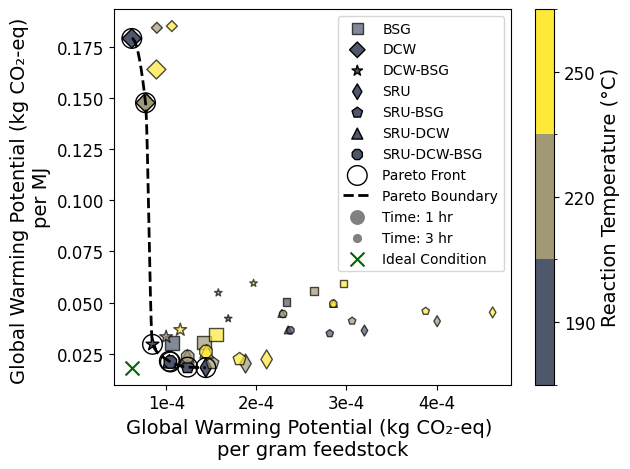

In [89]:
dcw_data = get_gwp_data('rawDCW_', ['Feedstock', 'Hydrochar HHV'])
bsg_data = get_gwp_data('stdBSG_', ['Feedstock', 'Hydrochar HHV'])
sru_data = get_gwp_data('stdSRU_', ['Feedstock', 'Hydrochar HHV'])
rawSRU50_rawDCW50 = get_gwp_data('rawSRU50_rawDCW50_', ['Feedstock', 'Hydrochar HHV'])
rawSRU50_rawBSG50 = get_gwp_data('rawSRU50_rawBSG50_', ['Feedstock', 'Hydrochar HHV'])
rawDCW50_rawBSG50 = get_gwp_data('rawDCW50_rawBSG50_', ['Feedstock', 'Hydrochar HHV'])
rawSRU33_rawDCW33_rawBSG33 = get_gwp_data('rawSRU33_rawDCW33_rawBSG33_', ['Feedstock', 'Hydrochar HHV'])
data = pd.concat([dcw_data, bsg_data, sru_data, rawSRU50_rawDCW50, rawSRU50_rawBSG50, rawDCW50_rawBSG50, rawSRU33_rawDCW33_rawBSG33], 
                 ignore_index=True, sort=False)

# Compute Pareto front
pareto_front = get_pareto_front(data)

data[['Feedstock_Type', 'Temperature', 'Time']] = data['name'].str.extract(r'([a-zA-Z0-9_]+)_(\d+C)_(\d+hr)')
data['Temperature'] = data['Temperature'].str.replace('C', '').astype(float)
data['Time'] = data['Time'].str.replace('hr', '').astype(float)
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('raw', '')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('std', '')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('_', '')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('_', '')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('50', '-')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('33', '-')
data['Feedstock_Type'] = data['Feedstock_Type'].str.rstrip('-')

# Create a 2D scatter plot
fig, ax = plt.subplots()

# Define marker styles for feedstocks
feedstock_markers = {'DCW': 'D', 'BSG': 's', 'SRU': 'd',
                     'SRU-DCW': '^','SRU-BSG': 'p', 'DCW-BSG': '*', 'SRU-DCW-BSG': '8'}

# Normalize temperature to a color map (for temperature gradients)
cmap = ListedColormap(plt.cm.cividis(np.linspace(0.3, 1, 3)))
temperature_norm = BoundaryNorm([175, 205, 235, 265], cmap.N)

# Plot data points with varying marker sizes for reaction time and color for temperature
for feedstock, group_data in data.groupby('Feedstock_Type'):
    # Check if any points in the group are on the Pareto front
    is_pareto = group_data[['Feedstock', 'Hydrochar HHV']].apply(lambda x: any(np.all(x == pareto_point) for pareto_point in pareto_front), axis=1)

    # Set alpha (opacity) based on whether points are on the Pareto front
    # Full opacity for Pareto front, reduced for others
    alpha_value = np.where(is_pareto, 1, 0.7)  
    
    scatter = ax.scatter(group_data.iloc[:, 1], group_data.iloc[:, 2],
                         c=group_data['Temperature'], cmap=cmap, norm=temperature_norm,
                         marker=feedstock_markers[feedstock],
                         s= 75 / (group_data['Time']*0.8),  # Adjust marker size based on reaction time (multiplied for clarity)
                         edgecolor='black', label=feedstock, alpha=alpha_value)

# Plot Pareto front (with distinct markers)
ax.scatter(pareto_front[:, 0], pareto_front[:, 1], color='none', label='Pareto Front', s=200, edgecolor='k')

# Sort Pareto front points for interpolation
sorted_pareto = pareto_front[np.argsort(pareto_front[:, 0])]

# Create spline for a smooth curve
x_pareto = sorted_pareto[:, 0]
y_pareto = sorted_pareto[:, 1]
# spline = make_interp_spline(x_pareto, y_pareto, k=3)  # k=3 for cubic spline
pchip = PchipInterpolator(x_pareto, y_pareto)

# Generate smooth points
x_smooth = np.linspace(x_pareto.min(), x_pareto.max(), 300)
y_smooth = spline(x_smooth)# spline = make_interp_spline(x_pareto, y_pareto, k=3)  # k=3 for cubic spline
# y_smooth = spline(x_smooth)
y_smooth = pchip(x_smooth)

# Plot the smooth dashed Pareto front curve
ax.plot(x_smooth, y_smooth, color='black', linestyle='--', linewidth=2, label='Pareto Boundary')

# Add dummy scatter points for time legend
for time_value in data['Time'].unique():
    ax.scatter([], [], s=75/(time_value*0.8), color='gray', label=f'Time: {int(time_value)} hr')  # Gray markers for clarity

# Add colorbar to indicate temperature
cbar = plt.colorbar(scatter, ax=ax, ticks=[190,220,250])
cbar.set_label('Reaction Temperature (°C)', fontsize=14)

# Add legend and make it colorblind-friendly
ax.legend(title="Feedstock Type", loc='upper right')

# Adding ideal point to the plot
ideal_x = data['Feedstock'].min()
ideal_y = data['Hydrochar HHV'].min()
ax.scatter(ideal_x, ideal_y, color='darkgreen', marker='x', s=100, label='Ideal Condition', zorder=5)


# Labels and title
ax.set_xlabel('Global Warming Potential (kg CO\u2082-eq) \nper gram feedstock', fontsize=14)
ax.set_ylabel('Global Warming Potential (kg CO\u2082-eq) \nper MJ', fontsize=14)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0e}'.replace('e-0', 'e-').replace('e+0', 'e+')))
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.legend(prop={'size': 10})

# Removing title for manuscript figure 
# ax.set_title(f'Climate Change Impacts Standardized to Hydrochar HHV & Feedstock')

# Ensure layout is tidy and readable
plt.tight_layout()

# Save plot
plt.savefig('figures/Figure 4.png')

# Show plot
plt.show()

In [90]:
data = pd.concat([dcw_data, bsg_data, sru_data, rawSRU50_rawDCW50, rawSRU50_rawBSG50, rawDCW50_rawBSG50, rawSRU33_rawDCW33_rawBSG33], 
                 ignore_index=True, sort=False)
dominant, non_dominant = pareto_sort(data)
dominant_data = pd.DataFrame(dominant, columns=['name', 'Feedstock', 'Hydrochar HHV'])

We can once again apply the Multiple-Criteria Decision Making (MCDM) method, Technique for Order Preference by Similarity to Ideal Solution (TOPSIS) to determine the most optimal solutions.  

In [91]:
dominant_data

name  Feedstock  Hydrochar HHV
0                       rawDCW_190C_1hr   0.000062       0.179219
2                       rawDCW_220C_1hr   0.000077       0.147728
12                      stdSRU_190C_1hr   0.000144       0.018147
18           rawSRU50_rawDCW50_190C_1hr   0.000103       0.021292
24           rawSRU50_rawBSG50_190C_1hr   0.000123       0.018397
30           rawDCW50_rawBSG50_190C_1hr   0.000084       0.029553
36  rawSRU33_rawDCW33_rawBSG33_190C_1hr   0.000104       0.020915

In [92]:
data = pd.concat([dcw_data, bsg_data, sru_data, rawSRU50_rawDCW50, rawSRU50_rawBSG50, rawDCW50_rawBSG50, rawSRU33_rawDCW33_rawBSG33], 
                 ignore_index=True, sort=False)
criteria_cols = ['Feedstock', 'Hydrochar HHV']
data_sorted = topsis(dominant_data, criteria_cols)

In [93]:
data_sorted

name  Feedstock  Hydrochar HHV  TOPSIS Score
0           rawDCW50_rawBSG50_190C_1hr   0.000084       0.029553      0.873021
1           rawSRU50_rawDCW50_190C_1hr   0.000103       0.021292      0.816188
2  rawSRU33_rawDCW33_rawBSG33_190C_1hr   0.000104       0.020915      0.812357
3           rawSRU50_rawBSG50_190C_1hr   0.000123       0.018397      0.749890
4                      stdSRU_190C_1hr   0.000144       0.018147      0.692056
5                      rawDCW_220C_1hr   0.000077       0.147728      0.337470
6                      rawDCW_190C_1hr   0.000062       0.179219      0.307944

In [94]:
# Redefining truncate_name helper function for composite feedstocks
def truncate_name(name):
    truncated_name = re.sub(r'_sa_(lb|ub)', '', name)
    truncated_name = truncated_name.replace('hydrochar production, ', '')
    truncated_name = truncated_name.replace('raw', '')
    truncated_name = truncated_name.replace('std', '')
    truncated_name = truncated_name.replace('50_', '-')
    truncated_name = truncated_name.replace('33_', '-')
    truncated_name = truncated_name.replace('-1', ', 1')
    truncated_name = truncated_name.replace('-2', ', 2')
    truncated_name = truncated_name.replace('_', ', ')
    truncated_name = truncated_name.replace('0C', '0°C')
    return truncated_name

In [95]:
# Exporting all points to Excel file 
path = 'results/TOPSIS-scores.xlsx'
with pd.ExcelWriter(path, engine='xlsxwriter') as writer:
    df = pd.DataFrame(topsis(data, criteria_cols))
    df['name'] = df['name'].apply(truncate_name)
    df.to_excel(writer, sheet_name='Composite + Original Feedstocks', index=False)

In [96]:
# Identifying most favorable reactor condition for each feedstock on Pareto front
data_sorted[['Feedstock_Type', 'Temperature', 'Duration']] = data_sorted['name'].str.extract(r'(.+?)_(\d+C)_(\d+hr)')
data_sorted = data_sorted.drop_duplicates(subset='Feedstock_Type', keep='first')

In [97]:
data_sorted

name  Feedstock  Hydrochar HHV  \
0           rawDCW50_rawBSG50_190C_1hr   0.000084       0.029553   
1           rawSRU50_rawDCW50_190C_1hr   0.000103       0.021292   
2  rawSRU33_rawDCW33_rawBSG33_190C_1hr   0.000104       0.020915   
3           rawSRU50_rawBSG50_190C_1hr   0.000123       0.018397   
4                      stdSRU_190C_1hr   0.000144       0.018147   
5                      rawDCW_220C_1hr   0.000077       0.147728   

   TOPSIS Score              Feedstock_Type Temperature Duration  
0      0.873021           rawDCW50_rawBSG50        190C      1hr  
1      0.816188           rawSRU50_rawDCW50        190C      1hr  
2      0.812357  rawSRU33_rawDCW33_rawBSG33        190C      1hr  
3      0.749890           rawSRU50_rawBSG50        190C      1hr  
4      0.692056                      stdSRU        190C      1hr  
5      0.337470                      rawDCW        220C      1hr

Standardization on a per hydrochar produced and energy basis (HC / HHV) do not exhibit significant tradeoffs. 

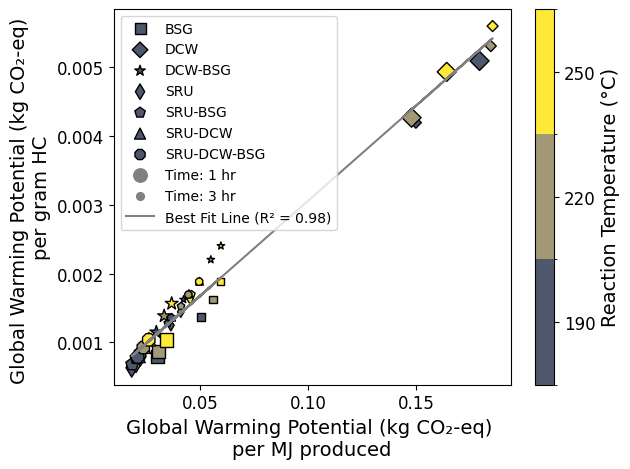

In [99]:
dcw_data = get_gwp_data('rawDCW_', ['Hydrochar', 'Hydrochar HHV'])
bsg_data = get_gwp_data('stdBSG_', ['Hydrochar', 'Hydrochar HHV'])
sru_data = get_gwp_data('stdSRU_', ['Hydrochar', 'Hydrochar HHV'])
rawSRU50_rawDCW50 = get_gwp_data('rawSRU50_rawDCW50_', ['Hydrochar', 'Hydrochar HHV'])
rawSRU50_rawBSG50 = get_gwp_data('rawSRU50_rawBSG50_', ['Hydrochar', 'Hydrochar HHV'])
rawDCW50_rawBSG50 = get_gwp_data('rawDCW50_rawBSG50_', ['Hydrochar', 'Hydrochar HHV'])
rawSRU33_rawDCW33_rawBSG33 = get_gwp_data('rawSRU33_rawDCW33_rawBSG33_', ['Hydrochar', 'Hydrochar HHV'])
data = pd.concat([dcw_data, bsg_data, sru_data, rawSRU50_rawDCW50, rawSRU50_rawBSG50, rawDCW50_rawBSG50, rawSRU33_rawDCW33_rawBSG33], 
                 ignore_index=True, sort=False)

# Compute Pareto front
pareto_front = get_pareto_front(data)

data[['Feedstock_Type', 'Temperature', 'Time']] = data['name'].str.extract(r'([a-zA-Z0-9_]+)_(\d+C)_(\d+hr)')
data['Temperature'] = data['Temperature'].str.replace('C', '').astype(float)
data['Time'] = data['Time'].str.replace('hr', '').astype(float)
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('raw', '')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('std', '')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('_', '')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('_', '')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('50', '-')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('33', '-')
data['Feedstock_Type'] = data['Feedstock_Type'].str.rstrip('-')

# Create a 2D scatter plot
fig, ax = plt.subplots()

# Define marker styles for feedstocks
feedstock_markers = {'DCW': 'D', 'BSG': 's', 'SRU': 'd',
                     'SRU-DCW': '^','SRU-BSG': 'p', 'DCW-BSG': '*', 'SRU-DCW-BSG': '8'}

# Normalize temperature to a color map (for temperature gradients)
cmap = ListedColormap(plt.cm.cividis(np.linspace(0.3, 1, 3)))
temperature_norm = BoundaryNorm([175, 205, 235, 265], cmap.N)

# Plot data points with varying marker sizes for reaction time and color for temperature
for feedstock, group_data in data.groupby('Feedstock_Type'):
    # Check if any points in the group are on the Pareto front
    is_pareto = group_data[['Hydrochar', 'Hydrochar HHV']].apply(lambda x: any(np.all(x == pareto_point) for pareto_point in pareto_front), axis=1)

    # Set alpha based on whether points are on the Pareto front
    alpha_value = np.where(is_pareto, 1, 1)  # Full opacity for Pareto front, reduced for others
    
    scatter = ax.scatter(group_data.iloc[:, 2], group_data.iloc[:, 1],
                         c=group_data['Temperature'], cmap=cmap, norm=temperature_norm,
                         marker=feedstock_markers[feedstock],
                         s= 75 / (group_data['Time']*0.8),  # Adjust marker size based on reaction time (multiplied for clarity)
                         edgecolor='black', label=feedstock, alpha=alpha_value)

# Add dummy scatter points for time legend
for time_value in data['Time'].unique():
    ax.scatter([], [], s=75/(time_value*0.8), color='gray', label=f'Time: {int(time_value)} hr')  # Gray markers for clarity

# Add colorbar to indicate temperature
cbar = plt.colorbar(scatter, ax=ax, ticks=[190,220,250])
cbar.set_label('Reaction Temperature (°C)', fontsize=14)

# Add legend and make it colorblind-friendly
ax.legend(title="Feedstock Type", loc='upper right')

coefficients = np.polyfit(data.iloc[:, 2], data.iloc[:, 1], 1)  # Linear regression
slope, intercept = coefficients
line_fit = slope * data.iloc[:, 2] + intercept

# Calculate R-squared
residuals = data.iloc[:, 1] - line_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((data.iloc[:, 1] - np.mean(data.iloc[:, 1]))**2)
r_squared = 1 - (ss_res / ss_tot)

# Plot the line of best fit
ax.plot(data.iloc[:, 2], line_fit, color='gray', label=f'Best Fit Line (R² = {r_squared:.2f})')

# Labels and title
ax.set_xlabel('Global Warming Potential (kg CO\u2082-eq) \nper MJ produced', fontsize=14)
ax.set_ylabel('Global Warming Potential (kg CO\u2082-eq) \nper gram HC', fontsize=14)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.legend(prop={'size': 10})

# Ensure layout is tidy and readable
plt.tight_layout()

# Save figure
plt.savefig('figures/Figure S3.png')

# Show plot
plt.show()

## 4: Uncertainty Analysis 
From the initial LCA baseline models, we can determine that our interpretations rely heavily upon our standardization technique. There are different decisions that can be made based on viewing HTC as a process for managing food waste (standardizing it to a quantity of food waste), a process for producing hydrochar (standardizing it to per quantity of hydrochar produced), or considering the application of hydrochar in a downstream process (in this case, combustion as a substitute for coal). 

From our multi-objective optimization, we see that there are no solutions that are dominant or more optimal than the other ones, when equally weighed. While these initial results are meaningful, it's important to determine if this holds true under uncertainty as <i>"all models are wrong, but some are useful." - George Box</i>

To ensure that this analysis is comprehensively done, sensitivity analyses and Monte Carlo analyses will be used for factoring in uncertainty within experimental & feedstock parameters and corresponding output conditions. As this LCA is done at lab-scale, uncertainties within the impact scores of exchange parameters are not factored into consideration. 

In [100]:
# Creating seed to ensure reproducibility
np.random.seed(1)

In [101]:
# Importing Additional Packages
from tqdm import tqdm
import multiprocessing as mp
from collections import defaultdict

### 4.1: Uncertainty Analysis: Moisture Content 
To determine the impact of moisture content on our results, we'll conduct an uncertainty analysis to determine the impacts of moisture on our impact assessment. 

In [102]:
# Add feedstocks to sensitivity analysis manager 
sa_feedstocks = FeedstockManager()

elementary_feedstocks = create_elementary_feedstocks()
excluded_feedstocks = {"rawSRU", "rawBSG"}

def create_sa_feedstocks(feedstock): 
    lb_feedstock = copy.deepcopy(feedstock)
    lb_feedstock.name = lb_feedstock.name + '_sa_lb'
    if lb_feedstock.moisture - (lb_feedstock.moisture_std / 100) < 0.504: 
        lb_feedstock.moisture = 0.504
    else: 
        lb_feedstock.moisture = lb_feedstock.moisture - (lb_feedstock.moisture_std / 100)
    lb_feedstock.moisture_std = 0
    
    ub_feedstock = copy.deepcopy(feedstock)
    ub_feedstock.name = ub_feedstock.name + '_sa_ub'
    if ub_feedstock.moisture + (ub_feedstock.moisture_std/100) > 0.95:
        ub_feedstock.moisture = 0.95
    else: 
        ub_feedstock.moisture = ub_feedstock.moisture + (ub_feedstock.moisture_std/100)
    ub_feedstock.moisture_std = 0
    
    return lb_feedstock, ub_feedstock
    

for attr, feedstocks in elementary_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        if feedstock.name not in excluded_feedstocks:            
            lb_feedstock, ub_feedstock = create_sa_feedstocks(feedstock)
            sa_feedstocks.add_feedstock(lb_feedstock)
            sa_feedstocks.add_feedstock(ub_feedstock)
            # sa_feedstocks.add_feedstock(feedstock)

composite_feedstocks = create_composite_elementary_feedstocks()
for attr, feedstocks in composite_feedstocks.__dict__.items():
    for feedstock in feedstocks:  
        lb_feedstock, ub_feedstock = create_sa_feedstocks(feedstock)
        sa_feedstocks.add_feedstock(lb_feedstock)
        sa_feedstocks.add_feedstock(ub_feedstock)
        # sa_feedstocks.add_feedstock(feedstock)

In [103]:
# # If needed, delete existing activities
# for act in [act for act in eidb if 'hydrochar production' in act['name']]:
#     act.delete()
    
# for act in [act for act in eidb if 'hydrochar production' in act['name']]:
#     print(act)

In [104]:
# Creating activities for sensitivity analysis 
for attr, feedstocks in sa_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        try:
            create_hydrochar_activity(feedstock)
        except: 
            print(f"Hydrochar activity: {feedstock.name}_{feedstock.temp}C_{feedstock.time}hr already exists. Continuing.")
            continue

[{'name': 'feedstock_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 4.187904741062433}, {'name': 'water_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 1.2665034499180747}, {'name': 'heat_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 1.7703282686958266}, {'name': 'electricity_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 0.0519272692860352}, {'name': 'co2_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 0.012816402776327064}, {'name': 'wastewater_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 4.441591788204181}, {'name': 'post_processing_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 0.403}, {'name': 'transport_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 0.00016849448419000953}]

[{'name': 'feedstock_HTC_stdSRU_sa_ub_190C_1hr', 'amount': 4.651776609726542}, {'name': 'water_HTC_stdSRU_sa_ub_190C_1hr', 'amount': 1.5626096040891988}, {'name': 'heat_HTC_stdSRU_sa_ub_190C_1hr', 'amount': 1.8387364536139585}, {'name': 'electricity_HTC_stdSRU_sa_ub_190C_1hr', 'amount': 0.05397052546400499}, {'name': 'co2_HTC_stdSRU_sa_ub_190C_1hr', 'amount': 0.01460214819558621

In [105]:
# Ensuring all HC activities are in database, should result in 126
print(len([act for act in eidb if 'hydrochar production' in act['name']]))

126


In [106]:
# Computing LCIA Results for Climate Change across standardization categories 
process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']
scaling_factor = 0.001

for attr, feedstocks in sa_feedstocks.__dict__.items():
    
        for feedstock in feedstocks:
            if str(feedstock.name).find('sa') != -1:
                for act in [act for act in eidb if f"hydrochar production, {feedstock.name}_{feedstock.temp}C_{feedstock.time}hr" in act['name']]:
                    activity_lcia = HTCLCIA(act['name']) 
                    feedstock_lcia = HTCLCIA(act['name']) 
                    hc_hhv_lcia = HTCLCIA(act['name']) 
                    
                    feedstock_standardization_factor = 1 / feedstock.quantity
                    hc_hhv = get_parameter(activity['name'], 'HHV_HC')
                    hc_hhv_standardization_factor = hc_hhv / 1000
                            
                    method = [m for m in bw.methods if 'TRACI' in str(m) and 'global warming' in str(m)][0]
                    impact_category = get_impact_category(method)
                    method_key = method
                    unit = bw.methods.get(method_key).get('unit')
                    
                    for i in range(len(process_categories)):
                        process_catgeory = process_categories[i]
                        exc = [exc for exc in act.exchanges()][i]
                            
                        functional_amount = exc['amount'] * scaling_factor
                        functional_unit = { exc.input: functional_amount}
                        temp_lca = bw.LCA(functional_unit, method_key)
                        
                        if 'Carbon dioxide' in str(exc.input) and 'climate change' in str(method_key):
                            score = -1*functional_amount
                            activity_lcia.set_impact_score(impact_category, process_catgeory, score, unit)
                            
                        # Will not ever execute as climate change is the only 
                        elif 'Carbon dioxide' in str(exc.input):
                            score = 0 
                            activity_lcia.set_impact_score(impact_category, process_catgeory, score, unit)
                        
                        else:
                            temp_lca.lci()
                            temp_lca.lcia()
                            score = temp_lca.score
                            
                            activity_lcia.set_impact_score(impact_category, process_catgeory, score, unit)  
                            feedstock_lcia.set_impact_score(impact_category, process_catgeory, score * feedstock_standardization_factor, unit)
                            hc_hhv_lcia.set_impact_score(impact_category, process_catgeory, score / hc_hhv_standardization_factor, unit)
                        
                    
                hydrochar_lcia_manager.add_lcia(activity_lcia)
                feedstock_lcia_manager.add_lcia(feedstock_lcia)
                hc_hhv_lcia_manager.add_lcia(hc_hhv_lcia)
                
                print(activity_lcia.name , "successfully calculated & added to LCIA Managers.")    

hydrochar production, stdSRU_sa_lb_190C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_ub_190C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_lb_190C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_ub_190C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_lb_220C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_ub_220C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_lb_220C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_ub_220C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_lb_250C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_ub_250C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_lb_250C_3hr successfully cal

In [107]:
def create_summary_table(lcia_list, standardization_factor):
    # Grouping global warming potentials by truncated names
    grouped_data = defaultdict(list)

    for item in lcia_list:
        truncated_name = truncate_name(item.name)
        # Standardize the total impact score if a factor is provided
        impact_score = item.get_total_impact_score('climate_change')
        grouped_data[truncated_name].append(impact_score)

    # Calculate mean and standard deviation for each group
    summary_data = {
        "Feedstock & Operating Conditions": [],
        f"Mean Impact per {standardization_factor}": [],
        "Standard Deviation": [], 
        "Coefficient of Variation (%)" : []
    }

    for name, standardized_scores in grouped_data.items():
        summary_data["Feedstock & Operating Conditions"].append(name)
        summary_data[f"Mean Impact per {standardization_factor}"].append(np.mean(standardized_scores))
        summary_data["Standard Deviation"].append(np.std(standardized_scores))
        summary_data["Coefficient of Variation (%)"].append(100*np.std(standardized_scores)/np.mean(standardized_scores))

    # Convert to pandas DataFrame for tabular format
    summary_table = pd.DataFrame(summary_data)

    # Sort table by mean impact score
    # summary_table = summary_table.sort_values(by=f"Mean Impact per {standardization_factor}", ascending=False)
    summary_table = summary_table.sort_values(by=f"Coefficient of Variation (%)", ascending=False)

    return summary_table

In [108]:
def plot_variability_heatmap(data, value_column): 
    """
    Creates a heatmap that demonstrates variability across feedstocks and operating conditions.

    Parameters:
        data (pd.DataFrame): The input dataset containing feedstock, operating conditions, value column, and standard deviation.
        value_column (str): The column name for the values to be plotted (e.g., "Mean Impact per gram hydrochar / HHV").
        units (str): The units for the values (e.g., (kg CO\u2082-eq / MJ))
    """
    data[['Feedstock', 'Operating Conditions']] = data['Feedstock & Operating Conditions'].str.split(', ', n=1, expand=True)

    # Reorganize x-axis order with line breaks
    condition_order = [
        "190°C\n1hr", "190°C\n3hr", "220°C\n1hr", "220°C\n3hr", "250°C\n1hr", "250°C\n3hr"
    ]
    feedstock_order = [
        'BSG', 'DCW', 'SRU', 'DCW-BSG', 'SRU-DCW', 'SRU-BSG', 'SRU-DCW-BSG' 
    ]
    data['Operating Conditions'] = data['Operating Conditions'].str.replace(", ", "\n")
    data['Operating Conditions'] = pd.Categorical(data['Operating Conditions'], ordered=True, categories=condition_order)
    data['Feedstock'] = pd.Categorical(data['Feedstock'], ordered=True, categories=feedstock_order)
    
    # Create a pivot table for the heatmap
    heatmap_data = data.pivot_table(
        index='Feedstock', columns='Operating Conditions', values=value_column
    )

    # Set up the heatmap figure
    plt.figure(figsize=(10, 6))
    sns.set_theme(style="whitegrid")
    heatmap = sns.heatmap(
        heatmap_data, annot=True, fmt=".2f", cmap="Reds",
        cbar_kws={'label': f"{value_column}"}
    )

    # Customize the plot
    # heatmap.set_title("Variability Across Feedstocks and Operating Conditions", fontsize=16, pad=20)
    heatmap.set_xlabel("Operating Conditions", fontsize=14)
    heatmap.set_ylabel("Feedstock", fontsize=14)
    plt.xticks(ha='center', fontsize=12)
    plt.yticks(fontsize=12)

    # Adjust layout for better fit
    plt.tight_layout()

    # Show the plot
    plt.show()

In [109]:
def plot_facet_grid_stacked_bars(data, value_column, units):
    """
    Create a reorganized FacetGrid of stacked bar plots with error bars for varying feedstocks and operating conditions.

    Parameters:
        data (pd.DataFrame): The input dataset containing feedstock, operating conditions, value column, and standard deviation.
        value_column (str): The column name for the values to be plotted (e.g., "Mean Impact per gram hydrochar / HHV").
        units (str): The units for the values (e.g., (kg CO\u2082-eq / MJ))
    """
    
    # Split "Feedstock & Operating Conditions" into separate columns
    data[['Feedstock', 'Operating Conditions']] = data['Feedstock & Operating Conditions'].str.split(', ', n=1, expand=True)

    # Reorganize x-axis order with line breaks
    condition_order = [
        "190°C\n1hr", "190°C\n3hr", "220°C\n1hr", "220°C\n3hr", "250°C\n1hr", "250°C\n3hr"
    ]
    data['Operating Conditions'] = data['Operating Conditions'].str.replace(", ", "\n")
    data['Operating Conditions'] = pd.Categorical(data['Operating Conditions'], ordered=True, categories=condition_order)

    # Rearrange feedstocks to specify row assignment
    first_row = ['BSG', 'DCW', 'SRU']
    second_row = ['DCW-BSG', 'SRU-BSG', 'SRU-DCW', 'SRU-DCW-BSG']
    feedstocks = first_row + second_row

    # Set up grid layout: 1st row (3 plots) and 2nd row (4 plots)
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(22, 12))
    axes = axes.flatten()

    # Plot each feedstock in its corresponding subplot
    for idx, feedstock in enumerate(feedstocks):
        ax = axes[idx]
        subset = data[data['Feedstock'] == feedstock]

        # Initialize cumulative bottoms for stacking
        bottoms = np.zeros(len(condition_order))

        for _, row in subset.iterrows():
            condition_idx = condition_order.index(row["Operating Conditions"])
            ax.bar(
                x=row["Operating Conditions"],
                height=row[value_column],
                bottom=bottoms[condition_idx],
                yerr=row["Standard Deviation"],
                capsize=4,
                color='lightblue'
            )
            bottoms[condition_idx] += row[value_column]

        # Add title for each grid
        ax.set_title(feedstock, fontsize=14)
        ax.tick_params(axis='x', rotation=0)
        # ax.get_yaxis().set_visible(False)  # Remove individual y-axis
        # ax.get_xaxis().set_visible(False)  # Remove individual x-axis

    # Hide unused subplots
    for idx in range(len(feedstocks), len(axes)):
        axes[idx].set_visible(False)

    # Add shared x and y axis labels
    fig.text(0.5, 0.04, "Operating Conditions", ha='center', fontsize=16)
    if value_column == "Mean Impact per gram hydrochar":
        fig.text(0.05, 0.5, f'{value_column} {units}', va='center', rotation='vertical', fontsize=16)
    else: 
        fig.text(0.06, 0.5, f'{value_column} {units}', va='center', rotation='vertical', fontsize=16)
    # Adjust padding to avoid overlap
    plt.tight_layout(pad=2.0)
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.95)

    # Add a main title
    # fig.suptitle("FacetGrid of Stacked Bar Plots with Error Bars", fontsize=18)
    plt.show()

#### 4.1.1: Energy Basis: Moisture Content 

In [110]:
hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
create_summary_table(hc_hhv_lcia_list, 'gram hydrochar / HHV')

Feedstock & Operating Conditions  Mean Impact per gram hydrochar / HHV  \
3                   BSG, 190°C, 1hr                              0.024123   
16                  BSG, 220°C, 1hr                              0.025057   
17                  BSG, 190°C, 3hr                              0.041162   
14                  DCW, 190°C, 3hr                              0.125779   
15                  BSG, 250°C, 1hr                              0.028869   
2                   DCW, 220°C, 3hr                              0.156226   
0                   BSG, 220°C, 3hr                              0.047279   
13                  DCW, 220°C, 1hr                              0.125493   
9                   DCW, 190°C, 1hr                              0.153038   
10                  DCW, 250°C, 1hr                              0.141856   
5                   DCW, 250°C, 3hr                              0.161123   
1                   BSG, 250°C, 3hr                              0.052690   
8                   SRU, 220°C, 1hr                              0.019237   
12                  SRU, 190°C, 3hr                              0.034899   
4                   SRU, 190°C, 1hr                              0.017555   
6                   SRU, 250°C, 1hr                              0.021562   
18              SRU-DCW, 190°C, 1hr                              0.021314   
20              SRU-DCW, 220°C, 1hr                              0.023786   
11                  SRU, 220°C, 3hr                              0.039802   
22              SRU-DCW, 250°C, 1hr                              0.026174   
36          SRU-DCW-BSG, 190°C, 1hr                              0.020923   
38          SRU-DCW-BSG, 220°C, 1hr                              0.023520   
40          SRU-DCW-BSG, 250°C, 1hr                              0.026046   
21              SRU-DCW, 220°C, 3hr                              0.044689   
23              SRU-DCW, 250°C, 3hr                              0.049587   
24              SRU-BSG, 190°C, 1hr                              0.018402   
26              SRU-BSG, 220°C, 1hr                              0.020373   
19              SRU-DCW, 190°C, 3hr                              0.036648   
28              SRU-BSG, 250°C, 1hr                              0.022297   
7                   SRU, 250°C, 3hr                              0.044823   
30              DCW-BSG, 190°C, 1hr                              0.029556   
32              DCW-BSG, 220°C, 1hr                              0.033182   
34              DCW-BSG, 250°C, 1hr                              0.036656   
39          SRU-DCW-BSG, 220°C, 3hr                              0.044413   
41          SRU-DCW-BSG, 250°C, 3hr                              0.049409   
37          SRU-DCW-BSG, 190°C, 3hr                              0.036412   
33              DCW-BSG, 220°C, 3hr                              0.054796   
27              SRU-BSG, 220°C, 3hr                              0.040987   
35              DCW-BSG, 250°C, 3hr                              0.059464   
25              SRU-BSG, 190°C, 3hr                              0.034865   
29              SRU-BSG, 250°C, 3hr                              0.045785   
31              DCW-BSG, 190°C, 3hr                              0.042167   

    Standard Deviation  Coefficient of Variation (%)  
3             0.004289                     17.779552  
16            0.003878                     15.476049  
17            0.006366                     15.465733  
14            0.016947                     13.473407  
15            0.003830                     13.267170  
2             0.019958                     12.774975  
0             0.006014                     12.719965  
13            0.015741                     12.543190  
9             0.018528                     12.106792  
10            0.015712                     11.075813  
5             0.017099                     10.612107  
1             0.004652         

In [111]:
# Exporting results to Excel file
path = 'results/Uncertainty_Analysis.xlsx'
with pd.ExcelWriter(path, engine='xlsxwriter') as writer:
    df = create_summary_table(hc_hhv_lcia_list, 'gram hydrochar / HHV')
    df.to_excel(writer, sheet_name='Mositure Content - HC_HHV', index=False)

/tmp/ipykernel_3247438/3980777023.py:24: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = data.pivot_table(


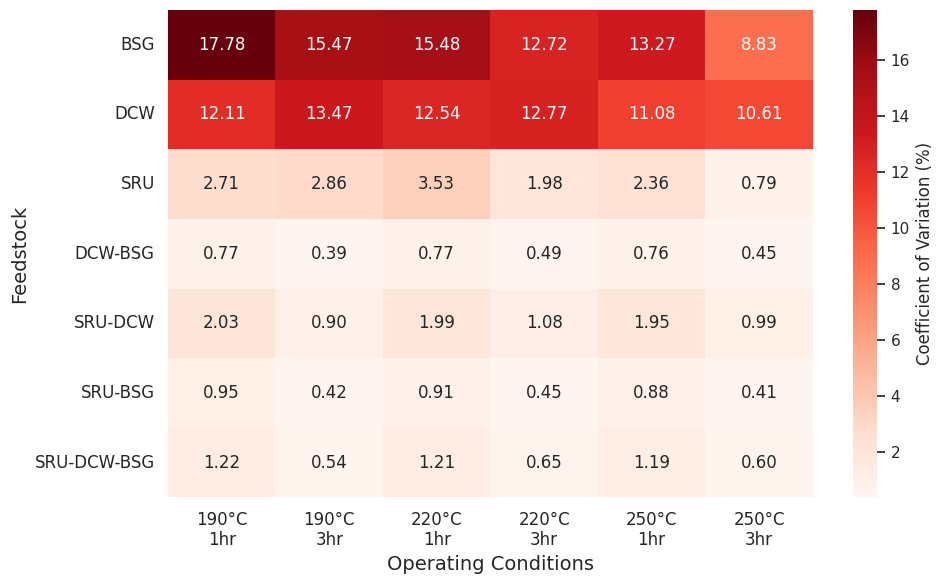

<Figure size 640x480 with 0 Axes>

In [112]:
hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(hc_hhv_lcia_list, 'gram hydrochar / HHV')
# plot_variability_heatmap(plotting_data, "Coefficient of Variation (%)")
fig = plot_variability_heatmap(plotting_data, "Coefficient of Variation (%)")
plt.savefig("figures/Figure S6.png")

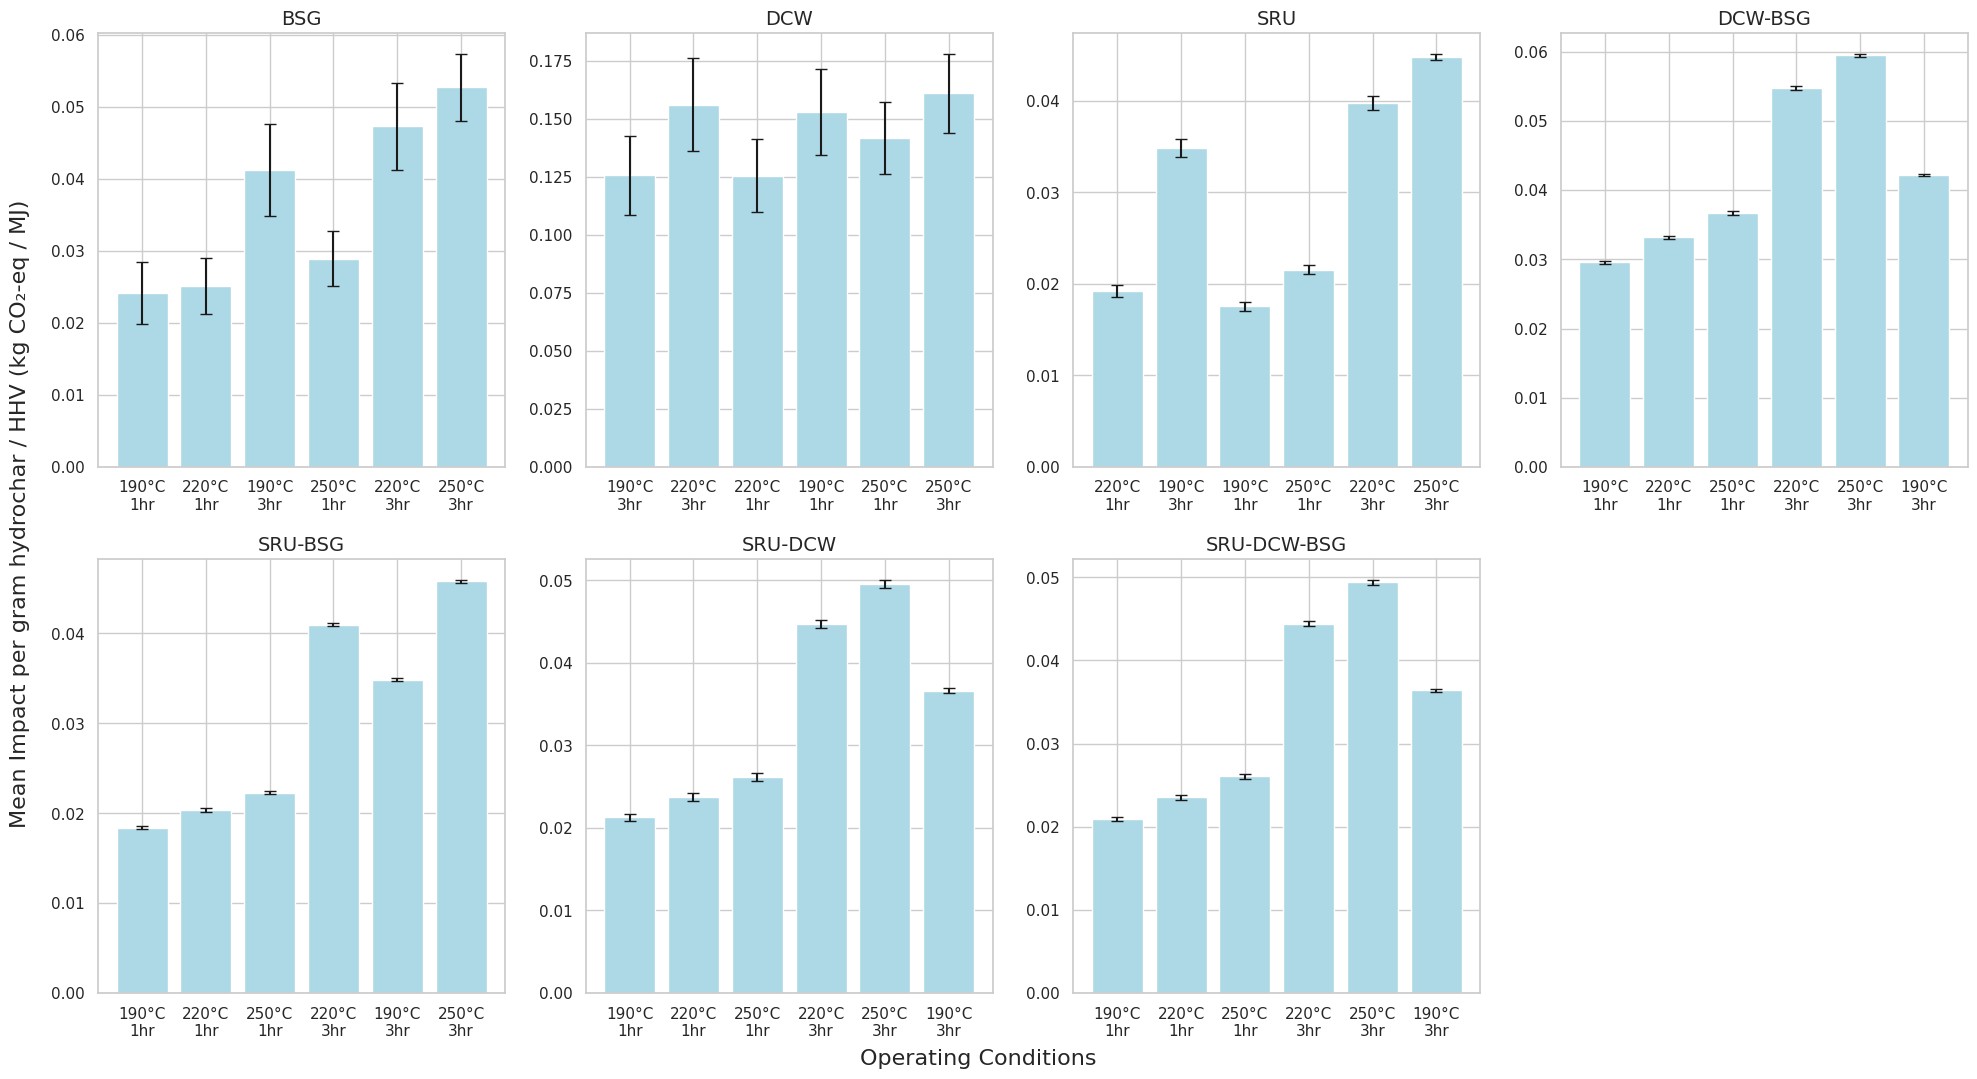

In [113]:
hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(hc_hhv_lcia_list, 'gram hydrochar / HHV')
plot_facet_grid_stacked_bars(plotting_data, "Mean Impact per gram hydrochar / HHV", '(kg CO\u2082-eq / MJ)')

#### 4.1.2: Feedstock Basis: Moisture Content 

In [114]:
# Exporting results to Excel file
feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
create_summary_table(feedstock_lcia_list, 'gram feedstock')

Feedstock & Operating Conditions  Mean Impact per gram feedstock  \
15                  BSG, 250°C, 1hr                        0.000145   
16                  BSG, 220°C, 1hr                        0.000134   
11                  SRU, 220°C, 3hr                        0.000394   
7                   SRU, 250°C, 3hr                        0.000456   
12                  SRU, 190°C, 3hr                        0.000317   
6                   SRU, 250°C, 1hr                        0.000205   
8                   SRU, 220°C, 1hr                        0.000183   
4                   SRU, 190°C, 1hr                        0.000142   
19              SRU-DCW, 190°C, 3hr                        0.000235   
1                   BSG, 250°C, 3hr                        0.000285   
23              SRU-DCW, 250°C, 3hr                        0.000286   
21              SRU-DCW, 220°C, 3hr                        0.000228   
0                   BSG, 220°C, 3hr                        0.000255   
10                  DCW, 250°C, 1hr                        0.000086   
5                   DCW, 250°C, 3hr                        0.000103   
3                   BSG, 190°C, 1hr                        0.000103   
29              SRU-BSG, 250°C, 3hr                        0.000388   
25              SRU-BSG, 190°C, 3hr                        0.000281   
27              SRU-BSG, 220°C, 3hr                        0.000306   
2                   DCW, 220°C, 3hr                        0.000087   
13                  DCW, 220°C, 1hr                        0.000075   
22              SRU-DCW, 250°C, 1hr                        0.000145   
37          SRU-DCW-BSG, 190°C, 3hr                        0.000238   
20              SRU-DCW, 220°C, 1hr                        0.000123   
18              SRU-DCW, 190°C, 1hr                        0.000103   
17                  BSG, 190°C, 3hr                        0.000228   
41          SRU-DCW-BSG, 250°C, 3hr                        0.000285   
39          SRU-DCW-BSG, 220°C, 3hr                        0.000230   
28              SRU-BSG, 250°C, 1hr                        0.000181   
26              SRU-BSG, 220°C, 1hr                        0.000151   
24              SRU-BSG, 190°C, 1hr                        0.000123   
14                  DCW, 190°C, 3hr                        0.000076   
40          SRU-DCW-BSG, 250°C, 1hr                        0.000144   
38          SRU-DCW-BSG, 220°C, 1hr                        0.000124   
36          SRU-DCW-BSG, 190°C, 1hr                        0.000104   
9                   DCW, 190°C, 1hr                        0.000061   
31              DCW-BSG, 190°C, 3hr                        0.000169   
35              DCW-BSG, 250°C, 3hr                        0.000197   
33              DCW-BSG, 220°C, 3hr                        0.000158   
34              DCW-BSG, 250°C, 1hr                        0.000115   
32              DCW-BSG, 220°C, 1hr                        0.000100   
30              DCW-BSG, 190°C, 1hr                        0.000084   

    Standard Deviation  Coefficient of Variation (%)  
15        6.759447e-06                      4.648130  
16        5.207608e-06                      3.873216  
11        1.525592e-05                      3.868736  
7         1.745785e-05                      3.826657  
12        1.187939e-05                      3.753014  
6         7.518048e-06                      3.663083  
8         6.471681e-06                      3.531254  
4         4.438956e-06                      3.132856  
19        7.089029e-06                      3.013630  
1         8.396644e-06                      2.944399  
23        8.341033e-06                      2.919298  
21        6.457406e-06                      2.829348  
0         6.399107e-06                      2.505733  
10        2.106676e-06                      2.448752  
5         2.371666e-06                      2.304269  
3         2.364057e-06                      2.293220  
29        8.62

In [115]:
# Exporting results to Excel file
path = 'results/Uncertainty_Analysis.xlsx'
with pd.ExcelWriter(path, engine='xlsxwriter') as writer:
    df = create_summary_table(feedstock_lcia_list, 'gram feedstock')
    df.to_excel(writer, sheet_name='Moisture Content - Feedstock', index=False)

/tmp/ipykernel_3247438/3980777023.py:24: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = data.pivot_table(


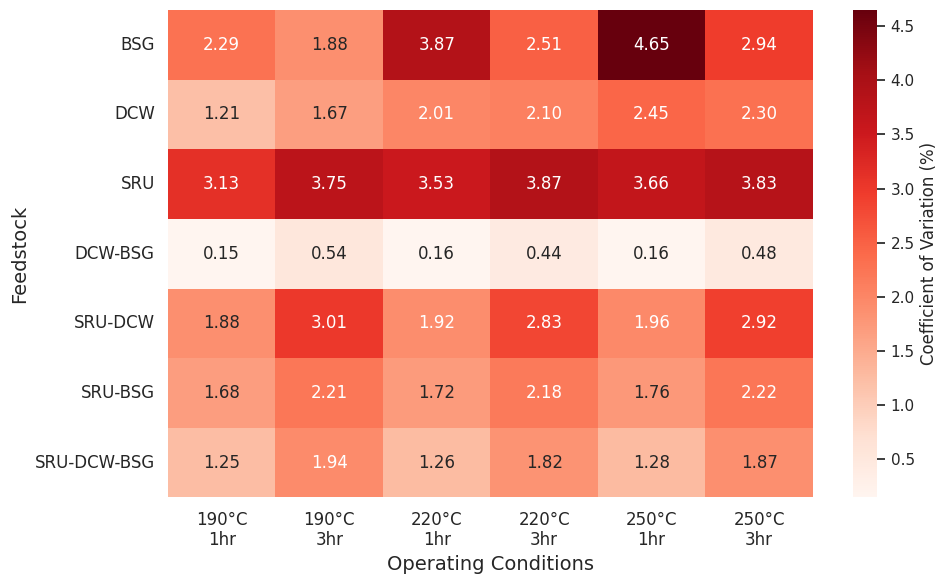

<Figure size 640x480 with 0 Axes>

In [116]:
feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(feedstock_lcia_list, 'gram feedstock')
# plot_variability_heatmap(plotting_data, "Coefficient of Variation (%)")
fig = plot_variability_heatmap(plotting_data, "Coefficient of Variation (%)")
plt.savefig("figures/Figure S7.png")

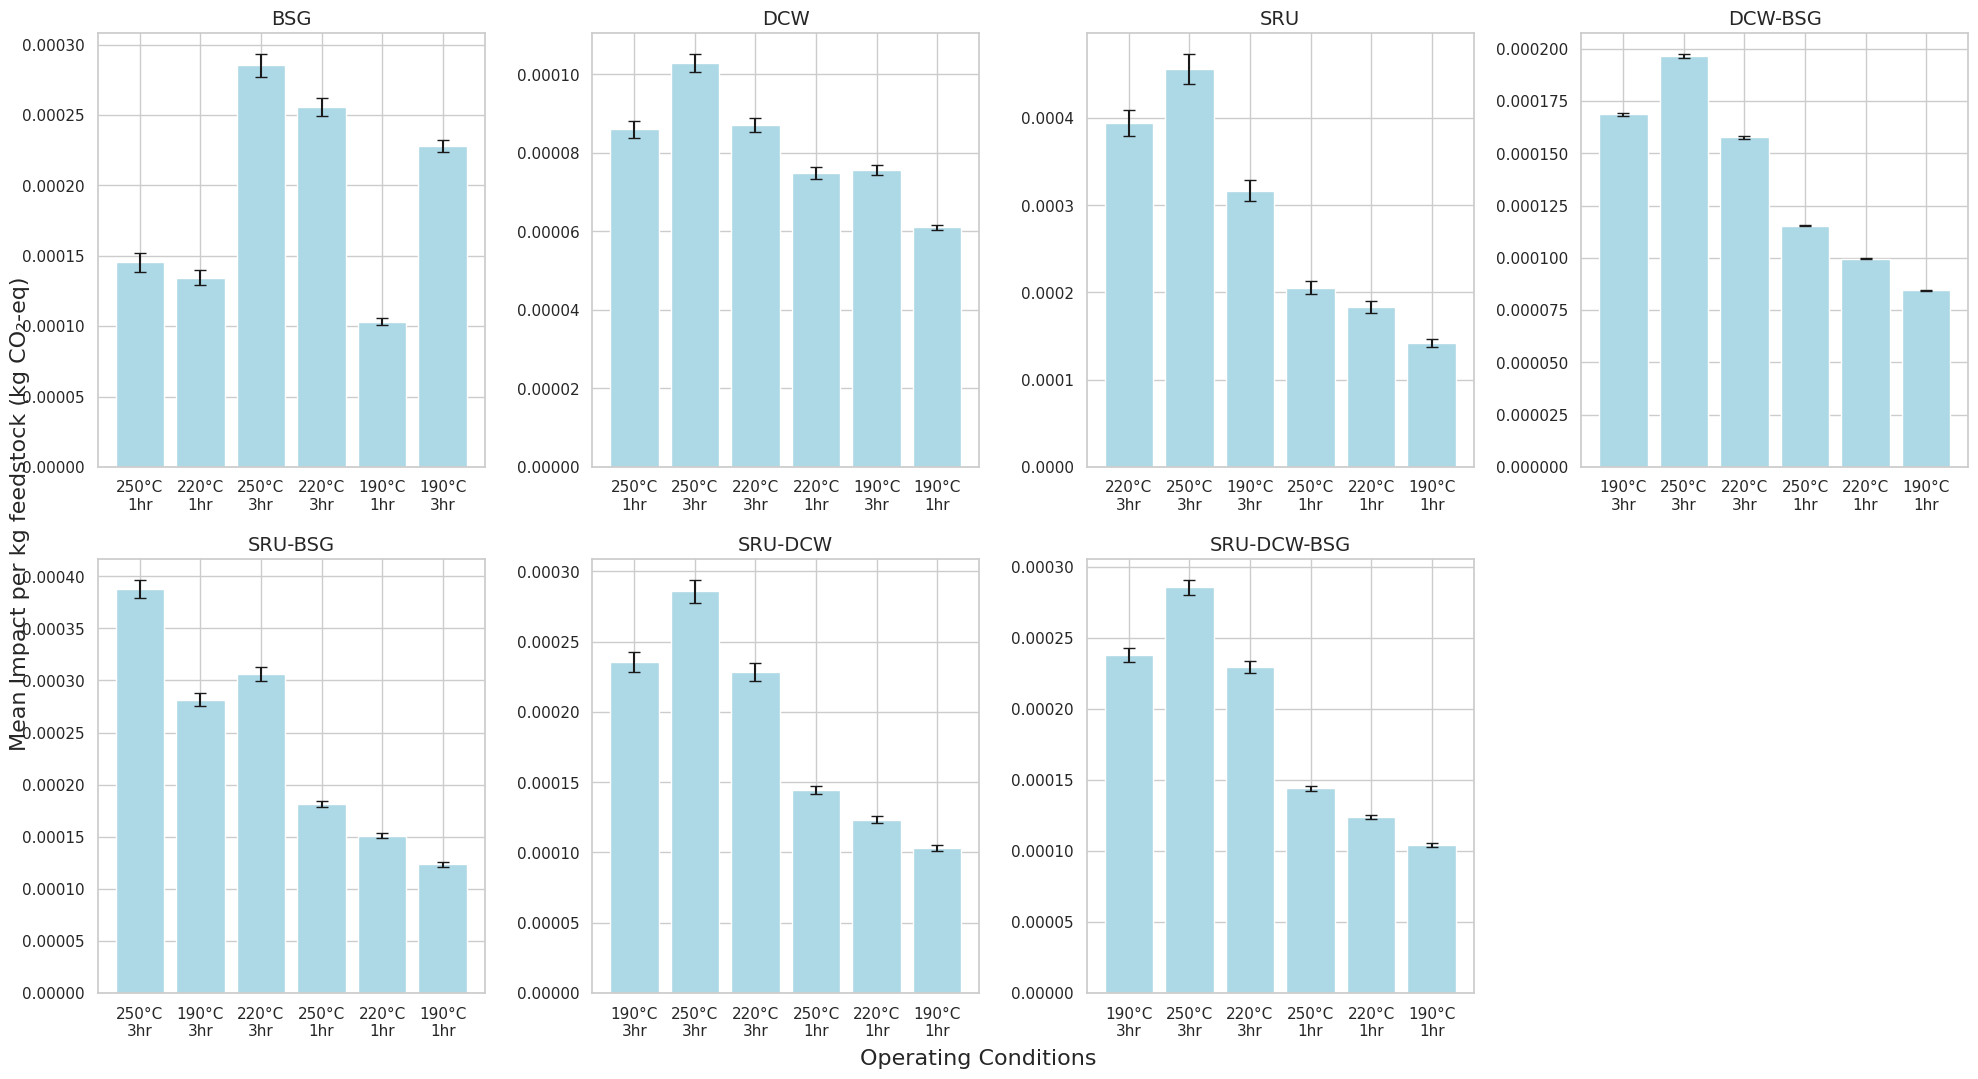

In [117]:
feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(feedstock_lcia_list, 'kg feedstock')
plot_facet_grid_stacked_bars(plotting_data, "Mean Impact per kg feedstock", '(kg CO\u2082-eq)')

#### 4.1.3: Hydrochar Basis: Moisture Content 

In [118]:
hydrochar_lcia_list = [hc for attr, lcia in hydrochar_lcia_manager.__dict__.items() for hc in lcia]
create_summary_table(hydrochar_lcia_list, 'gram hydrochar')

Feedstock & Operating Conditions  Mean Impact per gram hydrochar  \
22              SRU-DCW, 250°C, 1hr                        0.001049   
20              SRU-DCW, 220°C, 1hr                        0.000939   
18              SRU-DCW, 190°C, 1hr                        0.000805   
10                  DCW, 250°C, 1hr                        0.005044   
5                   DCW, 250°C, 3hr                        0.005712   
2                   DCW, 220°C, 3hr                        0.005414   
13                  DCW, 220°C, 1hr                        0.004355   
14                  DCW, 190°C, 3hr                        0.004266   
6                   SRU, 250°C, 1hr                        0.000798   
40          SRU-DCW-BSG, 250°C, 1hr                        0.001039   
4                   SRU, 190°C, 1hr                        0.000634   
38          SRU-DCW-BSG, 220°C, 1hr                        0.000926   
8                   SRU, 220°C, 1hr                        0.000701   
21              SRU-DCW, 220°C, 3hr                        0.001712   
36          SRU-DCW-BSG, 190°C, 1hr                        0.000789   
23              SRU-DCW, 250°C, 3hr                        0.001891   
9                   DCW, 190°C, 1hr                        0.005171   
19              SRU-DCW, 190°C, 3hr                        0.001368   
26              SRU-BSG, 220°C, 1hr                        0.000775   
24              SRU-BSG, 190°C, 1hr                        0.000682   
28              SRU-BSG, 250°C, 1hr                        0.000852   
34              DCW-BSG, 250°C, 1hr                        0.001566   
32              DCW-BSG, 220°C, 1hr                        0.001385   
30              DCW-BSG, 190°C, 1hr                        0.001149   
39          SRU-DCW-BSG, 220°C, 3hr                        0.001695   
41          SRU-DCW-BSG, 250°C, 3hr                        0.001884   
11                  SRU, 220°C, 3hr                        0.001445   
12                  SRU, 190°C, 3hr                        0.001249   
7                   SRU, 250°C, 3hr                        0.001636   
37          SRU-DCW-BSG, 190°C, 3hr                        0.001357   
33              DCW-BSG, 220°C, 3hr                        0.002204   
15                  BSG, 250°C, 1hr                        0.001036   
27              SRU-BSG, 220°C, 3hr                        0.001526   
35              DCW-BSG, 250°C, 3hr                        0.002404   
3                   BSG, 190°C, 1hr                        0.000795   
16                  BSG, 220°C, 1hr                        0.000869   
29              SRU-BSG, 250°C, 3hr                        0.001700   
25              SRU-BSG, 190°C, 3hr                        0.001282   
31              DCW-BSG, 190°C, 3hr                        0.001624   
1                   BSG, 250°C, 3hr                        0.001885   
0                   BSG, 220°C, 3hr                        0.001626   
17                  BSG, 190°C, 3hr                        0.001366   

    Standard Deviation  Coefficient of Variation (%)  
22            0.000024                      2.299903  
20            0.000022                      2.295132  
18            0.000018                      2.193344  
10            0.000102                      2.027041  
5             0.000106                      1.853225  
2             0.000097                      1.789584  
13            0.000078                      1.779815  
14            0.000062                      1.456691  
6             0.000011                      1.409163  
40            0.000015                      1.406077  
4             0.000009                      1.400322  
38            0.000013                      1.395594  
8             0.000009                      1.350484  
21            0.000023                      1.342078  
36            0.000010                      1.322738  
23            0.000023                      1.240426  
9             

In [119]:
# Exporting results to Excel file
path = 'results/Uncertainty_Analysis.xlsx'
with pd.ExcelWriter(path, engine='xlsxwriter') as writer:
    df = create_summary_table(hydrochar_lcia_list , 'gram hydrochar')
    df.to_excel(writer, sheet_name='Moisture Content - HC', index=False)

/tmp/ipykernel_3247438/3980777023.py:24: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = data.pivot_table(


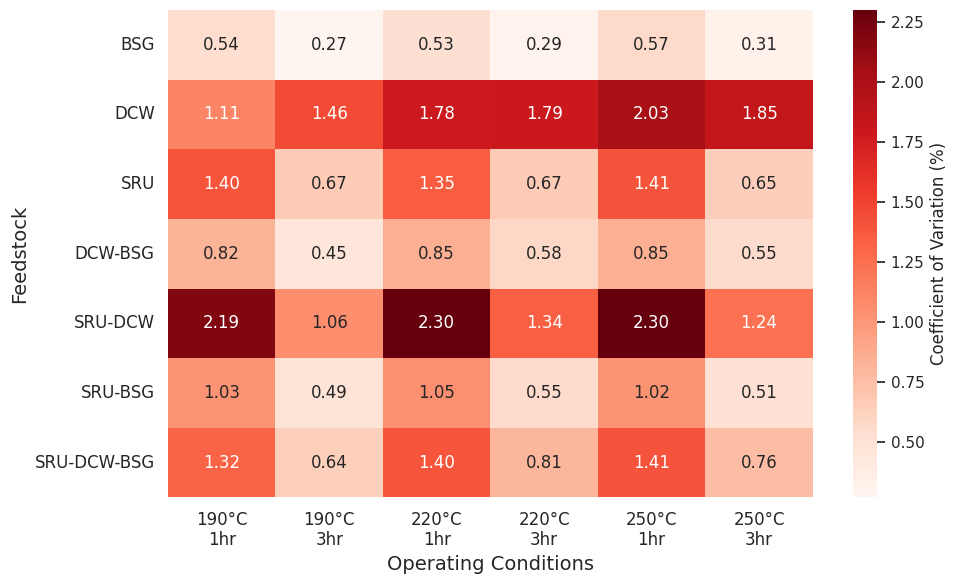

<Figure size 640x480 with 0 Axes>

In [120]:
hydrochar_lcia_list = [hc for attr, lcia in hydrochar_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(hydrochar_lcia_list , 'gram hydrochar')
# plot_variability_heatmap(plotting_data, "Coefficient of Variation (%)")
fig = plot_variability_heatmap(plotting_data, "Coefficient of Variation (%)")
plt.savefig("figures/Figure S8.png")

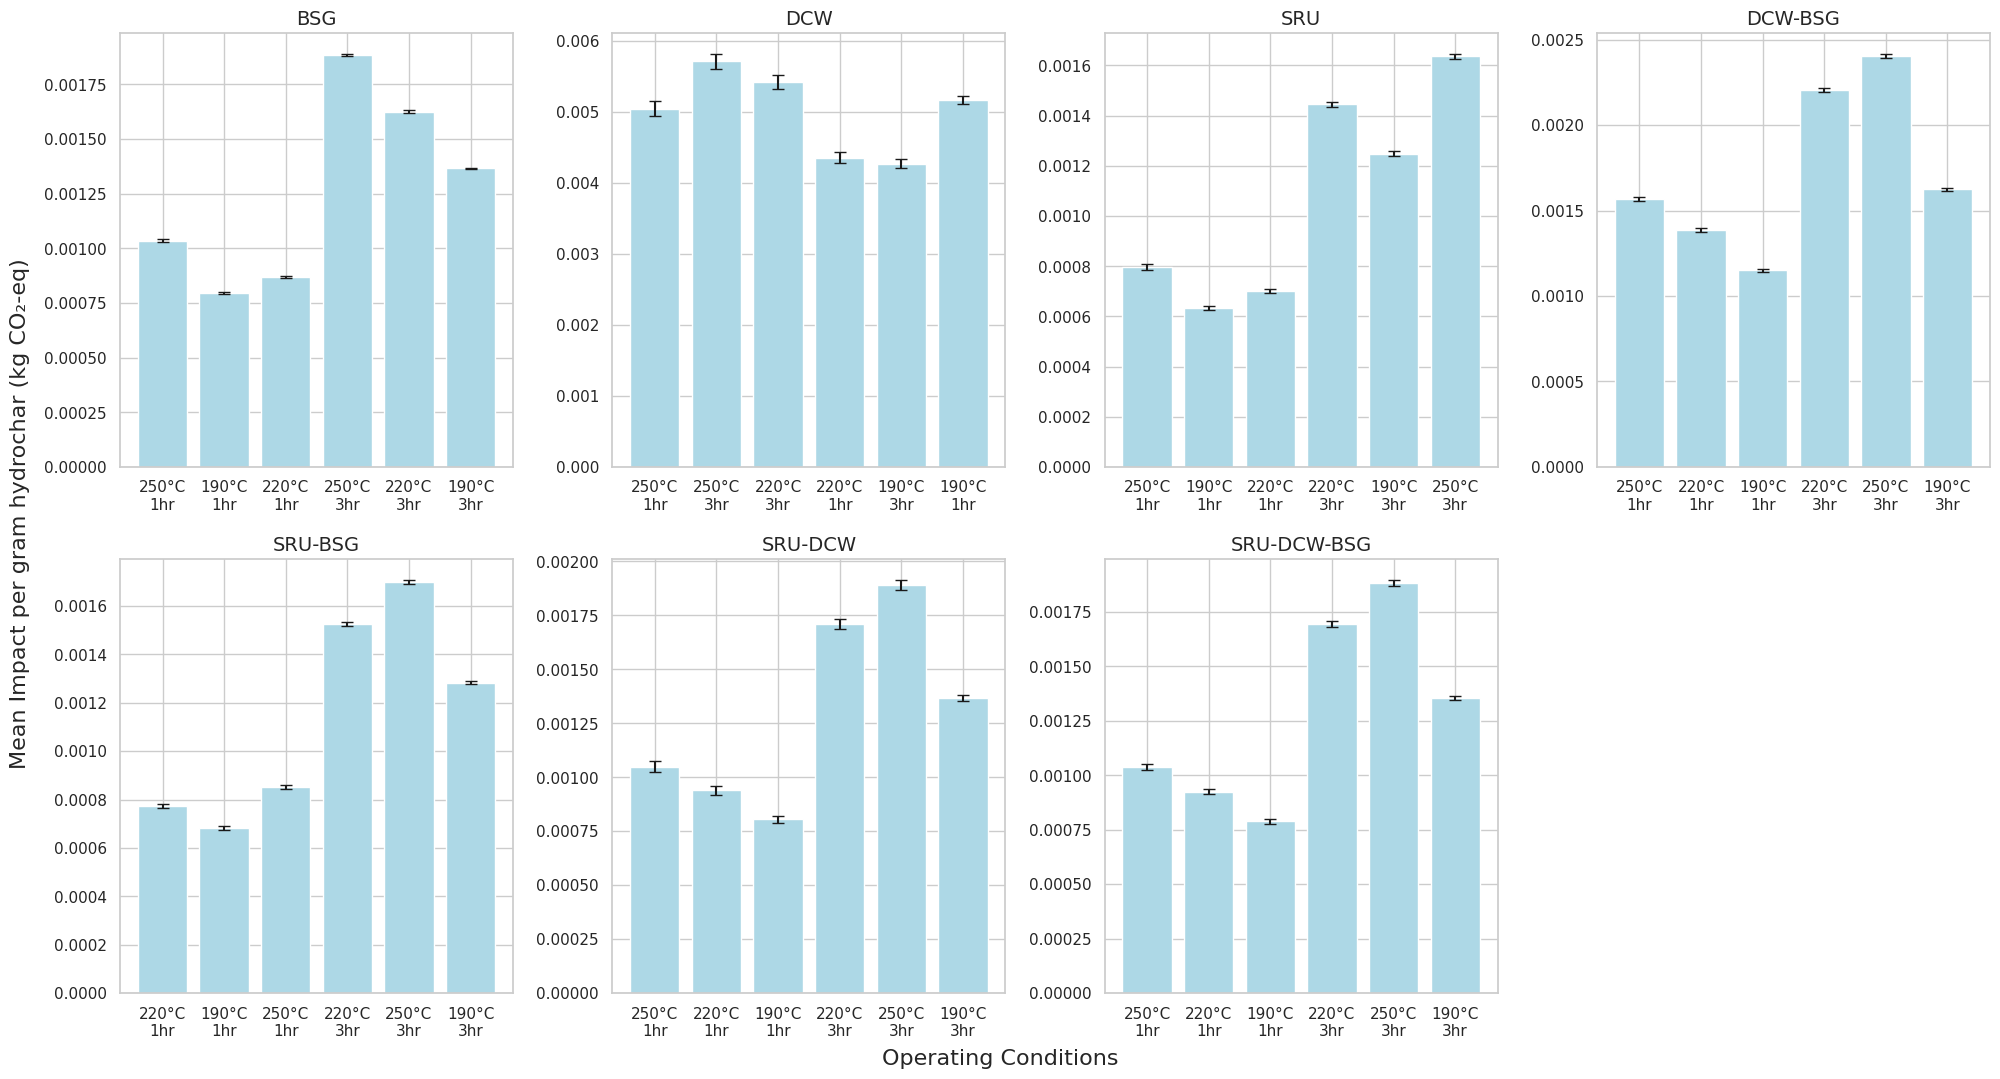

In [121]:
hydrochar_lcia_list = [hc for attr, lcia in hydrochar_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(hydrochar_lcia_list, 'gram hydrochar')
plot_facet_grid_stacked_bars(plotting_data, "Mean Impact per gram hydrochar", '(kg CO\u2082-eq)')

### 4.2: Uncertainty Analysis: Hydrochar Yield 
To determine the impact of hydrochar yield on our results, we'll conduct an uncertainty analysis to determine the impacts of yield on our interpretation across standardization categories. 

In [122]:
# Delete existing SA Activities 
for act in [act for act in eidb if 'hydrochar production' in act['name'] and '_sa_' in act['name']]:
    act.delete()
    
for act in [act for act in eidb if 'hydrochar production' in act['name']]:
    print(act)

'hydrochar production, rawSRU50_rawBSG50_190C_1hr' (kg, US, None)
'hydrochar production, rawSRU50_rawDCW50_220C_3hr' (kg, US, None)
'hydrochar production, rawSRU33_rawDCW33_rawBSG33_250C_3hr' (kg, US, None)
'hydrochar production, stdBSG_250C_3hr' (kg, US, None)
'hydrochar production, stdBSG_220C_1hr' (kg, US, None)
'hydrochar production, stdBSG_220C_3hr' (kg, US, None)
'hydrochar production, rawDCW_220C_1hr' (kg, US, None)
'hydrochar production, rawSRU50_rawBSG50_250C_3hr' (kg, US, None)
'hydrochar production, rawSRU50_rawDCW50_190C_3hr' (kg, US, None)
'hydrochar production, rawDCW50_rawBSG50_220C_3hr' (kg, US, None)
'hydrochar production, rawDCW_190C_3hr' (kg, US, None)
'hydrochar production, rawDCW50_rawBSG50_220C_1hr' (kg, US, None)
'hydrochar production, rawSRU33_rawDCW33_rawBSG33_250C_1hr' (kg, US, None)
'hydrochar production, stdSRU_190C_3hr' (kg, US, None)
'hydrochar production, rawSRU33_rawDCW33_rawBSG33_220C_1hr' (kg, US, None)
'hydrochar production, rawSRU50_rawDCW50_190C_1hr

In [123]:
# Delete existing SA Activities from LCIA Managers 
hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
for item in hc_hhv_lcia_list: 
    if item.name.find('sa') != -1: 
        hc_hhv_lcia_manager.delete_lcia(item.name)

feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
for item in feedstock_lcia_list: 
    if item.name.find('sa') != -1: 
        feedstock_lcia_manager.delete_lcia(item.name)

hydrochar_lcia_list = [hc for attr, lcia in hydrochar_lcia_manager.__dict__.items() for hc in lcia]
for item in hydrochar_lcia_list: 
    if item.name.find('sa') != -1: 
        hydrochar_lcia_manager.delete_lcia(item.name)

In [124]:
def create_hydrochar_activity_hc_sa(feedstock: Feedstock, err_estimate: str):
    '''
    Creates a hydrochar activity, given a feedstock
    Parameters:
        feedstock (Feedstock): Feedstock object
        err_estimate (str): Estimate for hydrochar yield. Either ub to reflect upper bound or lb to reflect lower bound.   
    '''
    temp = feedstock.temp
    time = feedstock.time 
    hydrochar_production = eidb.new_activity(
        code=f'HTC_{feedstock.name}_{temp}C_{time}hr',
        name=f"hydrochar production, {feedstock.name}_{temp}C_{time}hr",
        location='US',
        unit="kg"
    )
    parameters = ParameterManager()
    if err_estimate == 'lb':
        yield_HC = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'HC_yield') * (1-0.025)
    elif err_estimate == 'ub': 
        yield_HC = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'HC_yield') * (1+0.025)
    else: 
        yield_HC = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'HC_yield')
    
    gas_yield = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'gas_yield')
    project_data = [
        {
            'name': 'feedstock_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_feedstock_quantity(yield_HC, feedstock)
        }, 
        {
            'name': 'water_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_water_quantity(yield_HC, feedstock)
        }, 
        {
            'name': 'heat_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_heat_needed(feedstock, temp, time)
        },
        {
            'name': 'electricity_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_electricity_needed(feedstock, time, temp)
        }, 
        {
            'name': 'co2_' + f'HTC_{feedstock.name}_{temp}C_{time}hr',
            'amount': get_co2_emissions(yield_HC, gas_yield, feedstock)
        }, 
        {
            'name': 'wastewater_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_pw(yield_HC, gas_yield, feedstock, hc_placeholder=1)
        },
        {
            'name': 'post_processing_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_post_processing(hc_placeholder=1)
        },
        {
            'name': 'transport_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_transportation_quantity(feedstock)
        }
    ]
    
    print(project_data)
    parameters.new_project_parameters(project_data)
    
    # for param in ProjectParameter.select():
    #     print(param, param.amount)
    
    # Feedstock 
    hydrochar_production.new_exchange(input=('biosphere3', 'feedstock'), amount=0, unit="kg", type='custom', formula= 'feedstock')
    hydrochar_production.save()
                        
    # Water 
    water = [act for act in eidb if 'market for water, completely softened' in act['name']  and 'US' in act['location']][0]
    hydrochar_production.new_exchange(input=water.key, amount=0, unit="kilogram", type='technosphere', 
                                        formula= 'water_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    # Electricity
    electricity = [act for act in eidb if 'market for electricity, low voltage' in act['name']  and 'US-NPCC' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='electricity_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    # Heat 
    electricity = [act for act in eidb if 'market for electricity, low voltage' in act['name']  and 'US-NPCC' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='heat_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    # CO2 Emissions
    co2 = [flow for flow in biosphere3 if 'carbon dioxide, non-fossil, resource correction' in flow['name'].lower()][1]
    hydrochar_production.new_exchange(input=co2.key, amount=0, unit="kilogram", type='biosphere', 
                                        formula='-1*co2_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    # Wastewater 
    wastewater = [act for act in eidb if 'treatment of wastewater, average, wastewater treatment' in act['name']  and 'RoW' in act['location']][0]
    hydrochar_production.new_exchange(input=wastewater.key, amount=0, unit="cubic meter", type='technosphere', 
                                        formula='-1*wastewater_' + f'HTC_{feedstock.name}_{temp}C_{time}hr/1000').save()
    hydrochar_production.save()
    
    # Post-Processing
    electricity = [act for act in eidb if 'market for electricity, low voltage' in act['name']  and 'US-NPCC' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='post_processing_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    # Transportation 
    transport = [act for act in eidb if 'transport, freight, lorry, all sizes, EURO6' in act['name']  and 'RoW' in act['location']][0]
    hydrochar_production.new_exchange(input=transport.key, amount=0, unit="ton kilometer", type='technosphere', 
                                        formula='transport_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    parameters.add_exchanges_to_group(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", hydrochar_production)
    ActivityParameter.recalculate_exchanges(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr")
    print()        

In [125]:
# Add feedstocks to sensitivity analysis manager 
sa_feedstocks = FeedstockManager()

elementary_feedstocks = create_elementary_feedstocks()
excluded_feedstocks = {"rawSRU", "rawBSG"}

def create_sa_feedstocks(feedstock): 
    lb_feedstock = copy.deepcopy(feedstock)
    lb_feedstock.name = lb_feedstock.name + '_sa_lb'
    
    ub_feedstock = copy.deepcopy(feedstock)
    ub_feedstock.name = ub_feedstock.name + '_sa_ub'
    
    return lb_feedstock, ub_feedstock
    

for attr, feedstocks in elementary_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        if feedstock.name not in excluded_feedstocks:            
            lb_feedstock, ub_feedstock = create_sa_feedstocks(feedstock)
            sa_feedstocks.add_feedstock(lb_feedstock)
            sa_feedstocks.add_feedstock(ub_feedstock)
            # sa_feedstocks.add_feedstock(feedstock)

composite_feedstocks = create_composite_elementary_feedstocks()
for attr, feedstocks in composite_feedstocks.__dict__.items():
    for feedstock in feedstocks:  
        lb_feedstock, ub_feedstock = create_sa_feedstocks(feedstock)
        sa_feedstocks.add_feedstock(lb_feedstock)
        sa_feedstocks.add_feedstock(ub_feedstock)
        # sa_feedstocks.add_feedstock(feedstock)

In [126]:
for attr, feedstocks in sa_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        try:
            if feedstock.name.find('lb') == -1: 
                create_hydrochar_activity_hc_sa(feedstock, 'lb')
            if feedstock.name.find('ub') == -1: 
                create_hydrochar_activity_hc_sa(feedstock, 'ub')
            else:
                raise ValueError(f"A feedstock without sensitivity analysis bound was computed.")
        except: 
            print(f"Hydrochar activity: {feedstock.name}_{feedstock.temp}C_{feedstock.time}hr already exists. Continuing.")
            continue

[{'name': 'feedstock_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 4.297706710299925}, {'name': 'water_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 1.367131224148841}, {'name': 'heat_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 1.7856695612543314}, {'name': 'electricity_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 0.0524790412175677}, {'name': 'co2_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 0.013310856483122992}, {'name': 'wastewater_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 4.651527077965643}, {'name': 'post_processing_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 0.403}, {'name': 'transport_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 0.0001729122126995231}]

[{'name': 'feedstock_HTC_stdSRU_sa_ub_190C_1hr', 'amount': 4.518101926212741}, {'name': 'water_HTC_stdSRU_sa_ub_190C_1hr', 'amount': 1.437240517694935}, {'name': 'heat_HTC_stdSRU_sa_ub_190C_1hr', 'amount': 1.8196683887567022}, {'name': 'electricity_HTC_stdSRU_sa_ub_190C_1hr', 'amount': 0.05330393475893037}, {'name': 'co2_HTC_stdSRU_sa_ub_190C_1hr', 'amount': 0.013993464507898528},

In [127]:
# Ensuring all HC activities are in database, should result in 126
print(len([act for act in eidb if 'hydrochar production' in act['name']]))

126


In [128]:
# Computing LCIA Results for Climate Change across standardization categories 
process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']
scaling_factor = 0.001

for attr, feedstocks in sa_feedstocks.__dict__.items():
    
        for feedstock in feedstocks:
            if str(feedstock.name).find('sa') != -1:
                for act in [act for act in eidb if f"hydrochar production, {feedstock.name}_{feedstock.temp}C_{feedstock.time}hr" in act['name']]:
                    activity_lcia = HTCLCIA(act['name']) 
                    feedstock_lcia = HTCLCIA(act['name']) 
                    hc_hhv_lcia = HTCLCIA(act['name']) 
                    
                    feedstock_standardization_factor = 1 / feedstock.quantity
                    hc_hhv = get_parameter(activity['name'], 'HHV_HC')
                    hc_hhv_standardization_factor = hc_hhv / 1000
                            
                    method = [m for m in bw.methods if 'TRACI' in str(m) and 'global warming' in str(m)][0]
                    impact_category = get_impact_category(method)
                    method_key = method
                    unit = bw.methods.get(method_key).get('unit')
                    
                    for i in range(len(process_categories)):
                        process_catgeory = process_categories[i]
                        exc = [exc for exc in act.exchanges()][i]
                            
                        functional_amount = exc['amount'] * scaling_factor
                        functional_unit = { exc.input: functional_amount}
                        temp_lca = bw.LCA(functional_unit, method_key)
                        
                        if 'Carbon dioxide' in str(exc.input) and 'climate change' in str(method_key):
                            score = -1*functional_amount
                            activity_lcia.set_impact_score(impact_category, process_catgeory, score, unit)
                            
                        # Will not ever execute as climate change is the only 
                        elif 'Carbon dioxide' in str(exc.input):
                            score = 0 
                            activity_lcia.set_impact_score(impact_category, process_catgeory, score, unit)
                        
                        else:
                            temp_lca.lci()
                            temp_lca.lcia()
                            score = temp_lca.score
                            
                            activity_lcia.set_impact_score(impact_category, process_catgeory, score, unit)  
                            # feedstock_lcia.set_impact_score(impact_category, process_catgeory, score * feedstock_standardization_factor * 1000, unit)
                            feedstock_lcia.set_impact_score(impact_category, process_catgeory, score * feedstock_standardization_factor, unit)
                            hc_hhv_lcia.set_impact_score(impact_category, process_catgeory, score / hc_hhv_standardization_factor, unit)
                        
                    
                hydrochar_lcia_manager.add_lcia(activity_lcia)
                feedstock_lcia_manager.add_lcia(feedstock_lcia)
                hc_hhv_lcia_manager.add_lcia(hc_hhv_lcia)
                
                print(activity_lcia.name , "successfully calculated & added to LCIA Managers.")    

hydrochar production, stdSRU_sa_lb_190C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_ub_190C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_lb_190C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_ub_190C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_lb_220C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_ub_220C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_lb_220C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_ub_220C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_lb_250C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_ub_250C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_lb_250C_3hr successfully cal

#### 4.2.1: Energy Basis: HC Yield 

In [129]:
hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
create_summary_table(hc_hhv_lcia_list, 'gram hydrochar / HHV')

Feedstock & Operating Conditions  Mean Impact per gram hydrochar / HHV  \
3                   BSG, 190°C, 1hr                              0.024125   
16                  BSG, 220°C, 1hr                              0.025059   
17                  BSG, 190°C, 3hr                              0.041164   
14                  DCW, 190°C, 3hr                              0.125114   
15                  BSG, 250°C, 1hr                              0.028872   
2                   DCW, 220°C, 3hr                              0.155524   
13                  DCW, 220°C, 1hr                              0.124836   
9                   DCW, 190°C, 1hr                              0.152027   
0                   BSG, 220°C, 3hr                              0.047281   
10                  DCW, 250°C, 1hr                              0.141231   
5                   DCW, 250°C, 3hr                              0.160528   
1                   BSG, 250°C, 3hr                              0.052693   
8                   SRU, 220°C, 1hr                              0.019227   
12                  SRU, 190°C, 3hr                              0.034890   
4                   SRU, 190°C, 1hr                              0.017545   
6                   SRU, 250°C, 1hr                              0.021550   
11                  SRU, 220°C, 3hr                              0.039792   
30              DCW-BSG, 190°C, 1hr                              0.029560   
32              DCW-BSG, 220°C, 1hr                              0.033187   
34              DCW-BSG, 250°C, 1hr                              0.036662   
18              SRU-DCW, 190°C, 1hr                              0.021296   
20              SRU-DCW, 220°C, 1hr                              0.023766   
36          SRU-DCW-BSG, 190°C, 1hr                              0.020919   
38          SRU-DCW-BSG, 220°C, 1hr                              0.023516   
22              SRU-DCW, 250°C, 1hr                              0.026153   
40          SRU-DCW-BSG, 250°C, 1hr                              0.026041   
33              DCW-BSG, 220°C, 3hr                              0.054801   
24              SRU-BSG, 190°C, 1hr                              0.018399   
35              DCW-BSG, 250°C, 3hr                              0.059469   
26              SRU-BSG, 220°C, 1hr                              0.020370   
28              SRU-BSG, 250°C, 1hr                              0.022294   
7                   SRU, 250°C, 3hr                              0.044812   
31              DCW-BSG, 190°C, 3hr                              0.042170   
21              SRU-DCW, 220°C, 3hr                              0.044669   
39          SRU-DCW-BSG, 220°C, 3hr                              0.044408   
23              SRU-DCW, 250°C, 3hr                              0.049567   
41          SRU-DCW-BSG, 250°C, 3hr                              0.049404   
19              SRU-DCW, 190°C, 3hr                              0.036634   
37          SRU-DCW-BSG, 190°C, 3hr                              0.036409   
27              SRU-BSG, 220°C, 3hr                              0.040985   
25              SRU-BSG, 190°C, 3hr                              0.034863   
29              SRU-BSG, 250°C, 3hr                              0.045782   

    Standard Deviation  Coefficient of Variation (%)  
3             0.004290                     17.782308  
16            0.003879                     15.479600  
17            0.006366                     15.464505  
14            0.017492                     13.980842  
15            0.003833                     13.274811  
2             0.020554                     13.215934  
13            0.016315                     13.069378  
9             0.019401                     12.761283  
0             0.006014                     12.719754  
10            0.016289                     11.533903  
5             0.017632                     10.983991  
1             0.004653         

In [130]:
# Exporting results to Excel file
path = 'results/Uncertainty_Analysis.xlsx'
with pd.ExcelWriter(path, engine='xlsxwriter') as writer:
    df = create_summary_table(hc_hhv_lcia_list, 'gram hydrochar / HHV')
    df.to_excel(writer, sheet_name='HC Yield - HC_HHV', index=False)

/tmp/ipykernel_3247438/3980777023.py:24: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = data.pivot_table(


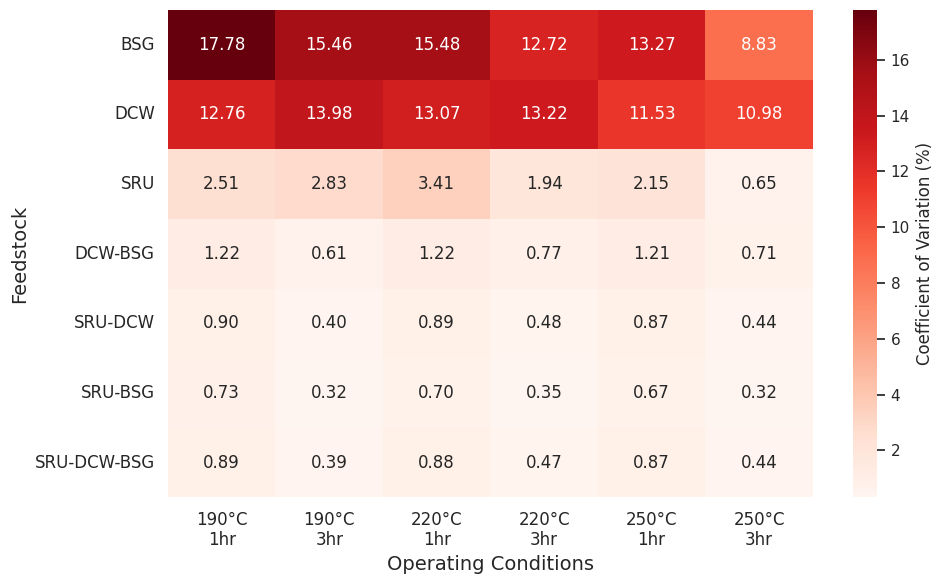

<Figure size 640x480 with 0 Axes>

In [131]:
hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(hc_hhv_lcia_list, 'gram hydrochar / HHV')
# plot_variability_heatmap(plotting_data, "Coefficient of Variation (%)")
fig = plot_variability_heatmap(plotting_data, "Coefficient of Variation (%)")
plt.savefig("figures/Figure 5.png")

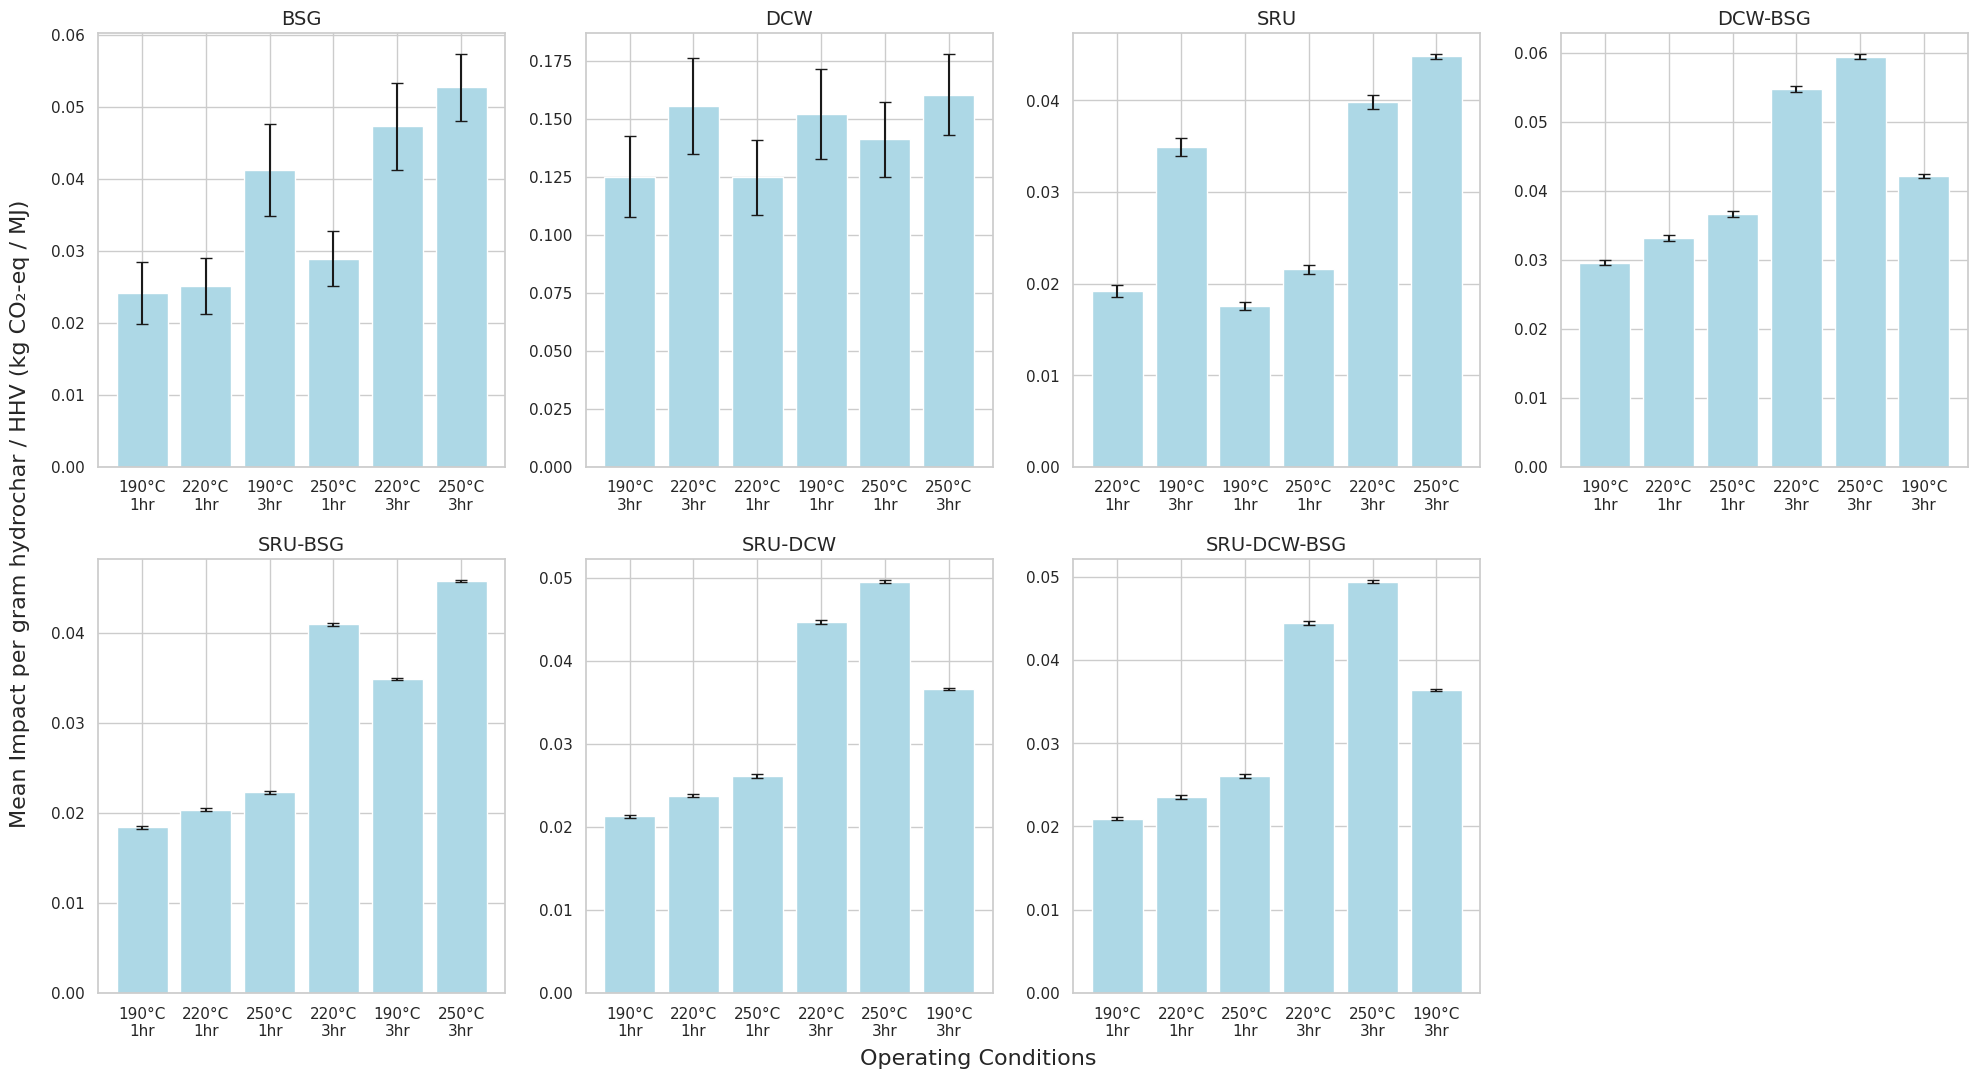

In [132]:
hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(hc_hhv_lcia_list, 'gram hydrochar / HHV')
plot_facet_grid_stacked_bars(plotting_data, "Mean Impact per gram hydrochar / HHV", '(kg CO\u2082-eq / MJ)')

#### 4.2.2: Feedstock Basis: HC Yield 

In [133]:
feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
create_summary_table(feedstock_lcia_list, 'gram feedstock')

Feedstock & Operating Conditions  Mean Impact per gram feedstock  \
15                  BSG, 250°C, 1hr                        0.000145   
16                  BSG, 220°C, 1hr                        0.000134   
1                   BSG, 250°C, 3hr                        0.000285   
0                   BSG, 220°C, 3hr                        0.000255   
10                  DCW, 250°C, 1hr                        0.000086   
6                   SRU, 250°C, 1hr                        0.000205   
3                   BSG, 190°C, 1hr                        0.000103   
5                   DCW, 250°C, 3hr                        0.000102   
17                  BSG, 190°C, 3hr                        0.000228   
8                   SRU, 220°C, 1hr                        0.000183   
2                   DCW, 220°C, 3hr                        0.000087   
13                  DCW, 220°C, 1hr                        0.000074   
11                  SRU, 220°C, 3hr                        0.000394   
7                   SRU, 250°C, 3hr                        0.000456   
12                  SRU, 190°C, 3hr                        0.000317   
4                   SRU, 190°C, 1hr                        0.000142   
14                  DCW, 190°C, 3hr                        0.000075   
29              SRU-BSG, 250°C, 3hr                        0.000388   
25              SRU-BSG, 190°C, 3hr                        0.000281   
27              SRU-BSG, 220°C, 3hr                        0.000306   
37          SRU-DCW-BSG, 190°C, 3hr                        0.000238   
19              SRU-DCW, 190°C, 3hr                        0.000235   
41          SRU-DCW-BSG, 250°C, 3hr                        0.000285   
23              SRU-DCW, 250°C, 3hr                        0.000286   
39          SRU-DCW-BSG, 220°C, 3hr                        0.000230   
21              SRU-DCW, 220°C, 3hr                        0.000228   
31              DCW-BSG, 190°C, 3hr                        0.000169   
28              SRU-BSG, 250°C, 1hr                        0.000181   
26              SRU-BSG, 220°C, 1hr                        0.000151   
35              DCW-BSG, 250°C, 3hr                        0.000197   
24              SRU-BSG, 190°C, 1hr                        0.000123   
33              DCW-BSG, 220°C, 3hr                        0.000158   
40          SRU-DCW-BSG, 250°C, 1hr                        0.000144   
22              SRU-DCW, 250°C, 1hr                        0.000145   
38          SRU-DCW-BSG, 220°C, 1hr                        0.000124   
36          SRU-DCW-BSG, 190°C, 1hr                        0.000104   
9                   DCW, 190°C, 1hr                        0.000061   
20              SRU-DCW, 220°C, 1hr                        0.000123   
18              SRU-DCW, 190°C, 1hr                        0.000103   
34              DCW-BSG, 250°C, 1hr                        0.000115   
32              DCW-BSG, 220°C, 1hr                        0.000100   
30              DCW-BSG, 190°C, 1hr                        0.000084   

    Standard Deviation  Coefficient of Variation (%)  
15        6.911753e-06                      4.752917  
16        5.393809e-06                      4.011748  
1         9.248472e-06                      3.243123  
0         7.301074e-06                      2.858937  
10        2.304839e-06                      2.692397  
6         5.148450e-06                      2.507943  
3         2.575963e-06                      2.498807  
5         2.535812e-06                      2.473967  
17        5.341778e-06                      2.342923  
8         4.166636e-06                      2.272979  
2         1.965743e-06                      2.269417  
13        1.662332e-06                      2.233771  
11        8.206126e-06                      2.080335  
7         9.074324e-06                      1.988413  
12        6.002927e-06                      1.895897  
4         2.450731e-06                      1.729255  
14        1.30

In [134]:
# Exporting results to Excel file
path = 'results/Uncertainty_Analysis.xlsx'
with pd.ExcelWriter(path, engine='xlsxwriter') as writer:
    df = create_summary_table(feedstock_lcia_list, 'gram feedstock')
    df.to_excel(writer, sheet_name='HC Yield - Feedstock', index=False)

/tmp/ipykernel_3247438/3980777023.py:24: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = data.pivot_table(


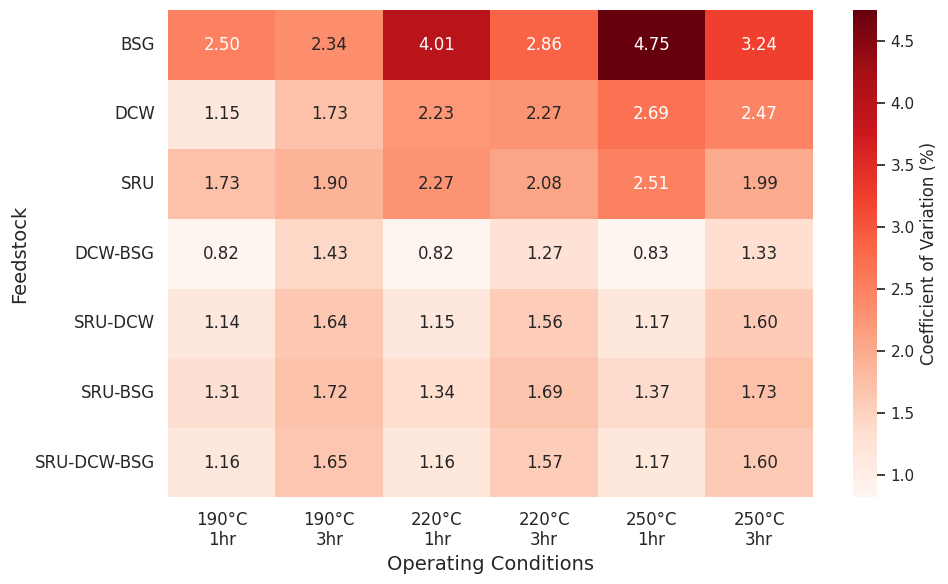

<Figure size 640x480 with 0 Axes>

In [135]:
feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(feedstock_lcia_list, 'gram feedstock')
# plot_variability_heatmap(plotting_data, "Coefficient of Variation (%)")
fig = plot_variability_heatmap(plotting_data, "Coefficient of Variation (%)")
plt.savefig("figures/Figure S4.png")

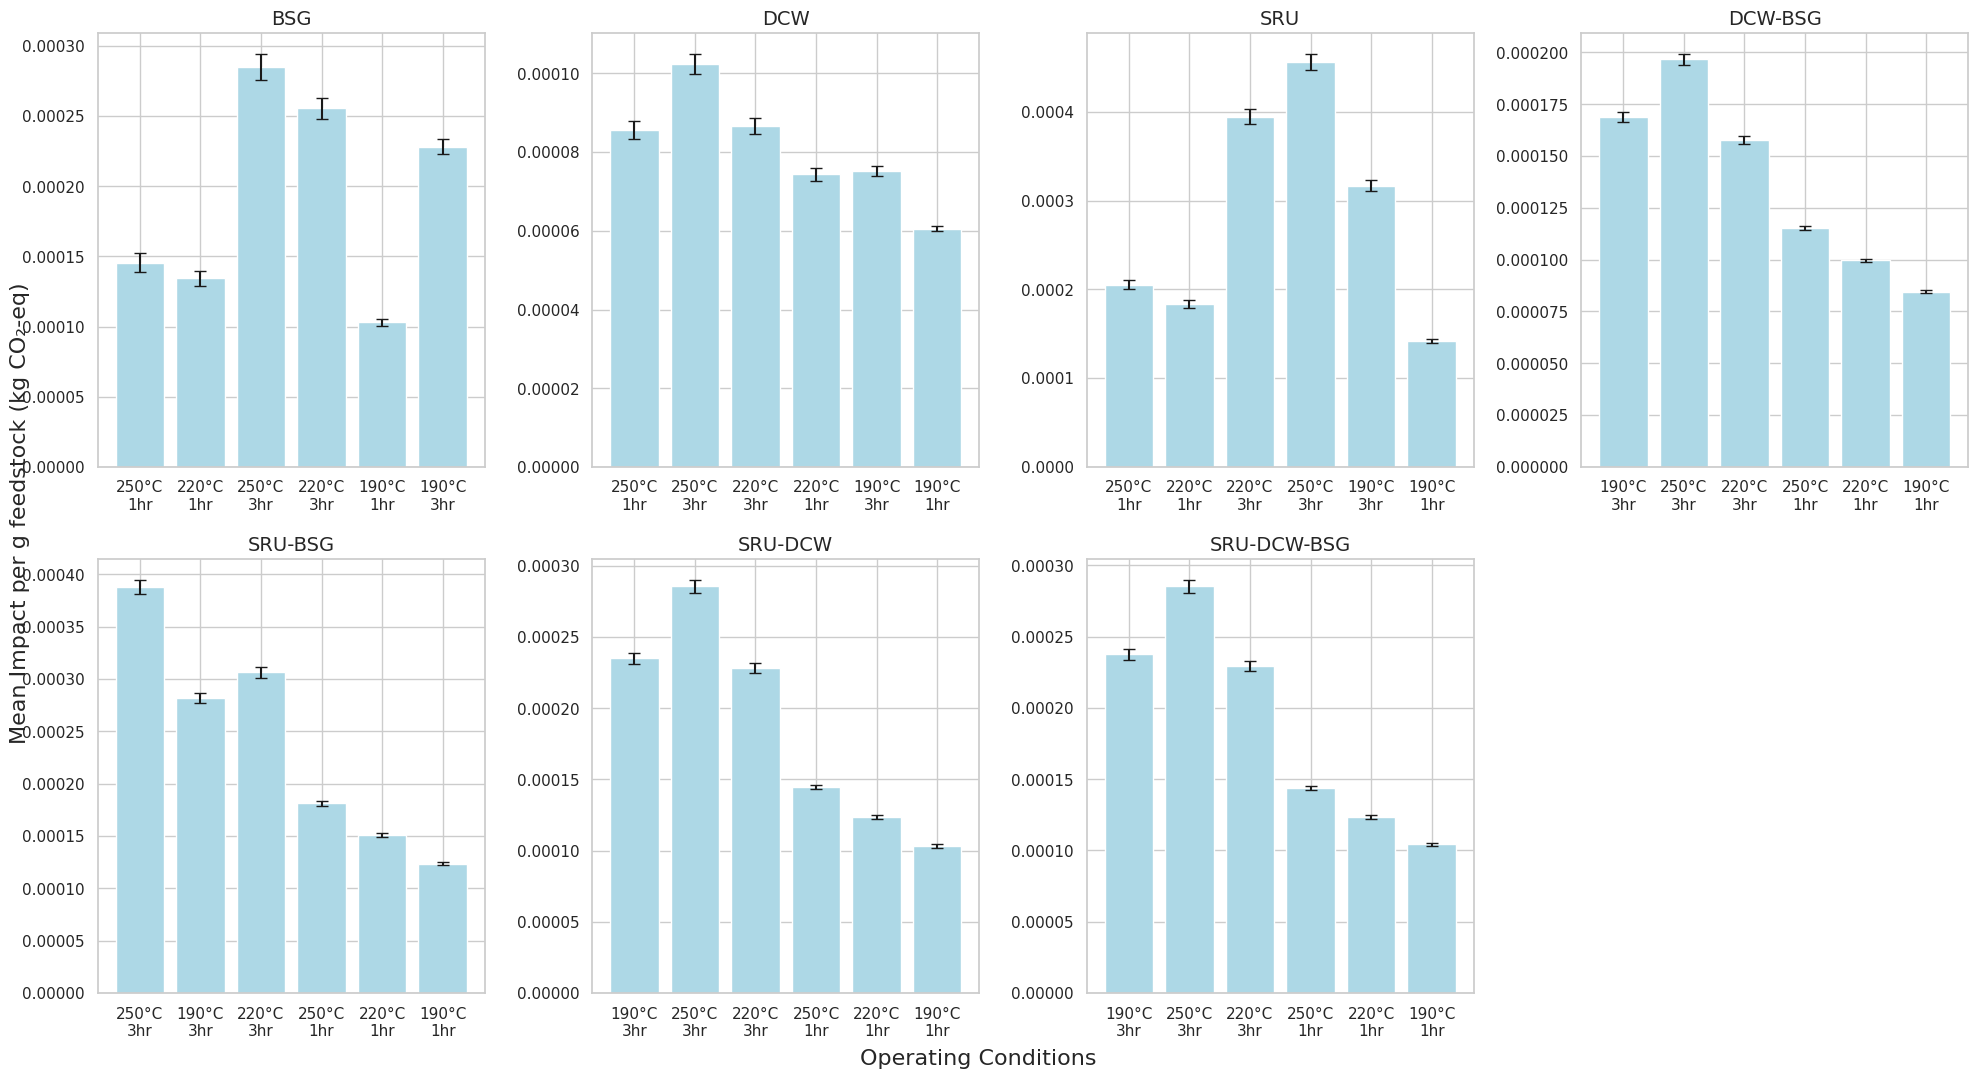

In [136]:
feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(feedstock_lcia_list, 'g feedstock')
plot_facet_grid_stacked_bars(plotting_data, "Mean Impact per g feedstock", '(kg CO\u2082-eq)')

#### 4.2.3: Hydrochar Basis: HC Yield 

In [137]:
hydrochar_lcia_list = [hc for attr, lcia in hydrochar_lcia_manager.__dict__.items() for hc in lcia]
create_summary_table(feedstock_lcia_list, 'gram hydrochar')

Feedstock & Operating Conditions  Mean Impact per gram hydrochar  \
15                  BSG, 250°C, 1hr                        0.000145   
16                  BSG, 220°C, 1hr                        0.000134   
1                   BSG, 250°C, 3hr                        0.000285   
0                   BSG, 220°C, 3hr                        0.000255   
10                  DCW, 250°C, 1hr                        0.000086   
6                   SRU, 250°C, 1hr                        0.000205   
3                   BSG, 190°C, 1hr                        0.000103   
5                   DCW, 250°C, 3hr                        0.000102   
17                  BSG, 190°C, 3hr                        0.000228   
8                   SRU, 220°C, 1hr                        0.000183   
2                   DCW, 220°C, 3hr                        0.000087   
13                  DCW, 220°C, 1hr                        0.000074   
11                  SRU, 220°C, 3hr                        0.000394   
7                   SRU, 250°C, 3hr                        0.000456   
12                  SRU, 190°C, 3hr                        0.000317   
4                   SRU, 190°C, 1hr                        0.000142   
14                  DCW, 190°C, 3hr                        0.000075   
29              SRU-BSG, 250°C, 3hr                        0.000388   
25              SRU-BSG, 190°C, 3hr                        0.000281   
27              SRU-BSG, 220°C, 3hr                        0.000306   
37          SRU-DCW-BSG, 190°C, 3hr                        0.000238   
19              SRU-DCW, 190°C, 3hr                        0.000235   
41          SRU-DCW-BSG, 250°C, 3hr                        0.000285   
23              SRU-DCW, 250°C, 3hr                        0.000286   
39          SRU-DCW-BSG, 220°C, 3hr                        0.000230   
21              SRU-DCW, 220°C, 3hr                        0.000228   
31              DCW-BSG, 190°C, 3hr                        0.000169   
28              SRU-BSG, 250°C, 1hr                        0.000181   
26              SRU-BSG, 220°C, 1hr                        0.000151   
35              DCW-BSG, 250°C, 3hr                        0.000197   
24              SRU-BSG, 190°C, 1hr                        0.000123   
33              DCW-BSG, 220°C, 3hr                        0.000158   
40          SRU-DCW-BSG, 250°C, 1hr                        0.000144   
22              SRU-DCW, 250°C, 1hr                        0.000145   
38          SRU-DCW-BSG, 220°C, 1hr                        0.000124   
36          SRU-DCW-BSG, 190°C, 1hr                        0.000104   
9                   DCW, 190°C, 1hr                        0.000061   
20              SRU-DCW, 220°C, 1hr                        0.000123   
18              SRU-DCW, 190°C, 1hr                        0.000103   
34              DCW-BSG, 250°C, 1hr                        0.000115   
32              DCW-BSG, 220°C, 1hr                        0.000100   
30              DCW-BSG, 190°C, 1hr                        0.000084   

    Standard Deviation  Coefficient of Variation (%)  
15        6.911753e-06                      4.752917  
16        5.393809e-06                      4.011748  
1         9.248472e-06                      3.243123  
0         7.301074e-06                      2.858937  
10        2.304839e-06                      2.692397  
6         5.148450e-06                      2.507943  
3         2.575963e-06                      2.498807  
5         2.535812e-06                      2.473967  
17        5.341778e-06                      2.342923  
8         4.166636e-06                      2.272979  
2         1.965743e-06                      2.269417  
13        1.662332e-06                      2.233771  
11        8.206126e-06                      2.080335  
7         9.074324e-06                      1.988413  
12        6.002927e-06                      1.895897  
4         2.450731e-06                      1.729255  
14        1.30

In [138]:
# Exporting results to Excel file
path = 'results/Uncertainty_Analysis.xlsx'
with pd.ExcelWriter(path, engine='xlsxwriter') as writer:
    df = create_summary_table(hydrochar_lcia_list , 'gram hydrochar')
    df.to_excel(writer, sheet_name='HC Yield - HC', index=False)

/tmp/ipykernel_3247438/3980777023.py:24: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = data.pivot_table(


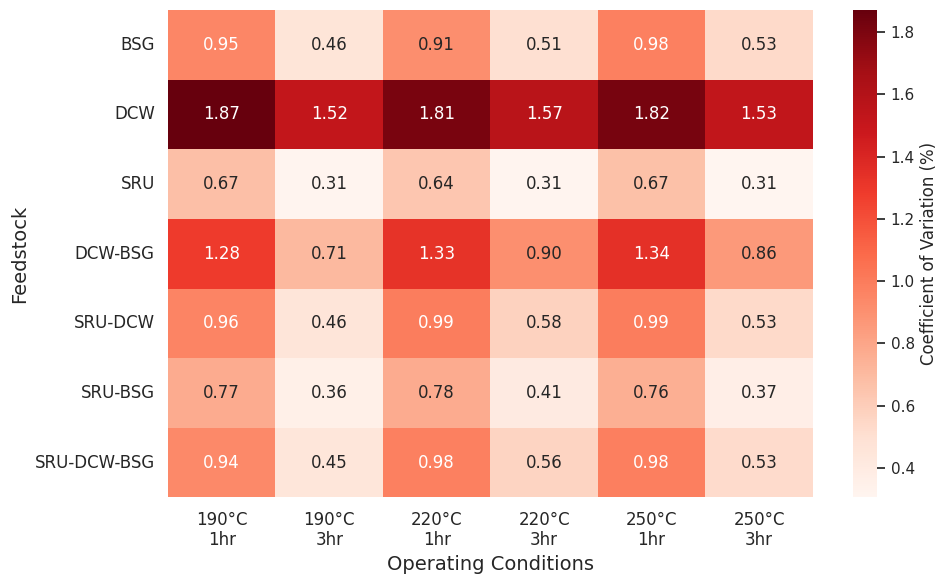

<Figure size 640x480 with 0 Axes>

In [139]:
hydrochar_lcia_list = [hc for attr, lcia in hydrochar_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(hydrochar_lcia_list , 'gram hydrochar')
plot_variability_heatmap(plotting_data, "Coefficient of Variation (%)")
# fig = plot_variability_heatmap(plotting_data, "Coefficient of Variation (%)")
plt.savefig("figures/Figure S5.png")

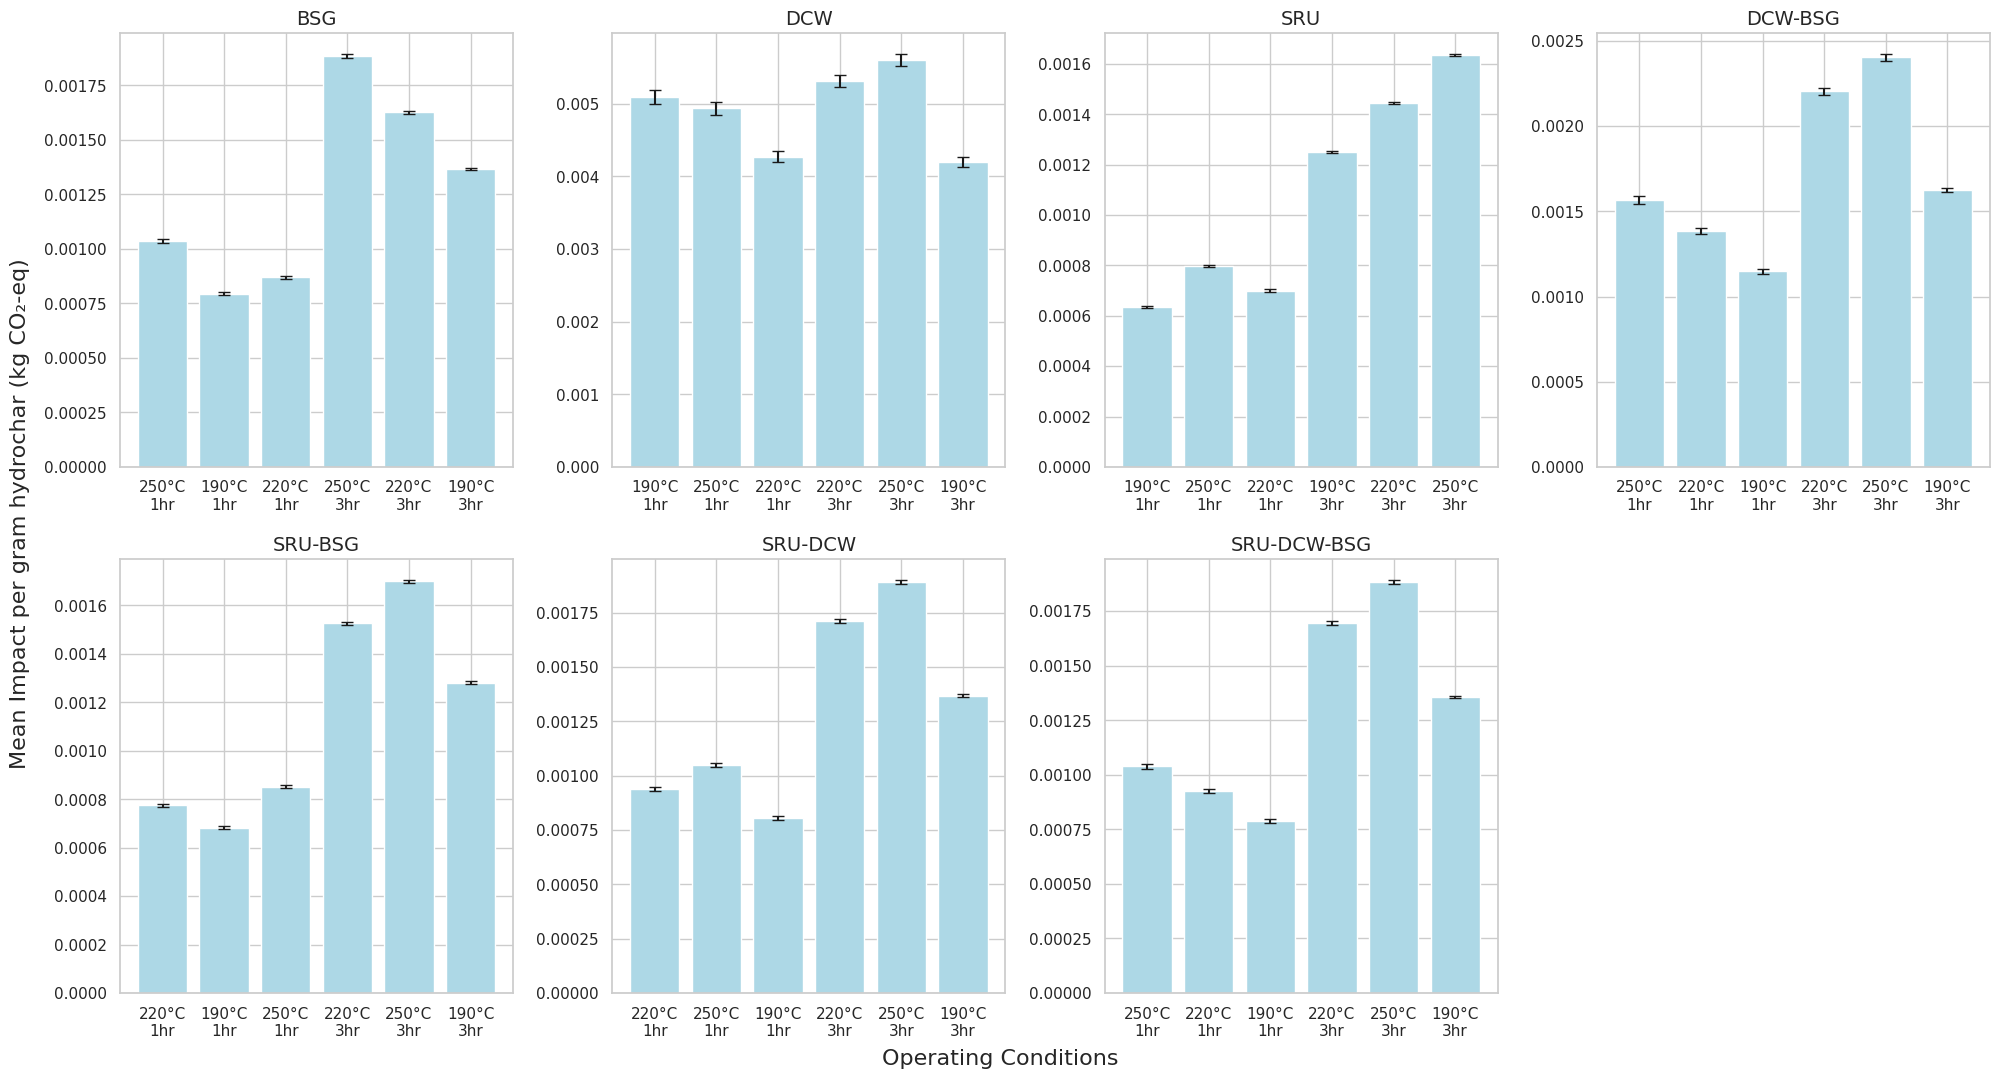

In [140]:
hydrochar_lcia_list = [hc for attr, lcia in hydrochar_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(hydrochar_lcia_list, 'gram hydrochar')
plot_facet_grid_stacked_bars(plotting_data, "Mean Impact per gram hydrochar", '(kg CO\u2082-eq)')

In [141]:
raise RuntimeError("Execution stopped intentionally: Ensure supplementary information is referenced before running all cells.")

RuntimeError: Execution stopped intentionally: Ensure supplementary information is referenced before running all cells.

## 5: Supplementary Information
The following sections contains of additional scripts that may be helpful for further analysis or for visualization purposes, but were outside of the scope of the paper. 

### 5.1: 3D Pareto Fronts 
Visualizing all standardization techniques through three-dimensional plots. 

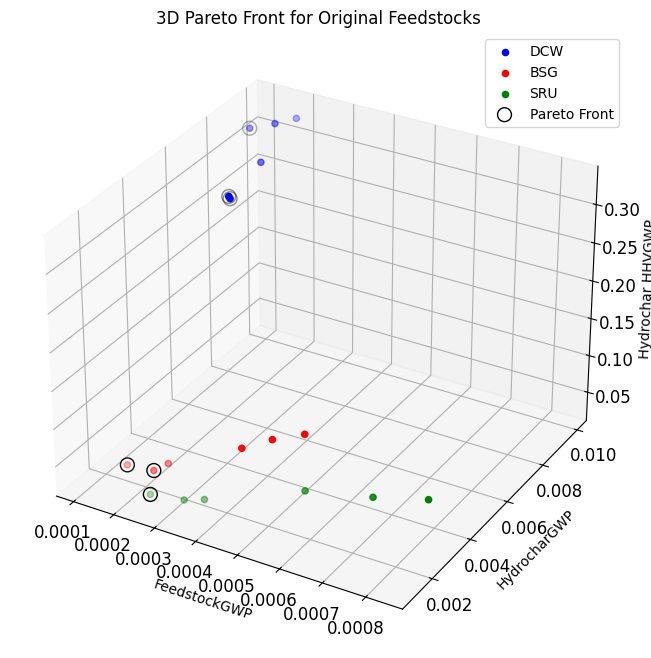

: 

: 

: 

In [ ]:
# Gathering Data 
dcw_data = get_gwp_data('rawDCW', ['Feedstock', 'Hydrochar', 'Hydrochar HHV'])
bsg_data = get_gwp_data('stdBSG', ['Feedstock', 'Hydrochar', 'Hydrochar HHV'])
sru_data = get_gwp_data('stdSRU', ['Feedstock', 'Hydrochar', 'Hydrochar HHV'])
data = pd.concat([dcw_data, bsg_data, sru_data], ignore_index=True, sort=False)

# Compute Pareto front
pareto_front = get_pareto_front(data)

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all data points
ax.scatter(dcw_data.iloc[:, 1], dcw_data.iloc[:, 2], dcw_data.iloc[:, 3], color='blue', label='DCW')
ax.scatter(bsg_data.iloc[:, 1], bsg_data.iloc[:, 2], bsg_data.iloc[:, 3], color='red', label='BSG')
ax.scatter(sru_data.iloc[:, 1], sru_data.iloc[:, 2], sru_data.iloc[:, 3], color='green', label='SRU')

# Plot Pareto front
ax.scatter(pareto_front[:, 0], pareto_front[:, 1], pareto_front[:, 2], color='none', label='Pareto Front', s=100, edgecolor='k')

# Labels and title
ax.set_xlabel(data.columns[1] + ' GWP')
ax.set_ylabel(data.columns[2] + ' GWP')
ax.set_zlabel(data.columns[3] + ' GWP')
ax.set_title(f'3D Pareto Front for Original Feedstocks')

# Add legend
ax.legend()

plt.show()

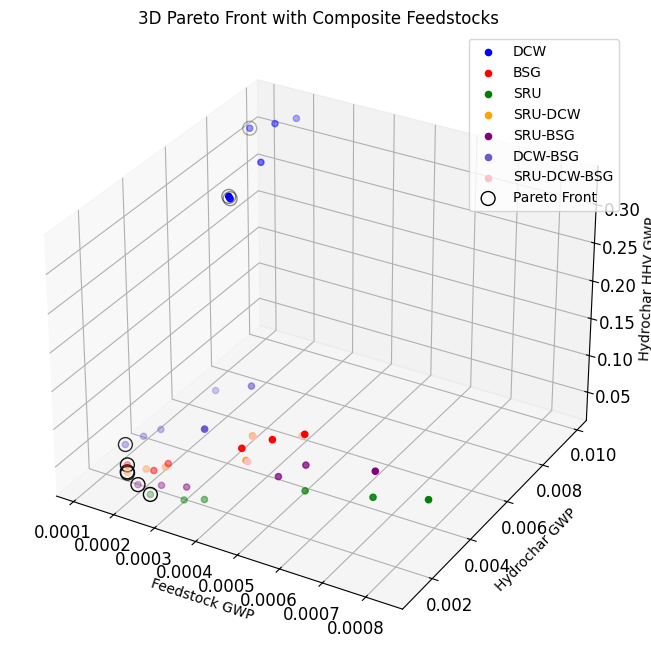

: 

: 

: 

In [ ]:
# Gathering Data 
dcw_data = get_gwp_data('rawDCW_', ['Feedstock', 'Hydrochar', 'Hydrochar HHV'])
bsg_data = get_gwp_data('stdBSG_', ['Feedstock', 'Hydrochar', 'Hydrochar HHV'])
sru_data = get_gwp_data('stdSRU_', ['Feedstock', 'Hydrochar', 'Hydrochar HHV'])
rawSRU50_rawDCW50 = get_gwp_data('rawSRU50_rawDCW50', ['Feedstock', 'Hydrochar', 'Hydrochar HHV'])
rawSRU50_rawBSG50 = get_gwp_data('rawSRU50_rawBSG50', ['Feedstock', 'Hydrochar', 'Hydrochar HHV'])
rawDCW50_rawBSG50 = get_gwp_data('rawDCW50_rawBSG50', ['Feedstock', 'Hydrochar', 'Hydrochar HHV'])
rawSRU33_rawDCW33_rawBSG33 = get_gwp_data('rawSRU33_rawDCW33_rawBSG33', ['Feedstock', 'Hydrochar', 'Hydrochar HHV'])

data = pd.concat([dcw_data, bsg_data, sru_data, rawSRU50_rawDCW50, rawSRU50_rawBSG50, rawDCW50_rawBSG50, rawSRU33_rawDCW33_rawBSG33], 
                 ignore_index=True, sort=False)
data = data.drop_duplicates()

# Compute Pareto front
pareto_front = get_pareto_front(data)

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all data points
ax.scatter(dcw_data.iloc[:, 1], dcw_data.iloc[:, 2], dcw_data.iloc[:, 3], color='blue', label='DCW')
ax.scatter(bsg_data.iloc[:, 1], bsg_data.iloc[:, 2], bsg_data.iloc[:, 3], color='red', label='BSG')
ax.scatter(sru_data.iloc[:, 1], sru_data.iloc[:, 2], sru_data.iloc[:, 3], color='green', label='SRU')
ax.scatter(rawSRU50_rawDCW50.iloc[:, 1], rawSRU50_rawDCW50.iloc[:, 2], rawSRU50_rawDCW50.iloc[:, 3], color='orange', label='SRU-DCW')
ax.scatter(rawSRU50_rawBSG50.iloc[:, 1], rawSRU50_rawBSG50.iloc[:, 2], rawSRU50_rawBSG50.iloc[:, 3], color='purple', label='SRU-BSG')
ax.scatter(rawDCW50_rawBSG50.iloc[:, 1], rawDCW50_rawBSG50.iloc[:, 2], rawDCW50_rawBSG50.iloc[:, 3], color='slateblue', label='DCW-BSG')
ax.scatter(rawSRU33_rawDCW33_rawBSG33.iloc[:, 1], rawSRU33_rawDCW33_rawBSG33.iloc[:, 2], 
           rawSRU33_rawDCW33_rawBSG33.iloc[:, 3], color='pink', label='SRU-DCW-BSG')

# Plot Pareto front
ax.scatter(pareto_front[:, 0], pareto_front[:, 1], pareto_front[:, 2], color='none', label='Pareto Front', s=100, edgecolor='k')

# Labels and title
ax.set_xlabel(data.columns[1] + ' GWP')
ax.set_ylabel(data.columns[2] + ' GWP')
ax.set_zlabel(data.columns[3] + ' GWP')
ax.set_title(f'3D Pareto Front with Composite Feedstocks')

# Add legend
ax.legend()

plt.show()

### 5.2: Sensitivity Analysis: Bar Graphs
Plotting uncertainty analysis results in one graph for each sensitivity variable (HC yield, moisture content) and standardization method (feedstock, hydrochar produced, hydrochar per higher heating value)

In [ ]:
def plot_summary(lcia_list, standardization_factor, sa_variable): 

    # Grouping global warming potentials by truncated names
    grouped_data = defaultdict(list)

    for item in lcia_list:
        truncated_name = truncate_name(item.name)
        grouped_data[truncated_name].append(item.get_total_impact_score('climate_change'))

    # Calculate mean and standard deviation for each group
    means = {}
    std_devs = {}

    for name, gwps in grouped_data.items():
        means[name] = np.mean(gwps)
        std_devs[name] = np.std(gwps)

    sorted_means = dict(sorted(means.items(), key=lambda item: item[1], reverse=True))
    sorted_std_devs = {name: std_devs[name] for name in sorted_means.keys()}

    labels = list(sorted_means.keys())
    mean_values = list(sorted_means.values())
    std_errors = list(sorted_std_devs.values())

    fig, ax = plt.subplots(figsize=(10, 7))

    # Create horizontal bar chart with error bars
    # No specific process categories given, so assume a single category to plot
    ax.barh(labels, mean_values, xerr=std_errors, capsize=5, color='skyblue', edgecolor='black')
    # ax.tick_params(axis='y', labelsize=12)

    # Adding labels and title
    if standardization_factor.find('HHV') != -1: 
        ax.set_xlabel(f'Total Impact per {standardization_factor} (kg CO\u2082-Eq / MJ)') 
    else: 
        ax.set_xlabel(f'Total Impact per {standardization_factor} (kg CO\u2082-Eq)') 
    ax.set_ylabel('Feedstock & Operating Conditions')
    ax.set_title(f'Sensitivity Analysis for {sa_variable} per {standardization_factor}: GWP Impacts')

    # Set x-axis to be twice the size of the greatest bar graph value
    ax.set_xlim(0, np.max(mean_values) * 1.5)

    # Rotate y-axis labels for better readability if necessary
    plt.tight_layout()
    plt.show()

: 

: 

: 

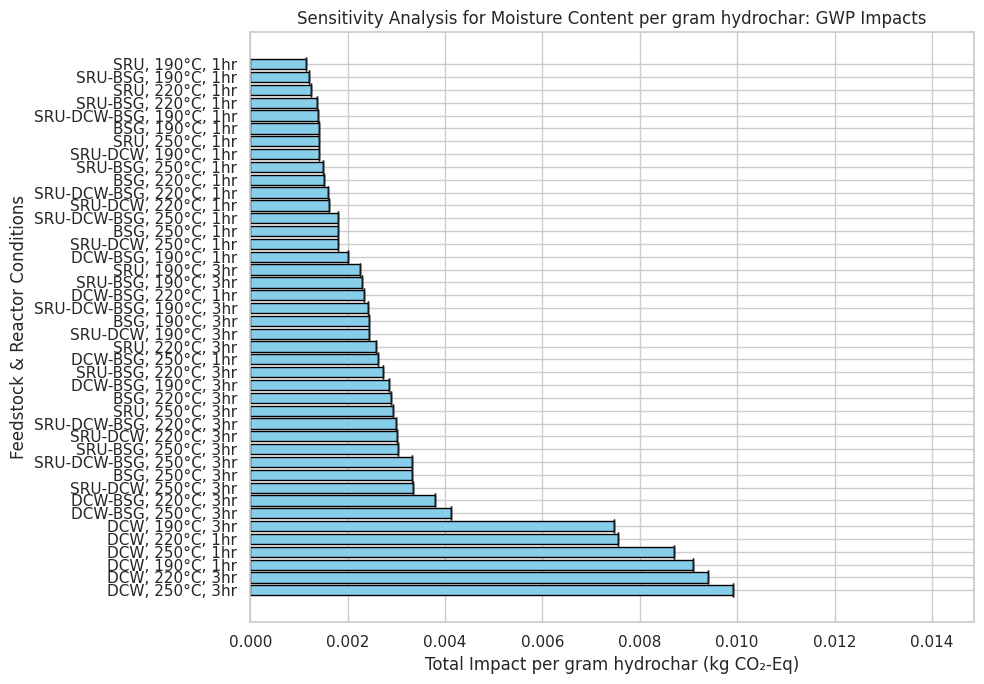

: 

: 

: 

In [ ]:
hydrochar_lcia_list = [hc for attr, lcia in hydrochar_lcia_manager.__dict__.items() for hc in lcia]
plot_summary(hydrochar_lcia_list, 'gram hydrochar', 'Moisture Content')


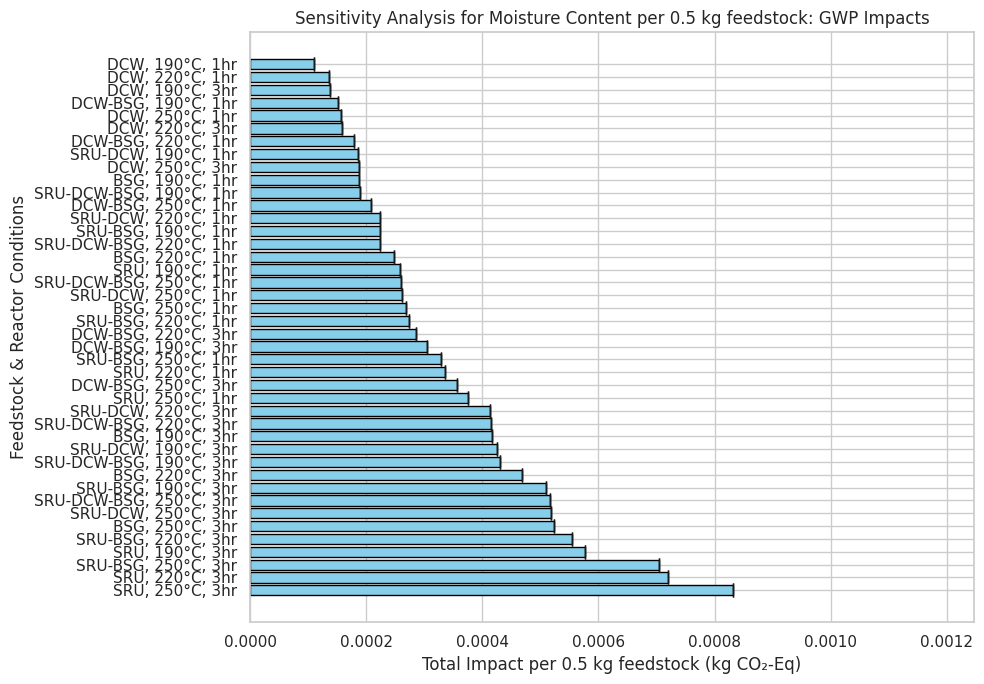

: 

: 

: 

In [ ]:
feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
plot_summary(feedstock_lcia_list, 'gram feedstock', 'Moisture Content')

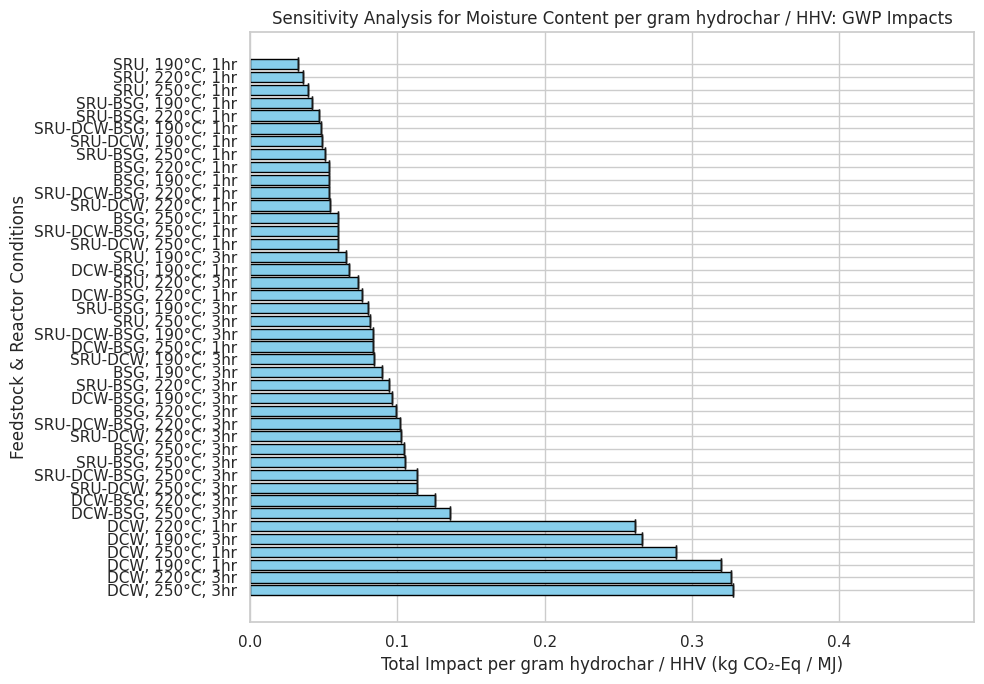

: 

: 

: 

In [ ]:
hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
plot_summary(hc_hhv_lcia_list, 'gram hydrochar / HHV', 'Moisture Content')

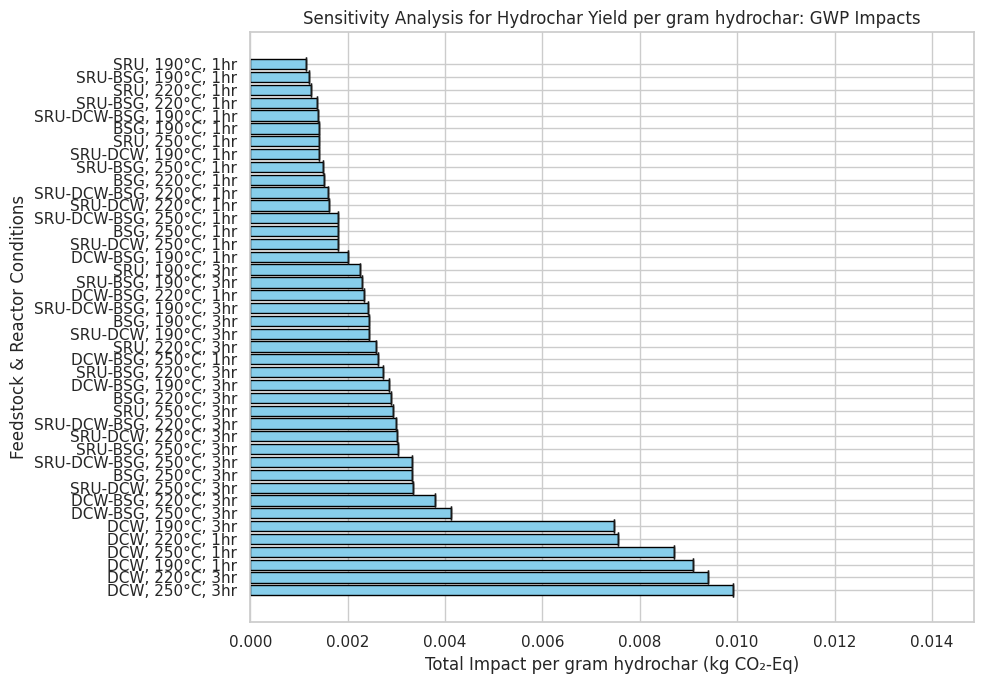

: 

: 

: 

In [ ]:
hydrochar_lcia_list = [hc for attr, lcia in hydrochar_lcia_manager.__dict__.items() for hc in lcia]
plot_summary(hydrochar_lcia_list, 'gram hydrochar', 'Hydrochar Yield')

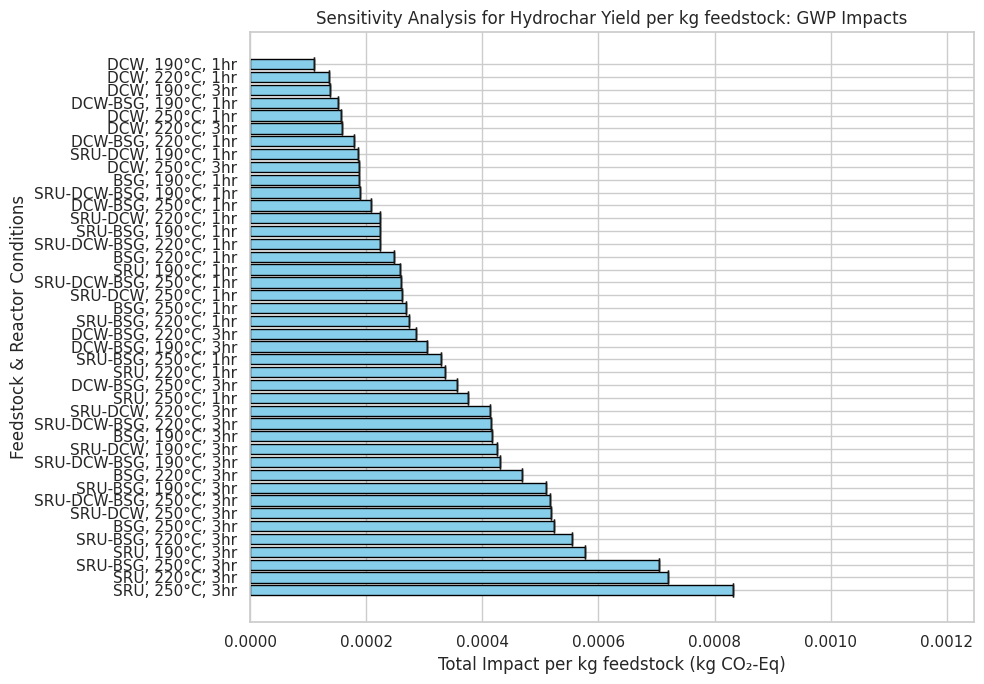

: 

: 

: 

In [ ]:
feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
plot_summary(feedstock_lcia_list, 'gram feedstock', 'Hydrochar Yield')

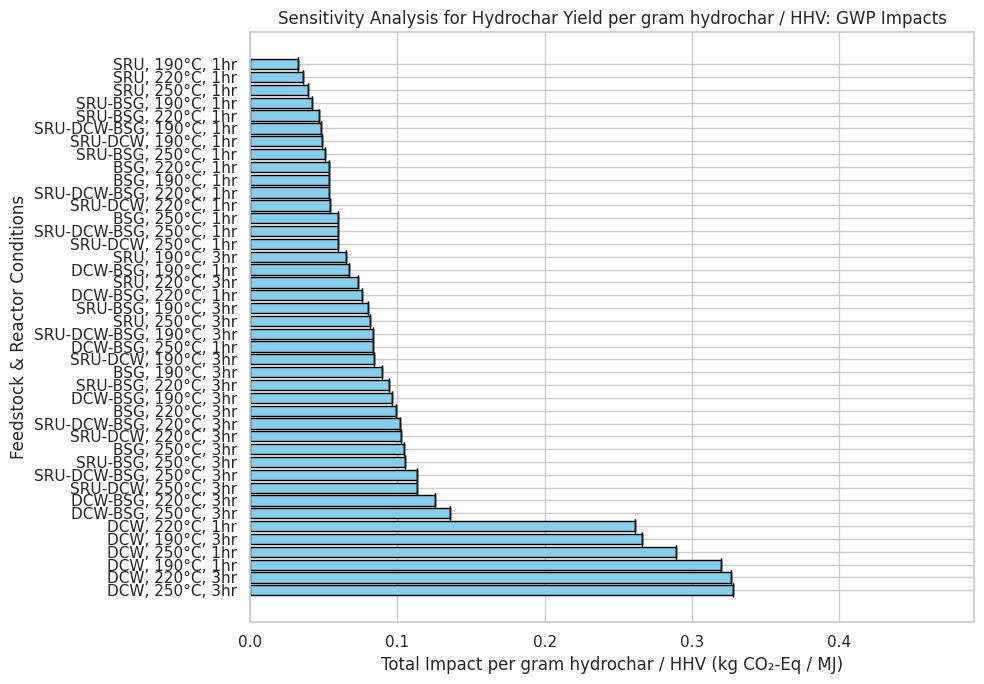

: 

: 

: 

In [ ]:
hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
plot_summary(hc_hhv_lcia_list, 'gram hydrochar / HHV', 'Hydrochar Yield')

### 5.3: Monte Carlo Simulation 
Although not utilized, a Monte Carlo simulation was set up to focus on the 'deterministic model' of the HTC process. Although there are uncertainties related to the outputs of HTC— such as hydrochar yield, gas yield, process water yield, and hydrochar characteristics — the primary goal of this Monte Carlo simulation is to examine how variability in feedstock characteristics and reaction conditions influence impact scores. 

A Monte Carlo simulation may address two key goals: (1) determining  operating conditions, and (2) identifying efficient feedstocks. Since the original baseline LCIA results show consistency across all impact categories for the different process categories, the results from one impact category in this analysis are representative of all other indicators. In this case, the Monte Carlo simulation was set up for the climate change impact category. 

It should be noted that the Monte Carlo simulation will require the utilization of more resources. 

In [ ]:
# Creates a feedstock manager to store Monte Carlo feedstocks 
monte_carlo_feedstocks = FeedstockManager()

# Define a set to keep track of feedstock names we've already added
added_feedstock_names = set()

# Creating new original feedstocks 
original_feedstocks = create_elementary_feedstocks()

for attr, feedstocks in original_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        # Select one feedstock of name rawDCW, stdBSG, stdSRU
        if any(feedstock.name.startswith(prefix) for prefix in ['rawDCW', 'stdBSG', 'stdSRU']):
            if feedstock.name not in added_feedstock_names:
                new_feedstock = copy.deepcopy(feedstock)
                new_feedstock.name = new_feedstock.name + '_mc'
                monte_carlo_feedstocks.add_feedstock(new_feedstock)
                added_feedstock_names.add(feedstock.name)

: 

: 

: 

In [ ]:
mc_parameters = ParameterManager()

: 

: 

: 

In [ ]:
def create_hydrochar_activity_mc(feedstock: Feedstock):
    '''Creates a hydrochar activity for a Monte Carlo simulation, given a feedstock'''
    feedstock.default_mc = feedstock.moisture
    temp = feedstock.temp
    time = feedstock.time 
    hydrochar_production = eidb.new_activity(
        code=f'HTC_{feedstock.name}',
        name=f"hydrochar production, {feedstock.name}",
        location='US',
        unit="kg"
    )
    yield_HC = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'HC_yield')
    gas_yield = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'gas_yield')
    project_data = [
        {
            'name': 'feedstock_' + f'HTC_{feedstock.name}', 
            'amount': get_feedstock_quantity(yield_HC, feedstock)
        }, 
        {
            'name': 'water_' + f'HTC_{feedstock.name}', 
            'amount': get_water_quantity(yield_HC, feedstock)
        }, 
        {
            'name': 'heat_' + f'HTC_{feedstock.name}', 
            'amount': get_heat_needed(feedstock, temp, time)
        },
        {
            'name': 'electricity_' + f'HTC_{feedstock.name}', 
            'amount': get_electricity_needed(feedstock, time, temp)
        }, 
        {
            'name': 'co2_' + f'HTC_{feedstock.name}',
            'amount': get_co2_emissions(yield_HC, gas_yield, feedstock)
        }, 
        {
            'name': 'wastewater_' + f'HTC_{feedstock.name}', 
            'amount': get_pw(yield_HC, gas_yield, feedstock, hc_placeholder=1)
        },
        {
            'name': 'post_processing_' + f'HTC_{feedstock.name}', 
            'amount': get_post_processing(hc_placeholder=1)
        },
        {
            'name': 'transport_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_transportation_quantity(feedstock)
        }
    ]
    
    print(project_data)
    mc_parameters.new_project_parameters(project_data)
    
    # for param in ProjectParameter.select():
    #     print(param, param.amount)
    
    # Feedstock 
    hydrochar_production.new_exchange(input=('biosphere3', 'feedstock'), amount=0, unit="kg", type='custom', formula= 'feedstock')
    hydrochar_production.save()
                        
    # Water 
    water = [act for act in eidb if 'market for water, completely softened' in act['name']  and 'US' in act['location']][0]
    hydrochar_production.new_exchange(input=water.key, amount=0, unit="kilogram", type='technosphere', 
                                        formula= 'water_' + f'HTC_{feedstock.name}').save()
    hydrochar_production.save()
    
    # Electricity
    electricity = [act for act in eidb if 'market for electricity, low voltage' in act['name']  and 'US-NPCC' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='electricity_' + f'HTC_{feedstock.name}').save()
    hydrochar_production.save()
    
    # Heat 
    electricity = [act for act in eidb if 'market for electricity, low voltage' in act['name']  and 'US-NPCC' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='heat_' + f'HTC_{feedstock.name}').save()
    hydrochar_production.save()
    
    # CO2 Emissions
    co2 = [flow for flow in biosphere3 if 'carbon dioxide, non-fossil, resource correction' in flow['name'].lower()][1]
    hydrochar_production.new_exchange(input=co2.key, amount=0, unit="kilogram", type='biosphere', 
                                        formula='-1*co2_' + f'HTC_{feedstock.name}').save()
    hydrochar_production.save()
    
    # Wastewater 
    wastewater = [act for act in eidb if 'treatment of wastewater, average, wastewater treatment' in act['name']  and 'RoW' in act['location']][0]
    hydrochar_production.new_exchange(input=wastewater.key, amount=0, unit="cubic meter", type='technosphere', 
                                        formula='-1*wastewater_' + f'HTC_{feedstock.name}/1000').save()
    hydrochar_production.save()
    
    # Post-Processing
    electricity = [act for act in eidb if 'market for electricity, low voltage' in act['name']  and 'US-NPCC' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='post_processing_' + f'HTC_{feedstock.name}').save()
    hydrochar_production.save()
    
    # Transportation 
    transport = [act for act in eidb if 'transport, freight, lorry, all sizes, EURO6' in act['name']  and 'RoW' in act['location']][0]
    hydrochar_production.new_exchange(input=transport.key, amount=0, unit="ton kilometer", type='technosphere', 
                                        formula='transport_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    mc_parameters.add_exchanges_to_group(f"hydrochar production, {feedstock.name}", hydrochar_production)
    ActivityParameter.recalculate_exchanges(f"hydrochar production, {feedstock.name}")
    print()    

: 

: 

: 

In [ ]:
# If needed, delete existing activities
for act in [act for act in eidb if 'hydrochar production' in act['name'] and '_mc' in act['name']]:
    act.delete()
    
for act in [act for act in eidb if 'hydrochar production' in act['name'] and '_mc' in act['name']]:
    print(act)

: 

: 

: 

In [ ]:
# Creating HC activities that can be tweaked for a MC Analysis. 
for attr, feedstocks in monte_carlo_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        print(feedstock)
        # print(get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'HC_yield'))
        create_hydrochar_activity_mc(feedstock)

: 

: 

: 

In [ ]:
def monte_carlo_sample(feedstock, activity, method_key, time, temp, moisture, index):
    # Resetting Feedstock
    feedstock.moisture = moisture
    feedstock.time = time
    feedstock.temp = temp
    feedstock.quantity = 0 
    feedstock.water_added = 0 
    
    # Computing & Updating Exchanges of Interest
    yield_HC = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'HC_yield')
    gas_yield = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'gas_yield')
    
    updates = []
    
    for item in [item for item in ProjectParameter.select() if f'HTC_{feedstock.name}' in str(item)]:
        if item.name == 'feedstock_' + f'HTC_{feedstock.name}':
            item.amount = get_feedstock_quantity(yield_HC, feedstock)
        elif item.name == 'water_' + f'HTC_{feedstock.name}':
            item.amount = get_water_quantity(yield_HC, feedstock)
        elif item.name == 'heat_' + f'HTC_{feedstock.name}':
            item.amount = get_heat_needed(feedstock, temp, time)
        elif item.name == 'electricity_' + f'HTC_{feedstock.name}': 
            item.amount = get_electricity_needed(feedstock, time, temp)
        elif item.name == 'co2_' + f'HTC_{feedstock.name}':
            item.amount = get_co2_emissions(yield_HC, gas_yield, feedstock)
        elif item.name == 'wastewater_' + f'HTC_{feedstock.name}':
            item.amount = get_pw(yield_HC, gas_yield, feedstock, hc_placeholder=1)
        updates.append(item)
    
    ProjectParameter.bulk_update(updates, fields=['amount'])
    ActivityParameter.recalculate_exchanges(f"hydrochar production, {feedstock.name}")
    
    # Computing New LCA Results 
    functional_unit = {activity: 1e-3}
    lca = bw.LCA(functional_unit, method_key)
    lca.lci()
    lca.lcia()
    
    # Factoring in CO2
    co2_score = 0 
    for exc in [exc for exc in activity.exchanges() if 'Carbon dioxide' in str(exc.input)]:
        co2_score = exc.amount
    
    # Return result
    return {
        'feedstock_quantity': feedstock.quantity, 
        'moisture': moisture, 
        'temp': temp, 
        'time': time, 
        'climate_impact': lca.score + co2_score 
    }

def monte_carlo_gwp(feedstock, num_samples) -> list:
    method_key = [m for m in bw.methods if 'TRACI' in str(m) and 'global warming' in str(m)][0]

    # Discrete uniform variable time: (values: 1, 3) 
    time = np.random.choice([1, 3], size=num_samples)

    # Discrete uniform variable temp: (values: 190, 220, 250)
    temp = np.random.choice([190, 220, 250], size=num_samples)
    
    # Continuous uniform variable moisture_content 
    feedstock_mc_lower = feedstock.default_mc - (feedstock.moisture_std/100)
    feedstock_mc_upper = feedstock.default_mc + (feedstock.moisture_std/100)
    moisture = np.random.uniform(feedstock_mc_lower, feedstock_mc_upper, size=num_samples)

    # Selecting relevant activity 
    activity = [act for act in eidb if f"hydrochar production, {feedstock.name}" in act['name']][0]
    
    # Prepare arguments for parallel processing
    args = [(feedstock, activity, method_key, time[i], temp[i], moisture[i], i) for i in range(num_samples)]

    # Run simulations in parallel
    with mp.Pool(mp.cpu_count()) as pool:
        mc_results = list(tqdm(pool.imap_unordered(monte_carlo_sample, args), total=num_samples, desc=f"{feedstock.name} Monte Carlo simulation"))
    
    return mc_results

: 

: 

: 

In [ ]:
def monte_carlo_gwp(feedstock, num_samples) -> list: 
    '''
    Computes a Monte Carlo simulation on a per feedstock basis. 
    Returns a list of length num_samples with the following elements for each iteration: feedstock.quantity, moisture, temp, time, lca.score
    '''
    # num_samples = 1000
    method_key = [m for m in bw.methods if 'TRACI' in str(m) and 'global warming' in str(m)][0]
    mc_results = []

    # Discrete uniform variable time: (values: 1, 3) 
    time = np.random.choice([1, 3], size=num_samples)

    # Discrete uniform variable temp: (values: 190, 220, 250)
    temp = np.random.choice([190, 220, 250], size=num_samples)
    
    # Continuous uniform variable moisture_content 
    feedstock_mc_lower = feedstock.default_mc - (feedstock.moisture_std/100)
    feedstock_mc_upper = feedstock.default_mc + (feedstock.moisture_std/100)
    moisture = np.random.uniform(feedstock_mc_lower, feedstock_mc_upper, size=num_samples)

    # Selecting relevant activity 
    activity = [act for act in eidb if f"hydrochar production, {feedstock.name}" in act['name']][0]

    for i in tqdm(range(num_samples), desc=f"{feedstock.name} Monte Carlo simulation"):
        
        # Resetting Feedstock 
        feedstock.moisture = moisture[i]
        feedstock.time = time[i]
        feedstock.temp = temp[i]
        feedstock.quantity = 0 
        feedstock.water_added = 0 
        
        # Computing & Updating Exchanges of Interest 
        yield_HC = get_parameter(f"hydrochar production, {feedstock.name}_{temp[i]}C_{time[i]}hr", 'HC_yield')
        gas_yield = get_parameter(f"hydrochar production, {feedstock.name}_{temp[i]}C_{time[i]}hr", 'gas_yield')
        
        updates = []
        
        for item in [item for item in ProjectParameter.select() if f'HTC_{feedstock.name}' in str(item)]:
            if item.name == 'feedstock_' + f'HTC_{feedstock.name}':
                item.amount = get_feedstock_quantity(yield_HC, feedstock)
                item.save()       
            elif item.name == 'water_' + f'HTC_{feedstock.name}':
                item.amount = get_water_quantity(yield_HC, feedstock)
                item.save()
            elif item.name == 'heat_' + f'HTC_{feedstock.name}':
                item.amount = get_heat_needed(feedstock, temp[i], time[i])
                item.save()
            elif item.name == 'electricity_' + f'HTC_{feedstock.name}': 
                item.amount = get_electricity_needed(feedstock, time[i], temp[i])
                item.save()
            elif item.name == 'co2_' + f'HTC_{feedstock.name}':
                item.amount = get_co2_emissions(yield_HC, gas_yield, feedstock)
                item.save()
            elif item.name == 'wastewater_' + f'HTC_{feedstock.name}':
                item.amount = get_pw(yield_HC, gas_yield, feedstock, hc_placeholder=1)
                item.save()
                mc_parameters.add_exchanges_to_group(f"hydrochar production, {feedstock.name}", activity)
            
            # Post-processing stays constant 
            updates.append(item)
        
        ProjectParameter.bulk_update(updates, fields=['amount'])
        ActivityParameter.recalculate_exchanges(f"hydrochar production, {feedstock.name}")
        activity.save()
            
        # Computing New LCA Results 
        functional_unit = {activity: 1e-3}
        lca = bw.LCA(functional_unit, method_key)
        lca.lci()
        lca.lcia()
        
        # Factoring in CO2
        co2_score = 0 
        for exc in [exc for exc in activity.exchanges() if 'Carbon dioxide' in str(exc.input)]:
            co2_score = exc.amount
            
        
        # Save results
        mc_results = []
        mc_results.append({
            'feedstock_quantity': feedstock.quantity, 
            'moisture': moisture, 
            'temp': temp, 
            'time': time, 
            'climate_impact': lca.score + co2_score 
        })
        # print()
        
    return mc_results                
    

: 

: 

: 

In [ ]:
for attr, feedstocks in monte_carlo_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        print('Running MC for', feedstock.name)
        feedstock.mc_results = monte_carlo_gwp(feedstock, 1000)

: 

: 

: 